# Performing basic uni- and multivariate statistical analsysis of untargeted metabolomics data

**Updated on:** 2023-08-01 17:06:27 CEST

In this Jupyter Notebook we perform basic explorative uni- and multivariate statistical analyses of an untargeted metabolomics data set, including data cleaning steps such as batch correction and normalization.

<div class="alert alert-block alert-info">
    
**Authors**: Abzer Kelminal (abzer.shah@uni-tuebingen.de), Francesco Russo (russof85@gmail.com), Filip Ottosson (faot@ssi.dk), Marcelo Navarro-Diaz(marcelo.navarro-diaz@uni-tuebingen.de), Jan Stanstrup (jst@nexs.ku.dk), Madeleine Ernst (maet@ssi.dk) <br>
**Input file format**: .csv files or .txt files <br>
**Outputs**: .csv files, .pdf & .svg images  <br>
**Dependencies**: pacman, tidyverse, factoextra, KODAMA, vegan, IRdisplay, svglite, matrixStats, ggsci, FSA, cowplot, BiocManager, ComplexHeatmap, dendextend, NbClust, xgboost, caret, doParallel

The session info at the end of this notebook gives info about the versions of all the packages used here.
    </div>

A guide on how to run R within a Jupyter Notebook can be found here: [Installing via Anaconda Navigator](https://github.com/Functional-Metabolomics-Lab/Jupyter-Notebook-Installation/blob/main/Anaconda_Rkernel_installation_JupyterNotebook_JupyterLab.pdf), [Installation of R Jupyter Notebook through command terminal](https://developers.refinitiv.com/en/article-catalog/article/setup-jupyter-notebook-r)

---

<b> Before starting to run this notebook with your own data, remember to save a copy of this notebook in your own Google Drive! Do so by clicking on File &rarr; Save a copy in Drive. You can give whatever meaningful name to your notebook.
This file should be located in a new folder of your Google Drive named 'Colab Notebooks'. You can also download this notebook: File &rarr; Download &rarr; Download .ipynb.</b>

---

<div class="alert alert-block alert-warning">
<b><font size=3> SPECIAL NOTE: Please read the comments before proceeding with the code and let us know if you run into any errors and if you think it could be commented better. We would highly appreciate your suggestions and comments!!</font> </b> </div>

# <font color ='blue'> 1. Introduction </font>
<a name='intro'></a>

<p style='text-align: justify;'> The example files used in this tutorial are part of a study published by <a href="https://doi.org/10.1016/j.chemosphere.2020.129450">Petras and coworkers (2021)</a>. Here, the authors investigated the coastal environments in northern San Diego, USA, after a major rainfall event in winter 2017/2018 to observe the seawater chemotype. The dataset contains surface seawater samples collected (−10 cm) at 30 sites spaced approximately 300 meters apart and 50–100 meters offshore along the San Diego coastline from Torrey Pines State Beach to Mission Bay (Torrey Pines, La Jolla Shores, La Jolla Reefs, Pacific and Mission Beach) at 3 different time points: Dec 2017, Jan 2018 (After a major rainfall, resulting in decreased salinity of water) and Oct 2018. As a result of the study, a huge shift was observed in the seawater's organic matter chemotype after the rainfall. <br>

<p style='text-align: justify;'> Seawater samples collected during October 2018, were not published in the original article, but are added to this tutorial to have an increased sample size. The datasets used here can be found in the MassIVE repository: <a href="https://massive.ucsd.edu/ProteoSAFe/dataset.jsp?task=8a8139d9248b43e0b0fda17495387756">MSV000082312</a> and <a href="https://massive.ucsd.edu/ProteoSAFe/dataset.jsp?task=c8411b76f30a4f4ca5d3e42ec13998dc">MSV000085786</a>. The .mzml files
were preprocessed using <a href="http://mzmine.github.io/">MZmine3</a> and the <a href="https://gnps.ucsd.edu/ProteoSAFe/status.jsp?task=b661d12ba88745639664988329c1363e">feature-based molecular networking workflow in GNPS</a>.</p>

<p style='text-align: justify;'> We initially clean the feature table by batch correction, blank removal, imputation, normalization, and scaling. Then, we perform univariate and multivariate statistical analyses including unsupervised learning methods (e.g., PCoA and clustering) and supervised classification analysis (Random Forest). Each step is discussed briefly in its own sections.</p>

---

# <font color ='blue'> 2. Preliminary setup for the notebook </font>
<a name='Section-2'>

## Package installation

### <font color ='darkblue'> Step 1: Installing and loading necessary packages </font>
<a id = 'pkg_install'></a>
Before we start, we need to install all packages neede for our analyses and load the installed packages into our session. Since we have many packages for different sections, we install the packages right before the respective sections to reduce the installation time.

In [2]:
options(install.packages.compile.from.source="never") 

<b>TIP:</b> # operator refers to comments describing the function of a code. Code lines beginning with # is "commented out" and it will not run. To run a commented out code, remove the # and run it again.

In [3]:
if (!require("pacman")) install.packages("pacman") #Installing pacman if not present

Loading required package: pacman



Although install.packages() is commonly used to install packages, we use the 'p_load' function from 'pacman' package to install and load the packages. p_load initially checks if a package is installed, if not it tries to install the package from CRAN (and/or any other repository in the pacman repository list) and load the packages.

<font color="red"><font size=3> Installation will take about 15 mins !!</font>

In [200]:
pacman::p_load("tidyverse","factoextra","KODAMA","vegan","IRdisplay","svglite")

<b> Packages for data-cleanup & multivariate statistics:</b><br>
- tidyverse - used for data science. The eight core packages inside this library are: ggplot2 (data visualisation), dplyr (data manipulation), tidyr, readr, purrr, tibble, stringr, and forcats
- factoextra - for extracting and visualizing outputs of multivariate analyses such as PCA, k-means
- vegan - popular library for analysing ecological diversity and for multivariate analysis of community data. Here, we use it for PCoA
- IRdisplay - better display of output cells in Jupyter Notebooks running iwth IRKernel. Library not needed when running the script in RStudio
- KODAMA - to use the normalisation function
- svglite - to save plots in .svg format: although 'ggsave' function is provided in ggplot2 to save as .svg, for plots that are not ggplots, such as heatmaps, 'ggsave' will not work. Hence, we use svglite

<b> Packages for univariate statistics:</b><br>
- ggsci - provides color palettes for ggplot2 that can be used for scientific journals
- FSA - for dunn test
- matrixStats - contains highly optimized functions to perform statistics on matrix data
- cowplot - efficient functions to arrange several plots

<b> Packages for clustering & heatmaps:</b><br>
- ComplexHeatmap- for visualising heatmaps
- dendextend - for getting dendograms
- NbClust - for finding the optimum no.of clusters to be used for a clustering method

<b> Packages for supervised classification:</b><br>
- rfPermute

We also set some global options to adjust plot size throughout the notebook

In [4]:
#Global settings for plot size in the output cell:
options(repr.plot.width=10, repr.plot.height=10,res=600) # the parameters: width, height & resolution can be changed

### <font color ='darkblue'> Step 2: Setting a local working directory </font>
<a name = "set_dir"></a>

<p style='text-align: justify;'> When we set a folder (or directory) as the working directory, we can access the files within the folder just by its names without mentioning the entire file path everytime we use it. Also, all the output files will be saved under the working directory. So, before proceeding with the script further, if you are trying to use your own files for the notebook, then please make sure to include all the necessary input files in one local folder and set it as your working directory. </p>

<div class="alert alert-block alert-warning">
<b>NOTE:</b> When you run the next cell, it will display an output box where you can simply enter the path of the folder containing all your input files in your local computer. For example: D:\User\Project\Test_Data </div>

It will be set as your working directory and you can access all the files within it. <b> Whenever you see an output box asking for user input, please note, the script will not proceed further without your input. Hence, make sure to run the notebook cell-by-cell instead of running all cells in the notebook simultaneously. </b> 

<p style='text-align: justify;'>In Google Colab homepage &rarr; there are 3 icons on the upper left corner. Click on the 3 dots to see the contents of the notebook. To create a folder with your input files, click on the folder icon &rarr; Right-click anywhere on the empty space within the left section in Google Colab &rarr; Select 'new folder' &rarr; Copy the path and paste in the output box of next cell </p>

In [2]:
Directory <- normalizePath(readline("Enter the folder path in the output box: "),"/",mustWork=FALSE)
setwd(Directory)

Enter the folder path in the output box:  C:\Users\abzer\OneDrive\Documents\GitHub\Statistical-analysis-of-non-targeted-LC-MSMS-data\data


---

## Data import
<a name='load_ip'></a>

<b><u>Files needed for running the Notebook:</b></u>  

1) <b>Feature table:</b> A typical output file of an LC-MS/MS metabolomics experiment, containing all mass spectral features (or peaks) with their corresponding relative intensities across samples. The feature table we use in this tutorial was obtained from MZmine3. (Filetype: .csv file) <br> 

2) <b>Metadata:</b> An Excel file saved in .txt format that is created by the user, providing additional information about the samples (e.g. sample type, tissue type, species, timepoint of collection etc.) In this tutorial we are using the [metadata format recognized by GNPS workflows](https://ccms-ucsd.github.io/GNPSDocumentation/metadata/). The first column should be named 'filename' and all remaining column headers should be prefixed with ATTRIBUTE_: e.g. ATTRIBUTE_SampleType, ATTRIBUTE_timepoint etc. (Filetype: .txt file) <br>

Feature table and metadata used in this tutorial can be accessed at <a href="https://github.com/Functional-Metabolomics-Lab/FBMN-STATS/tree/main/data">our Functional Metabolomics Git Repository.</a>

3) <b>OPTIONAL:</b> Annotation files such as GNPS library annotations, GNPS analog annotations, SIRIUS annotations.

<b><u>More on Annotation files:</u></b>  
<p style='text-align: justify;'> If available, provide the files for molecular annotations such as SIRIUS, CANOPUS annotation files. SIRIUS and CANOPUS performs molecular formula prediction and chemical class predictions respectively. GNPS annotation files are obtained as a result of Feature-Based Molecular Networking (FBMN) analysis on the feature table (provided along with its corresponding metadata). <a href="https://gnps.ucsd.edu/ProteoSAFe/status.jsp?task=b661d12ba88745639664988329c1363e">The FBMN job is also publicly available.</a> These GNPS annotation files can be directly accessed with their task ID. More on this on <a href='#gnps_files'>step 6</a>. </p>

<b><u>To download the FBMN results locally:</u></b>  
<p style='text-align: justify;'> Go to your <b>MassIVE</b> or <b>GNPS</b> account &rarr; Jobs &rarr; Click on <b>Status</b> of your FBMN Workflow &rarr; Download Cytoscape Data &rarr; A folder will be downloaded. For Ex: "ProteoSAFe-FEATURE-BASED-MOLECULAR-NETWORKING-5877234d-download_cytoscape_data" &rarr; Unzip this folder to access several sub-folders containing files uploaded for FBMN, such as the feature table, metadata table, and graphml file for visualizing the molecular network (found under the folder "gnps_molecular_network_graphml"). 
<br/> FBMN also offers the option to annotate compounds through GNPS spectral library search or an advanced analog search. These annotated files can be found in the sub-folders <b>"DB_result"</b> and <b>"DB_analog_result"</b> (if analog search is performed). During analog search, the method searches for structurally related molecules within the molecular network using a score threshold, such as a minimum cosine score that MS/MS spectra should achieve in spectral matching with MS/MS spectral libraries to be considered an annotation. In the given example, GNPS annotation annotated 255 compounds, while analog search annotated 1987 compounds. However, it is important to assess the analog annotations by looking at the cosine score and mirror match accuracy. </p>

[![More on MZmine](https://img.shields.io/badge/More%20on-MZmine-blue)](https://www.nature.com/articles/s41587-023-01690-2)
[![More on GNPS](https://img.shields.io/badge/More%20on-GNPS-informational)](https://www.nature.com/articles/nbt.3597#Abs2)
[![More on FBMN](https://img.shields.io/badge/More%20on-FBMN-blue)](https://www.nature.com/articles/s41592-020-0933-6) 
[![More on SIRIUS](https://img.shields.io/badge/More%20on-SIRIUS-blue)](https://boecker-lab.github.io/docs.sirius.github.io/)

---

### <font color ='darkblue'> Step 3: Uploading Files to Google Colab </font>

To upload files into Google Colab &rarr; Right-click on the folder you created to 'upload' the necessary files from your computer into the cloud session.

### <font color ='darkblue'> Step 4 to 6: Data Loading (Choose one method) </font>
We can load the data files into the script either from the local working directory or from the web using url.

#### Step 4: Loading files from a local folder

Please make sure to include all the necessary input files in the folder you have set as working directory

In [3]:
file_names <- list.files('.') #list all the files in the working directory (mentioned by 'dot symbol')

# Loop through file_names and print each filename
for (i in 1:length(file_names)) {
  cat("[",i,"]", file_names[i], "\n")
}

[ 1 ] 20221102_SD_BeachSurvey_batchFile.xml 
[ 2 ] 20221125_Metadata_SD_Beaches_with_injection_order.txt 
[ 3 ] GNPS_analog_result_FBMN.tsv 
[ 4 ] GNPS_result_FBMN.tsv 
[ 5 ] SD_BeachSurvey_GapFilled_quant.csv 


<p style='text-align: justify;'> Here, we are importing: the feature table (<b>ft</b>), the metadata table (<b>md</b>), and the annotation tables (<b>an</b>). In our example dataset, we are loading in both gnps and analog results from FBMN as our annotation files. When importing each file, it is important to ensure that the separator used is specified correctly. By default, the read.csv function uses a comma (',') as the separator. However, if you are importing files with different separators, you will need to change the separator parameter accordingly.<br/>
<font color="red"> For your own dataset, change the file numbers in the next cell accordingly. </font></p>

In [4]:
ft <- read.csv(file_names[5], header = T, check.names = F)             #picking the 5th file which is the feature table.
md <- read.csv(file_names[2], header = T, check.names = F, sep = '\t') # mention seperator as "\t"(tab-separated) in case of txt or tsv files

In [8]:
#GNPS Annotations:
an_analog <- read.csv(file_names[3], header = T, check.names = F, sep = '\t') #comment the line if no annotation file is used
an_gnps <- read.csv(file_names[4], header = T, check.names = F, sep = '\t') #comment the line if no annotation file is used

In [ ]:
sirius <-  read.csv(file_names[3], header = T, check.names = F, sep = '\t') #comment the line if no annotation file is used

Once the files are loaded, you can view the files as shown in [step 7](#view_ip)

#### Step 5: Loading files using URL

<p style='text-align: justify;'> In this section, we provide an example of how to retrieve data from a URL. Here, we are accessing the same feature table, metadata, and analog result files directly from our Functional Metabolomics GitHub page and importing them into R. If you are working with your own dataset in a Google Colab environment, you can obtain the file URL by first loading the input files into the Colab workspace, right-clicking on the file, selecting "Copy path", and then replacing the URL in the subsequent cell.</p>

In [9]:
ft_url <- 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/FBMN-STATS/main/data/SD_BeachSurvey_GapFilled_quant.csv'
md_url <- 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/FBMN-STATS/main/data/20221125_Metadata_SD_Beaches_with_injection_order.txt'
an_gnps_url <- 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/FBMN-STATS/main/data/DB_result_FBMN.tsv'
an_analog_url <- 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/FBMN-STATS/main/data/DB_analog_result_FBMN.tsv'

#### Step 6: Loading files directly from GNPS
<a id = 'gnps_files'></a>

One can also load the files directly from the repositories [MassIVE](https://massive.ucsd.edu/ProteoSAFe/static/massive.jsp) or [GNPS](https://gnps.ucsd.edu/ProteoSAFe/static/gnps-splash.jsp). If one has performed FBMN on their feature table, the files (both, input and output files from FBMN) can be accessed by  providing the task ID in the next cell. Task ID can be found by:  Go to your <b>MassIVE</b> or <b>GNPS</b> account &rarr; Jobs &rarr; unique ID is provided for each job in  'Description' column.

<table>
<thead>
<tr><th>Description</th><th>User</th><th>Workflow</th><th>Workflow Version</th><th>Status</th><th>Protected</th><th>Create Time</th><th>Total Size</th><th>Site</th><th>Delete Task</th></tr>
</thead>
<tbody>
<tr><td><font color="red">ID given here</font></td><td>-</td><td>FBMN</td><td>-</td><td>-</td><td>-</td><td>-</td><td>-</td><td>GNPS</td><td>-</td></tr>
</tbody>
</table>

In [197]:
taskID <- "b661d12ba88745639664988329c1363e" # Enter the task ID here

In [6]:
ft_url <- paste0('https://proteomics2.ucsd.edu/ProteoSAFe/DownloadResultFile?task=',taskID,'&file=quantification_table_reformatted/&block=main')
md_url <- paste0('https://proteomics2.ucsd.edu/ProteoSAFe/DownloadResultFile?task=',taskID,'&file=metadata_merged/&block=main')
an_gnps_url <- paste0('https://proteomics2.ucsd.edu/ProteoSAFe/DownloadResultFile?task=',taskID,'&file=DB_result/&block=main')
an_analog_url <- paste0('https://proteomics2.ucsd.edu/ProteoSAFe/DownloadResultFile?task=',taskID,'&file=DB_analogresult/&block=main')

<font color = "purple"><b> ▲ CRITICAL: </b></font> Make sure your metadata has enough columns (ATTRIBUTES) describing your data. The metadata given for FBMN might contain only few columns, however for downstream statistical analysis, one might need more attributes. In such cases, load the metadata file from a local folder.

#### Reading the url from steps 4, 5

In [7]:
ft <- read.csv(ft_url, header = T, check.names = F) 
md <- read.csv(md_url, header = T, check.names = F, sep = '\t')
an_gnps <- read.csv(an_gnps_url, header = T, check.names = F, sep = '\t')
an_analog <- read.csv(an_analog_url, header = T, check.names = F, sep = '\t')

### <font color ='darkblue'>  Step 7: Exploring the Imported Files </font>
<a id='view_ip'></a>

Lets check how the data looks, the below lines of code show the first 6 rows of the feature and metadata tables as well as their dimensions (numbers of rows and columns)

In [176]:
head(ft) #returns the first 6 rows as default
dim(ft) # gives the number of rows and  columns

,row ID,row m/z,row retention time,row ion mobility,row ion mobility unit,row CCS,correlation group ID,annotation network number,best ion,auto MS2 verify,...,SD_12-2017_15_b.mzXML Peak area,SD_12-2017_15_a.mzXML Peak area,SD_12-2017_27_a.mzXML Peak area,SD_12-2017_29_b.mzXML Peak area,SD_12-2017_21_a.mzXML Peak area,SD_12-2017_30_a.mzXML Peak area,SD_12-2017_28_b.mzXML Peak area,SD_12-2017_29_a.mzXML Peak area,SD_12-2017_28_a.mzXML Peak area,
,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<int>,<int>,<chr>,<lgl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,92572,151.0351,13.3636720,NA,NA,NA,NA,NA,,NA,...,0,0,21385.48,1138.271,1144.812,12139.16,5394.689,5270.766,1007.839,NA
2,2513,151.0351,1.1299012,NA,NA,NA,NA,NA,,NA,...,0,0,27123.89,0.000,0.000,0.00,0.000,0.000,0.000,NA
3,42,151.0351,0.5507245,NA,NA,NA,212,NA,,NA,...,1150350,1103478,2638109.20,1446266.600,595216.500,1225695.20,1424855.000,1557217.400,1797692.500,NA
4,1870,151.0352,0.8867797,NA,NA,NA,NA,NA,,NA,...,0,0,314371.84,0.000,0.000,0.00,0.000,0.000,0.000,NA
5,2127,151.0964,0.9860167,NA,NA,NA,NA,NA,,NA,...,0,0,0.00,0.000,0.000,0.00,0.000,0.000,0.000,NA
6,86368,151.0976,11.0962260,NA,NA,NA,NA,NA,,NA,...,0,0,0.00,0.000,0.000,0.00,0.000,0.000,0.000,NA


[1] 11217   200

In [9]:
head(md, n=2) #returns the first 2 rows of md
dim(md)

,filename,ATTRIBUTE_Sample_Type,ATTRIBUTE_Batch,ATTRIBUTE_Month,ATTRIBUTE_Year,ATTRIBUTE_Sample_Location,ATTRIBUTE_Replicate,ATTRIBUTE_Spot,ATTRIBUTE_Latitude,ATTRIBUTE_Longitude,ATTRIBUTE_Sample_Area,ATTRIBUTE_Spot_Name,ATTRIBUTE_time_run,ATTRIBUTE_Injection_order
,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>
1,SD_10_2018_10_a.mzXML,Sample,3,Oct,2018,10,a,10,32.86261,-117.2604,SIO_La_Jolla_Shores,SIO_South_Pier,18/07/2020 18:19,145
2,SD_10_2018_10_b.mzXML,Sample,3,Oct,2018,10,b,10,32.86261,-117.2604,SIO_La_Jolla_Shores,SIO_South_Pier,18/07/2020 18:35,146


[1] 186  14

In [10]:
head(an_gnps, n=2)

,SpectrumID,Compound_Name,Ion_Source,Instrument,Compound_Source,PI,Data_Collector,Adduct,Precursor_MZ,ExactMass,...,MoleculeExplorerDatasets,MoleculeExplorerFiles,InChIKey,InChIKey-Planar,superclass,class,subclass,npclassifier_superclass,npclassifier_class,npclassifier_pathway
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,...,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,CCMSLIB00005466086,Irgarol,LC-ESI,Orbitrap,Commercial,Daniel Petras,Daniel Petras,M+H,254.143,254.143,...,0,0,HDHLIWCXDDZUFH-UHFFFAOYSA-N,HDHLIWCXDDZUFH,Organoheterocyclic compounds,Triazines,"1,3,5-triazines",,,Alkaloids
2,CCMSLIB00003136915,Spectral Match to N-Lauroylsarcosine from NIST14,ESI,QqQ,Isolated,Data from Nediljko Budisa,Data deposited by daniel,M+H,272.222,0.000,...,60,3116,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A


In [11]:
head(an_analog, n=2)

,SpectrumID,Compound_Name,Ion_Source,Instrument,Compound_Source,PI,Data_Collector,Adduct,Precursor_MZ,ExactMass,...,MoleculeExplorerDatasets,MoleculeExplorerFiles,InChIKey,InChIKey-Planar,superclass,class,subclass,npclassifier_superclass,npclassifier_class,npclassifier_pathway
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,...,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,CCMSLIB00005466086,Irgarol,LC-ESI,Orbitrap,Commercial,Daniel Petras,Daniel Petras,M+H,254.143,254.143,...,0,0,HDHLIWCXDDZUFH-UHFFFAOYSA-N,HDHLIWCXDDZUFH,Organoheterocyclic compounds,Triazines,"1,3,5-triazines",,,Alkaloids
2,CCMSLIB00003136915,Spectral Match to N-Lauroylsarcosine from NIST14,ESI,QqQ,Isolated,Data from Nediljko Budisa,Data deposited by daniel,M+H,272.222,0.000,...,60,3116,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A


In [12]:
dim(an_gnps) #dimension of GNPS library hits
dim(an_analog) # dimension of GNPS analog hits

[1] 255  46

[1] 1987   46

Out of the 11217 features, we found 255 hits using GNPS library and around 2000 hits using analog search.

---
#### Summarizing the metadata
<a name='explore_md'></a>

<p style='text-align: justify;'>Before starting with our analysis, we take a look at our metadata. For this purpose, we have created a function. A function is a collection of commands, which takes one or multiple input variables and creates a corresponding output. By creating functions, we avoid having to write big code chunks multiple times. Instead, we can call a sequence of code lines by their function name.</p>
    
<p style='text-align: justify;'><font color="red"> The following cell will not produce any outputs. </font> The outputs will only be produced when we call the function further downstream and give it an input variable. To explore our metadata we define a function called InsideLevels. This function creates a summary table of our metadata, including data types and levels contained in each column.  <font color ="blue"> The input is a metadata table and the output consists of a summary dataframe. </font></p>

In [13]:
 InsideLevels <- function(metatable){
    LEVELS <- c() #creating empty vector to store information
    typ <-c()
    COUNT <- c()
    for(i in 1:ncol(metatable)){ # for each metadata column
      temp <- as.data.frame(table(metatable[,i])) #table function gives the category in each column and the count of each category
      x <- temp$Var1 #getting the name of each category in every column
      if(is.double(metatable[,i])==T){ # for numeric columns in metadata table, round the category values
          x=round(as.double(x),2)
      } 
      LEVELS <- rbind(LEVELS,toString(x)) # adding all the category values in a row
      COUNT <- rbind(COUNT,toString(temp$Freq)) # getting the frequency of each level in every column
      typ <- rbind(typ,class(metatable[,i])) # getting the class of each column
    }
    out <- data.frame(INDEX=c(1:ncol(metatable)), #creating an output dataframe with 1st column as INDEX
                      ATTRIBUTES=colnames(metatable), #2nd column ATTRIBUTES will be the column name of metadata table
                      LEVELS, #3rd column LEVELS will give the different categories in each ATTRIBUTE
                      COUNT, #4th column COUNT will give the number of files present with each category
                      'ATTRIBUTE_CLASS'=typ,row.names=NULL) #Final column indicating the Class or datatype of each ATTTRIBUTE
    return(out)
  }

Let's have a look at our metadata, with the above defined function InsideLevels. 

In [14]:
ncol(md) #number of columnns of metadata

[1] 14

In [15]:
InsideLevels(md[,2:ncol(md)]) #excluding 1st filename

INDEX,ATTRIBUTES,LEVELS,COUNT,ATTRIBUTE_CLASS
<int>,<chr>,<chr>,<chr>,<chr>
1,ATTRIBUTE_Sample_Type,"Blank, Sample","6, 180",character
2,ATTRIBUTE_Batch,"1, 2, 3","62, 62, 62",integer
3,ATTRIBUTE_Month,"Dec, Jan, Oct","62, 62, 62",character
4,ATTRIBUTE_Year,"2017, 2018","62, 124",integer
5,ATTRIBUTE_Sample_Location,"0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30","6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6",integer
6,ATTRIBUTE_Replicate,"a, b","93, 93",character
7,ATTRIBUTE_Spot,"0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30","6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6",integer
8,ATTRIBUTE_Latitude,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31","6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6",numeric
9,ATTRIBUTE_Longitude,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31","6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6",numeric


<p style='text-align: justify;'> The above table is a summary of our metadata tabel. For example, the 1st row says that there are 2 different types of samples under 'ATTRIBUTE_Sample-Type', namely "Blank" and "Sample". The number of files corresponding to each of these categories is given in the COUNT column. For example, we have 6 files belonging to the "Blank" sample type and 180 files to the "Sample" sample type. </p>

----
## Merging annotations with feature table
<a name="merge_ft"></a>

### <font color ='darkblue'>  Step 8: Identifying Appropriate Columns for Merging </font>
    
The first column in feature table: <b>row ID</b> (the unique ID for each detected feature) is given in different columns in different files: <br>
* In DB result and DB analog result files, the row ID is given in the column: <b>#Scan#</b> ('Compound_Name' column has the annotation information)
* For SIRIUS and CANOPUS summary files, the row ID of the feature table is given in the column <b>id</b>. A typical feature id would be: "3_ProjectName_MZmine3_SIRIUS_1_16", where the last number 16 representing the row ID.

### <font color ='darkblue'> Step 9: Ensuring Data Compatibility </font>

<p style='text-align: justify;'> Annotating features in a feature table is useful for identifying metabolites that correspond to those features. This can help to understand the biological relevance of the features, thereby assisting in the interpretation of our metabolomics data. Here, we will show how to merge ft and an (analog annotation file) based on the above-mentioned columns. This merged table can be used later, when needed. Before merging two dataframes based on certain columns, make sure that the classes of both columns are the same. Although the values are same, but if one column is numeric class and the other is of character class, this might cause unwanted error. </p>

In [16]:
#checking if both columns are of similar class
identical(class(ft$`row ID`),class(an_gnps$`#Scan#`))
identical(class(ft$`row ID`),class(an_analog$`#Scan#`))

[1] TRUE

[1] TRUE

<b>TIP:</b> &dollar; operator is used to call a column of a data frame. When the column names contain spaces or symbols, the dollar operator cannot recognise them as variables or columns, hence we use back-ticks &#96; &#96;

### <font color ='darkblue'>  Step 10: Merging Annotations </font>

<b> Merge the annotations from GNPS: Actual library hits and analogs.</b> This is given in <b>'an_final'</b> dataframe. The compound names of 'an_gnps' and 'an_analog' are combined by a separator ';'. As a result, for each #Scan#, we have a single associated compound name. This result is given in <b>'an_final_single' dataframe.</b>

In [17]:
#rename the columns of 'an_anlaog' with a prefix 'Analog' and merge it with 'an_gnps'
names(an_analog) <- ifelse(names(an_analog) != '#Scan#', paste0('Analog_',names(an_analog)), names(an_analog)) 
an_final <- full_join(an_gnps, an_analog, by = '#Scan#')
an_final <- an_final %>% arrange(`#Scan#`) #arranging by scan ID

In [18]:
head(an_final, 3)
dim(an_final)

,SpectrumID,Compound_Name,Ion_Source,Instrument,Compound_Source,PI,Data_Collector,Adduct,Precursor_MZ,ExactMass,...,Analog_MoleculeExplorerDatasets,Analog_MoleculeExplorerFiles,Analog_InChIKey,Analog_InChIKey-Planar,Analog_superclass,Analog_class,Analog_subclass,Analog_npclassifier_superclass,Analog_npclassifier_class,Analog_npclassifier_pathway
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,...,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,0,0,HSHNITRMYYLLCV-UHFFFAOYSA-N,HSHNITRMYYLLCV,Phenylpropanoids and polyketides,Coumarins and derivatives,Hydroxycoumarins,Coumarins,Simple coumarins,Shikimates and Phenylpropanoids
2,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,0,0,GOILPRCCOREWQE-UHFFFAOYSA-N,GOILPRCCOREWQE,Organoheterocyclic compounds,Imidazopyrimidines,Purines and purine derivatives,Pseudoalkaloids,,Alkaloids
3,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,0,0,DRKPVNLRMQAERW-UHFFFAOYSA-N,DRKPVNLRMQAERW,Organoheterocyclic compounds,Quinolines and derivatives,Quinolones and derivatives,Tryptophan alkaloids|Anthranilic acid alkaloids,Quinoline alkaloids,Alkaloids


[1] 1987   91

In [19]:
write.csv(an_final, paste0(Sys.Date(),'_GNPS_LibraryHits_AnalogHits_Merged.csv'),row.names =TRUE)

In [21]:
#Function to compare between gnps_compound_name and its library match (analog)
combine_names <- function(compound_name, analog_compound_name) {
  if (is.na(compound_name) || is.na(analog_compound_name)) {
    return(paste(compound_name, analog_compound_name, sep = ";"))
  }
  if (compound_name == analog_compound_name) {
    return(compound_name)
  }
  return(paste(compound_name, analog_compound_name, sep = ";"))
}

In [22]:
# Consolidate multiple annotations for a single '#Scan#' into one combined name
an_final_single <- an_final %>%
  group_by(`#Scan#`) %>%
  summarise(Combined_Name = combine_names(Compound_Name[1], Analog_Compound_Name[1])) %>%
  ungroup() %>%
  as.data.frame()

In [23]:
head(an_final_single)

,#Scan#,Combined_Name
,<int>,<chr>
1,2,NA;Massbank:LU096701 4-Methylumbelliferone|7-hydroxy-4-methylchromen-2-one
2,11,"NA;""6-methoxypurine, oxamethane CollisionEnergy:102040"""
3,27,NA;4-((hydroxyimino)methyl)-1-methylhydroquinolin-2-one CollisionEnergy:102040
4,83,"NA;""methyl 3-oxo-2-[(3,4,5-trimethoxyphenyl)methylene]benzo[b]furan-5-carboxylate CollisionEnergy:102040"""
5,94,"NA;""3,4-Dihydroxymandelic acid CollisionEnergy:102040"""
6,121,NA;caffeic acid CollisionEnergy:205060


This annotation information is then merged with the feature table.

In [24]:
ft_an <- merge(ft, an_final_single, by.x="row ID", by.y="#Scan#", all.x= TRUE) 
head(ft_an, 2)
dim(ft_an) 

,row ID,row m/z,row retention time,row ion mobility,row ion mobility unit,row CCS,correlation group ID,annotation network number,best ion,auto MS2 verify,...,SD_12-2017_15_a.mzXML Peak area,SD_12-2017_27_a.mzXML Peak area,SD_12-2017_29_b.mzXML Peak area,SD_12-2017_21_a.mzXML Peak area,SD_12-2017_30_a.mzXML Peak area,SD_12-2017_28_b.mzXML Peak area,SD_12-2017_29_a.mzXML Peak area,SD_12-2017_28_a.mzXML Peak area,Var.200,Combined_Name
,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<int>,<int>,<chr>,<lgl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>
1,1,391.2838,0.2997976,NA,NA,NA,NA,NA,,NA,...,0,0,0,0,0,0,0,0,NA,NA
2,2,161.0959,0.2352146,NA,NA,NA,NA,NA,,NA,...,0,0,0,0,0,0,0,0,NA,NA;Massbank:LU096701 4-Methylumbelliferone|7-hydroxy-4-methylchromen-2-one


[1] 11217   201

<b> OPTIONAL: </b>In case, you have SIRIUS annotations as well, the following code cell can be used to get a final output 'merged_data' which contains all the annotations in one table. This can be used later for further data exploration.

In [ ]:
# If SIRIUS annotations are available, extract 'row ID' from 'id', rename columns, and merge with 'an_final'
sirius$`row ID` <- as.numeric(str_extract(sirius$id, "(?<=_)[^_]+$"))
sirius <- sirius %>% select(-id)
names(sirius) <- ifelse(names(sirius) != 'row ID', paste0('SIRIUS_',names(sirius)), names(sirius)) 
an_final <- rename(an_final, 'row ID' = '#Scan#')
merged_data <- full_join(an_final, sirius, by = 'row ID')

# Write 'merged_data' to a CSV file
write.csv(merged_data, paste0(Sys.Date(),'_Merged_Annotations_GNPS_SIRIUS.csv'),row.names =TRUE)

In [ ]:
head(merged_data, n=3)

---

## Arranging metadata and feature table in the same order
<a name="arr_input_files"></a>

<p style='text-align: justify;'> In the next cells, we bring feature table and metadata in the correct format such that the rownames of the metadata and column names of the feature table are the same. Filenames and the order of files need to correspond in both tables, as we will match metadata attributes to the feature table. In that way, both metadata and feature table, can easily be filtered. </p>

### <font color ='darkblue'>  Step 11: Creating Backup Files </font>

In [25]:
new_ft <- ft #storing the files under different names to preserve the original files
new_md <- md

### <font color ='darkblue'> Step 12: Cleaning the files </font>

In [26]:
colnames(new_ft) <- gsub(' Peak area','',colnames(new_ft)) #removing Peak area extensions from the column names of ft

new_ft <- new_ft[order(new_ft$`row ID`),,drop=F] #arranging the rows of ft file by  by ascending order of row ID
new_ft <- new_ft[,colSums(is.na(new_ft))<nrow(new_ft)] #removing if any NA columns present in the ft file
new_md <- new_md[,colSums(is.na(new_md))<nrow(new_md)] #removing if any NA columns present in the md file
new_md <- new_md[apply(new_md != "", 1, all), ] # removing empty rows in md file

#remove the (front & tail) spaces, if any present, from the filenames of md
new_md$filename <- trimws(new_md$filename, which = c("both")) 

### <font color ='darkblue'> Step 13: Update the row names of feature table </font>

In [27]:
if(exists("ft_an")){identical(ft_an$`row ID`,new_ft$`row ID`)} #should return TRUE if you have annotation file

#Changing the row names of the files into the combined name as "XID_mz_RT":
rownames(new_ft) <- paste(paste0("X",new_ft$`row ID`),
                          round(new_ft$`row m/z`,digits = 3),
                          round(new_ft$`row retention time`,digits = 3),
                          if(exists("ft_an")){ft_an$Combined_Name}, 
                          sep = '_') 

rownames(new_ft) <- sub("_$", "", rownames(new_ft)) #to remove the trailing underscore at rownames

[1] TRUE

In [28]:
head(new_ft,2) 
head(new_md,2) 

,row ID,row m/z,row retention time,correlation group ID,annotation network number,best ion,identified by n=,partners,neutral M mass,SD_01-2018_5_b.mzXML,...,SD_12-2017_23_b.mzXML,SD_12-2017_15_b.mzXML,SD_12-2017_15_a.mzXML,SD_12-2017_27_a.mzXML,SD_12-2017_29_b.mzXML,SD_12-2017_21_a.mzXML,SD_12-2017_30_a.mzXML,SD_12-2017_28_b.mzXML,SD_12-2017_29_a.mzXML,SD_12-2017_28_a.mzXML
,<int>,<dbl>,<dbl>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X1_391.284_0.3_NA,1,391.2838,0.2997976,NA,NA,,NA,,NA,0,...,0,0,0,0,0,0,0,0,0,0
X2_161.096_0.235_NA;Massbank:LU096701 4-Methylumbelliferone|7-hydroxy-4-methylchromen-2-one,2,161.0959,0.2352146,NA,NA,,NA,,NA,0,...,0,0,0,0,0,0,0,0,0,0


,filename,ATTRIBUTE_Sample_Type,ATTRIBUTE_Batch,ATTRIBUTE_Month,ATTRIBUTE_Year,ATTRIBUTE_Sample_Location,ATTRIBUTE_Replicate,ATTRIBUTE_Spot,ATTRIBUTE_Latitude,ATTRIBUTE_Longitude,ATTRIBUTE_Sample_Area,ATTRIBUTE_Spot_Name,ATTRIBUTE_time_run,ATTRIBUTE_Injection_order
,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>
1,SD_10_2018_10_a.mzXML,Sample,3,Oct,2018,10,a,10,32.86261,-117.2604,SIO_La_Jolla_Shores,SIO_South_Pier,18/07/2020 18:19,145
2,SD_10_2018_10_b.mzXML,Sample,3,Oct,2018,10,b,10,32.86261,-117.2604,SIO_La_Jolla_Shores,SIO_South_Pier,18/07/2020 18:35,146


<p style='text-align: justify;'> After adding the annotation information, the feature table "new_ft" now includes the annotation in the row names of the features. This can be beneficial for downstream analysis, such as univariate statistics, where significant features can be easily identified if they are annotated. Similarly, in supervised analysis like Random Forest, the annotated compound driving the classification can be quickly assessed. This will be further highlighted in the respective univariate and multivariate sections. </p>

### <font color ='darkblue'> Step 14: Selecting Relevant Columns </font>

In [29]:
#Picking only the files with column names containing 'mzXML' or 'mzML'.
new_ft <- new_ft[,grepl('\\.mzXML$|\\.mzML$', colnames(new_ft))]

# If either .mzXML or .mzML files are present, select those columns
if (any(grepl('\\.mzXML$', colnames(new_ft))) && any(grepl('\\.mzML$', colnames(new_ft)))) {
  print("Both .mzXML and .mzML file types are present in the data")
}

In [30]:
# Checking the files again to see if the above changes have been made
head(new_ft,2)
dim(new_ft)

head(new_md,2)
dim(new_md)

,SD_01-2018_5_b.mzXML,SD_01-2018_7_b.mzXML,SD_01-2018_7_a.mzXML,SD_01-2018_3_b.mzXML,SD_01-2018_6_a.mzXML,SD_01-2018_8_a.mzXML,SD_01-2018_1_a.mzXML,SD_01-2018_2_b.mzXML,SD_01-2018_4_b.mzXML,SD_01-2018_2_a.mzXML,...,SD_12-2017_23_b.mzXML,SD_12-2017_15_b.mzXML,SD_12-2017_15_a.mzXML,SD_12-2017_27_a.mzXML,SD_12-2017_29_b.mzXML,SD_12-2017_21_a.mzXML,SD_12-2017_30_a.mzXML,SD_12-2017_28_b.mzXML,SD_12-2017_29_a.mzXML,SD_12-2017_28_a.mzXML
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X1_391.284_0.3_NA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
X2_161.096_0.235_NA;Massbank:LU096701 4-Methylumbelliferone|7-hydroxy-4-methylchromen-2-one,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


[1] 11217   186

,filename,ATTRIBUTE_Sample_Type,ATTRIBUTE_Batch,ATTRIBUTE_Month,ATTRIBUTE_Year,ATTRIBUTE_Sample_Location,ATTRIBUTE_Replicate,ATTRIBUTE_Spot,ATTRIBUTE_Latitude,ATTRIBUTE_Longitude,ATTRIBUTE_Sample_Area,ATTRIBUTE_Spot_Name,ATTRIBUTE_time_run,ATTRIBUTE_Injection_order
,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>
1,SD_10_2018_10_a.mzXML,Sample,3,Oct,2018,10,a,10,32.86261,-117.2604,SIO_La_Jolla_Shores,SIO_South_Pier,18/07/2020 18:19,145
2,SD_10_2018_10_b.mzXML,Sample,3,Oct,2018,10,b,10,32.86261,-117.2604,SIO_La_Jolla_Shores,SIO_South_Pier,18/07/2020 18:35,146


[1] 186  14

### <font color ='darkblue'> Step 15: Verifying File Consistency </font>

In [31]:
new_ft <- new_ft[,order(colnames(new_ft)),drop=F] #ordering the ft by its column names
new_md <- new_md[order(new_md$filename),,drop=F] #ordering the md by the 1st column filename

In [32]:
# how many files in the metadata are also present in the feature table
table(new_md$filename %in% colnames(new_ft))


TRUE 
 186 

In [33]:
identical(new_md$filename, colnames(new_ft))

[1] TRUE

The output says that all 186 files are present in both new_md & new_ft. Furthermore, metadata filenames and feature table column names are identical, indicating that they are in the same order. If the above lines returns FALSE, it means some files are missing. To check names of the files that are missing we can run the next cell. If everything went well, the next cell should return no output. 

In [34]:
# which file names in the metadata are not in the feature table?
setdiff(new_md$filename,colnames(new_ft))

character(0)

When the above cell returns some filenames, check the corresponding column names in the feature table for spelling mistakes, case-sensitive errors. Reupload the files with correct metadata and rerun the above steps. 

In [35]:
# print(colnames(new_ft)) # uncomment to check the column names of new_ft

In [36]:
#checking the dimensions of our new ft and md:
cat("The number of rows and columns in our original ft is:",dim(ft),"\n")
cat("The number of rows and columns in our new ft is:",dim(new_ft),"\n")
cat("The number of rows and columns in our new md is:",dim(new_md))

The number of rows and columns in our original ft is: 11217 200 
The number of rows and columns in our new ft is: 11217 186 
The number of rows and columns in our new md is: 186 14

Notice that the number of columns of the new feature table is the same as the number of rows in our new metadata. Now, we have both our feature table and metadata in the same order.

---

# <font color ='blue'> 3. Data-cleanup </font>
<a name ="data_cleanup"></a>

As a first step of data-cleanup step, lets merge the metadata and feature table (transposed) together. This can be used later for other purposes such as batch correction.

In [37]:
ft_t <- as.data.frame(t(new_ft)) #transposing the ft
ft_t <- ft_t %>% mutate_all(as.numeric)  #converting all values to numeric
identical(new_md$filename,rownames(ft_t)) #should return TRUE now

[1] TRUE

In [38]:
head(ft_t,3)

,X1_391.284_0.3_NA,X2_161.096_0.235_NA;Massbank:LU096701 4-Methylumbelliferone|7-hydroxy-4-methylchromen-2-one,X4_167.154_0.474_NA,X5_158.961_0.477_NA,"X11_172.956_0.487_NA;""6-methoxypurine, oxamethane CollisionEnergy:102040""",X13_159.065_0.479_NA,X15_289.168_0.501_NA,X16_291.165_0.501_NA,X17_453.234_0.503_NA,X19_451.237_0.503_NA,...,X92628_241.068_14.313_NA,X92636_182.985_14.571_NA;HARMANE CollisionEnergy:102040,"X92638_208.039_14.764_""methyl 3-oxo-2-[(3,4,5-trimethoxyphenyl)methylene]benzo[b]furan-5-carboxylate CollisionEnergy:102040""",X92639_167.013_14.697_NA,X92640_193.974_14.62_NA,X92641_194.117_14.485_NA,X92647_158.961_14.747_NA,X92648_154.99_14.807_NA,X92649_226.951_14.813_NA;TRYPTOPHAN,"X92651_172.956_14.611_NA;""6-methoxypurine, oxamethane CollisionEnergy:205060"""
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SD_01-2018_1_a.mzXML,0,0,0,13524.69,0.000,38530.75,0,0,0,0,...,36845.35,109542.04,68948.27,302706.5,42332.20,843127.0,22739.375,7517.194,0,0
SD_01-2018_1_b.mzXML,0,0,0,22829.42,3054.348,10587.78,0,0,0,0,...,37898.94,114407.76,44469.50,298204.2,19698.92,824746.4,4960.220,10084.678,0,0
SD_01-2018_10_a.mzXML,0,0,0,23804.15,16765.086,38312.96,0,0,0,0,...,32835.04,74416.95,12208.32,334345.6,28667.01,876652.8,5619.828,3481.216,0,0


In [39]:
#merging metadata (new_md) and transposed feature table based on the sample names
ft_merged <- merge(new_md,ft_t, by.x= "filename", by.y=0,all.x=TRUE) #by.x="filename" picks the filename column of new_md, by.y =0 indicates the rownames of ft_t
head(ft_merged, 3)

,filename,ATTRIBUTE_Sample_Type,ATTRIBUTE_Batch,ATTRIBUTE_Month,ATTRIBUTE_Year,ATTRIBUTE_Sample_Location,ATTRIBUTE_Replicate,ATTRIBUTE_Spot,ATTRIBUTE_Latitude,ATTRIBUTE_Longitude,...,X92628_241.068_14.313_NA,X92636_182.985_14.571_NA;HARMANE CollisionEnergy:102040,"X92638_208.039_14.764_""methyl 3-oxo-2-[(3,4,5-trimethoxyphenyl)methylene]benzo[b]furan-5-carboxylate CollisionEnergy:102040""",X92639_167.013_14.697_NA,X92640_193.974_14.62_NA,X92641_194.117_14.485_NA,X92647_158.961_14.747_NA,X92648_154.99_14.807_NA,X92649_226.951_14.813_NA;TRYPTOPHAN,"X92651_172.956_14.611_NA;""6-methoxypurine, oxamethane CollisionEnergy:205060"""
,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,SD_01-2018_1_a.mzXML,Sample,2,Jan,2018,1,a,1,32.93365,-117.2648,...,36845.35,109542.04,68948.27,302706.5,42332.20,843127.0,22739.375,7517.194,0,0
2,SD_01-2018_1_b.mzXML,Sample,2,Jan,2018,1,b,1,32.93365,-117.2648,...,37898.94,114407.76,44469.50,298204.2,19698.92,824746.4,4960.220,10084.678,0,0
3,SD_01-2018_10_a.mzXML,Sample,2,Jan,2018,10,a,10,32.86261,-117.2604,...,32835.04,74416.95,12208.32,334345.6,28667.01,876652.8,5619.828,3481.216,0,0


In [272]:
write.csv(ft_merged, paste0(Sys.Date(),'_Ft_md_merged.csv'), row.names =TRUE) # This file can be used for batch correction

<div class="alert alert-block alert-warning">
<b><font size=3> Skip the Batch correction section if you do not have multiple batches !! </font> </b> </div>

## Batch Correction (Optional)
<a name="batch_corr"></a>

<p style='text-align: justify;'> A 'Batch' is a group of samples processed and analyzed by the same experimental & instrumental conditions in the same short time period. In general, if we have more samples than the tray size, we might measure them as multiple batches or groups. When arranging samples in a batch for measurement, in order to ensure biological diversity within a batch, in addition to our samples of interest, it is advised to have QCs, blanks, and controls <a href="https://doi.org/10.1007/s11306-016-1015-8">(Wehrens et al., 2016)</a>. To merge data from these different batches, we must look for batch-effects, both, between the batches and within each batch and correct these effects. <b>But, prior to batch correction on a dataset, we should evaluate the severity of the batch effect and when it is small, it is best to not perform batch correction as this may result in an incorrect estimation of the biological variance in the data. Instead, we should treat the statistical results with caution <a href="https://doi.org/10.1093/biostatistics/kxv027">(Nygaard et al., 2016)</a>. For more details, please read the manuscript </b>.</p>

<p style='text-align: justify;'> In this tutorial, the test dataset was utilized to evaluate the chemical impacts of a significant rain event that occurred in northern San Diego, California (USA) during the Winter of 2017/2018. Despite the presence of a "ATTRIBUTE_Batch" column in the metadata, the 3 groups mentioned are not considered as batches due to their distinct collection conditions. The "ATTRIBUTE_time_run" column clearly indicates that the seawater samples were collected and measured at different times during Dec 2017, Jan 2018 (after rainfall), and Oct 2018, respectively. Also, they were collected 'before' and 'after' rainfall. Therefore, searching for inter-batch effects is not meaningful in our example dataset. In terms of intra-batch effect, since the sample dataset does not have QCs, we cannot correct for the intra-batch effect.</p> 

Follow the notebook for Batch Correction: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Functional-Metabolomics-Lab/FBMN-STATS/blob/main/Individual_Notebooks/R-Notebooks/Batch_Correction.ipynb)

---

## Blank removal
<a name="blank_rem"></a>

<p style='text-align: justify;'> Blank samples contain no analytes of interest and consist, for example, of the solvent, matrix, tissue or growth media that was used to prepare or dissolve the samples and analytes of interest. Such as the analytes, the mass spectral features deriving from blank samples are also detected by the LC-MS/MS instrument.
We need to remove these blank features to obtain accurate results.</p>

<p style='text-align: justify;'>To eliminate these blank features, we initially split the feature table into blanks and samples, and then employ a cutoff filter. Next, we compute the average feature intensities for the blanks and samples, and subsequently calculate the ratio of average_feature_blanks to average_feature_sample. We compare this ratio against the user-defined cutoff to determine which features to be removed. When the cutoff is set to 0.3, it implies that for any feature, up to 30% contribution from the blank and 70% from the sample are allowed. Hence any feature with a ratio greater than 0.3 is removed. By using a lower cutoff, such as 10% (0.1), we would demand a greater contribution from the sample (90%) and restrict the blank's contribution to 10%. Raising the cutoff leads to fewer background features being identified and more analyte features being observed. Conversely, lowering the cutoff is more rigorous and leads to the removal of more features.</p>

### <font color ='darkblue'>  Step 16: Examine Metadata Attributes </font>

In order to remove blank features from our samples, we first split our feature table into blanks and samples using the metadata and our InsideLevels function created in [step 7](#explore_md).

In [199]:
InsideLevels(new_md)

INDEX ATTRIBUTES               
1   1    filename                 
2   2    ATTRIBUTE_Sample_Type    
3   3    ATTRIBUTE_Batch          
4   4    ATTRIBUTE_Month          
5   5    ATTRIBUTE_Year           
6   6    ATTRIBUTE_Sample_Location
7   7    ATTRIBUTE_Replicate      
8   8    ATTRIBUTE_Spot           
9   9    ATTRIBUTE_Latitude       
10 10    ATTRIBUTE_Longitude      
11 11    ATTRIBUTE_Sample_Area    
12 12    ATTRIBUTE_Spot_Name      
13 13    ATTRIBUTE_time_run       
14 14    ATTRIBUTE_Injection_order
   LEVELS                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

### <font color ='darkblue'>  Step 17: Separate Sample and Blank Files </font>
<font color="red" size=4> For your metadata summary above, enter the index number for your 'sample-type' column as well as the index numbers for the blank and sample. </font>

In [219]:
sample_attribute <- as.numeric(readline('Enter the index number of the attribute containing sample and blanks information: '))
unique_sampletypes <- unique(new_md[, sample_attribute])

# Display the unique sample types along with their index
cat("Available sample types:\n")
display(data.frame(INDEX = 1:length(unique_sampletypes), LEVELS = unique_sampletypes))

blank_ID <- as.numeric(readline('Enter the index number of the blanks: '))
sample_ID_str <- (readline('Enter the index number(s) of the samples: '))
sample_ID <- as.numeric(strsplit(sample_ID_str, ",")[[1]])

# Filtering the rows from metadata with the condition = blank and sample
md_Blank <- new_md[new_md[, sample_attribute] == unique_sampletypes[blank_ID],]
md_Samples <- new_md[new_md[, sample_attribute] %in% unique_sampletypes[sample_ID],]

# Getting the corresponding rows from ft_t
Blank <- ft_t[which(rownames(ft_t) %in% (md_Blank$filename)),,drop=F]
Samples <- ft_t[which(rownames(ft_t) %in% (md_Samples$filename)),,drop=F]

Enter the index number of the attribute containing sample and blanks information:  2


Available sample types:


INDEX,LEVELS
<int>,<chr>
1,Sample
2,Blank


Enter the index number of the blanks:  2
Enter the index number(s) of the samples:  1


In [220]:
head(Blank,n=2)
dim(Blank) 

,X1_391.284_0.3_NA,X2_161.096_0.235_NA;Massbank:LU096701 4-Methylumbelliferone|7-hydroxy-4-methylchromen-2-one,X4_167.154_0.474_NA,X5_158.961_0.477_NA,"X11_172.956_0.487_NA;""6-methoxypurine, oxamethane CollisionEnergy:102040""",X13_159.065_0.479_NA,X15_289.168_0.501_NA,X16_291.165_0.501_NA,X17_453.234_0.503_NA,X19_451.237_0.503_NA,...,X92628_241.068_14.313_NA,X92636_182.985_14.571_NA;HARMANE CollisionEnergy:102040,"X92638_208.039_14.764_""methyl 3-oxo-2-[(3,4,5-trimethoxyphenyl)methylene]benzo[b]furan-5-carboxylate CollisionEnergy:102040""",X92639_167.013_14.697_NA,X92640_193.974_14.62_NA,X92641_194.117_14.485_NA,X92647_158.961_14.747_NA,X92648_154.99_14.807_NA,X92649_226.951_14.813_NA;TRYPTOPHAN,"X92651_172.956_14.611_NA;""6-methoxypurine, oxamethane CollisionEnergy:205060"""
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SD_01-2018_PPL_Bl_1.mzXML,0,0,0,44974.22,0,13554.21,0,0,0,0,...,44710.84,129935.9,19431.86,378558.6,50910.26,764071.2,32411.20,23549.16,0,0
SD_01-2018_PPL_Bl_2.mzXML,0,0,0,42645.43,0,41131.32,0,0,0,0,...,45302.04,127591.7,15539.99,355748.1,53279.32,713951.1,28731.71,18313.00,0,0


[1]     6 11217

In [221]:
head(Samples, n=2)
dim(Samples)

,X1_391.284_0.3_NA,X2_161.096_0.235_NA;Massbank:LU096701 4-Methylumbelliferone|7-hydroxy-4-methylchromen-2-one,X4_167.154_0.474_NA,X5_158.961_0.477_NA,"X11_172.956_0.487_NA;""6-methoxypurine, oxamethane CollisionEnergy:102040""",X13_159.065_0.479_NA,X15_289.168_0.501_NA,X16_291.165_0.501_NA,X17_453.234_0.503_NA,X19_451.237_0.503_NA,...,X92628_241.068_14.313_NA,X92636_182.985_14.571_NA;HARMANE CollisionEnergy:102040,"X92638_208.039_14.764_""methyl 3-oxo-2-[(3,4,5-trimethoxyphenyl)methylene]benzo[b]furan-5-carboxylate CollisionEnergy:102040""",X92639_167.013_14.697_NA,X92640_193.974_14.62_NA,X92641_194.117_14.485_NA,X92647_158.961_14.747_NA,X92648_154.99_14.807_NA,X92649_226.951_14.813_NA;TRYPTOPHAN,"X92651_172.956_14.611_NA;""6-methoxypurine, oxamethane CollisionEnergy:205060"""
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SD_01-2018_1_a.mzXML,0,0,0,13524.69,0.000,38530.75,0,0,0,0,...,36845.35,109542.0,68948.27,302706.5,42332.20,843127.0,22739.38,7517.194,0,0
SD_01-2018_1_b.mzXML,0,0,0,22829.42,3054.348,10587.78,0,0,0,0,...,37898.94,114407.8,44469.50,298204.2,19698.92,824746.4,4960.22,10084.678,0,0


[1]   180 11217

### <font color ='darkblue'> Step 19: Define Cutoff </font>

Now that we have our feature table split into blanks and samples, we can start removing blank features. **<font color='red'> We use a cutoff of 0.3 </font>**, meaning that in order for a feature to be considered of interest, it needs to have a ratio of average_feature_blanks vs average_feature_sample <30%. </font> </br>
<font color='red' size = 4>In the below cell you can interactively change the threshold to any value between 0.1 and 1. </font>

In [53]:
#When cutoff is low, more noise (or background) detected; With higher cutoff, less background detected, thus more features observed
Cutoff <- as.numeric(readline('Enter Cutoff value between 0.1 & 1:')) # (i.e. 10% - 100%). Ideal cutoff range: 0.1-0.3

Enter Cutoff value between 0.1 & 1: 0.1


### <font color ='darkblue'> Step 20: Perform Blank Removal </font>

In [225]:
#Getting mean for every feature in blank and Samples in a data frame named 'Avg_ft'
Avg_ft <- data.frame(Avg_blank=colMeans(Blank, na.rm= F)) # set na.rm = F to check if there are NA values. When set as T, NA values are changed to 0
Avg_ft$`Avg_samples` <- colMeans(Samples, na.rm= F) # adding another column 'Avg_samples' for feature means of samples
    
#Getting the ratio of blank vs Sample
Avg_ft$`Ratio_blank_Sample` <- (Avg_ft$`Avg_blank`+1)/(Avg_ft$`Avg_samples`+1)
    
# Creating a bin with 1s when the ratio>Cutoff, else put 0s
Avg_ft$`Bg_bin` <- ifelse(Avg_ft$`Ratio_blank_Sample` > Cutoff, 1, 0 )

#Calculating the number of background features and features present
print(paste("Total no.of features:",nrow(Avg_ft)))
print(paste("No.of Background or noise features:",sum(Avg_ft$`Bg_bin` ==1,na.rm = T)))
print(paste("No.of features after excluding noise:",(ncol(Samples) - sum(Avg_ft$`Bg_bin` ==1,na.rm = T))))
                                
blk_rem <- merge(as.data.frame(t(Samples)), Avg_ft, by=0) %>%
                    filter(Bg_bin == 0) %>% #picking only the features
                    select(-c(Avg_blank,Avg_samples,Ratio_blank_Sample,Bg_bin)) %>% #removing the last 4 columns
                    column_to_rownames(var="Row.names") 
blk_rem <- data.frame(t(blk_rem))

[1] "Total no.of features: 11217"
[1] "No.of Background or noise features: 2642"
[1] "No.of features after excluding noise: 8575"


### <font color ='darkblue'> Step 21: Review the blank removed table </font>

In [226]:
head(blk_rem, 2)
dim(blk_rem)

,X10015_282.169_2.763_NA,X10035_325.139_2.817_NA,X10037_216.123_2.847_NA,X10047_338.159_2.845_NA,X10058_280.117_2.961_NA,X10059_414.175_2.851_NA,X10082_309.144_2.886_NA,X10095_388.254_2.791_NA,X10097_302.206_2.849_NA,X10138_310.128_2.885_NA,...,X9833_268.175_2.821_NA,X9860_240.144_2.824_NA,X9876_414.139_2.761_NA,X9884_190.05_2.832_NA,X9897_333.144_2.881_NA,X9909_400.16_2.813_NA,X9918_252.123_2.833_NA,X9957_402.139_3.01_NA,X9972_323.123_2.716_NA,X9995_276.159_2.805_NA
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SD_01-2018_1_a.mzXML,50907.97,196008.38,90480.91,446560.7,182757.8,121197.4,0,5075.725,4523.332,742618.2,...,108854.26,437011.9,90982.97,114156.20,73891.54,245935.5,447505.8,862014.4,199116.2,127721.8
SD_01-2018_1_b.mzXML,51443.73,99569.05,411595.38,239022.0,274146.0,201966.1,455468,0.000,15771.040,790009.0,...,52075.82,570035.0,519301.53,99533.95,139784.78,144992.2,807991.6,777378.6,203698.4,279187.2


[1]  180 8575

In [227]:
# metadata without the blanks info
head(md_Samples, 2)
dim(md_Samples)

,filename,ATTRIBUTE_Sample_Type,ATTRIBUTE_Batch,ATTRIBUTE_Month,ATTRIBUTE_Year,ATTRIBUTE_Sample_Location,ATTRIBUTE_Replicate,ATTRIBUTE_Spot,ATTRIBUTE_Latitude,ATTRIBUTE_Longitude,ATTRIBUTE_Sample_Area,ATTRIBUTE_Spot_Name,ATTRIBUTE_time_run,ATTRIBUTE_Injection_order
,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>
SD_01-2018_1_a.mzXML,SD_01-2018_1_a.mzXML,Sample,2,Jan,2018,1,a,1,32.93365,-117.2648,Torrey_Pines,Lagoon_Outlet,16/01/2018 11:36,65
SD_01-2018_1_b.mzXML,SD_01-2018_1_b.mzXML,Sample,2,Jan,2018,1,b,1,32.93365,-117.2648,Torrey_Pines,Lagoon_Outlet,16/01/2018 11:52,66


[1] 180  14

In [62]:
write.csv(blk_rem, paste0(Sys.Date(),'_Blanks_Removed_with_cutoff_',Cutoff,'.csv'),row.names =TRUE)

---
## Imputation
<a name = 'imp'></a>

<p style='text-align: justify;'> For several reasons, real world datasets might have some missing values in it, in the form of NA, NANs or 0s. Eventhough the gapfilling step of MZmine fills the missing values, we still end up with some missing values or 0s in our feature table. This could be problematic for statistical analysis. We cannot simply discard those rows or columns with missing values as we will lose valuable data. Instead we can try imputing or replacing the missing values in the data with a meaningful, reasonable guess. Here, first, we use the blank-removed feature table to assess frequencies across relative intensities. The plot from the below cell shows us how many features have which relative intensities. We then create random values between 0 and the minimum value in our blank-removed table and randomly replace all 0s with these random values. </p>

### <font color ='darkblue'> Step 22: Analyzing the frequency distribution of relative intensities </font>
<a name="imp_freq"></a>

[1] "The limit of detection (LOD) is: 892"


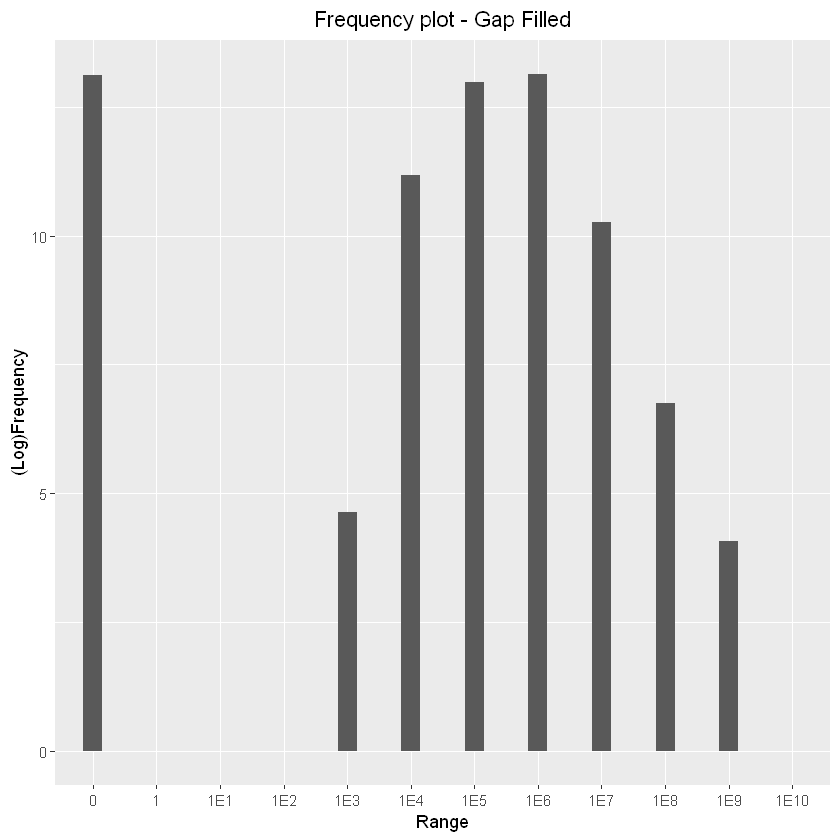

In [57]:
#creating bins from -1 to 10^10 using sequence function seq()
bins <- c(-1,0,(1 * 10^(seq(0,10,1)))) 

#cut function cuts the give table into its appropriate bins
scores_gapfilled <- cut(as.matrix(blk_rem),bins, labels = c('0','1',paste("1E",1:10,sep="")))

#transform function convert the tables into a column format: easy for visualization
FreqTable <- transform(table(scores_gapfilled)) #contains 2 columns: "scores_x1", "Freq"
FreqTable$Log_Freq <- log(FreqTable$Freq+1) #Log scaling the frequency values
colnames(FreqTable)[1] <- 'Range_Bins' #changing the 1st colname to 'Range Bins'

## GGPLOT2
ggplot(FreqTable, aes(x=Range_Bins, y=Log_Freq)) + 
    geom_bar(stat = "identity", position = "dodge", width=0.3) + 
    ggtitle(label = "Frequency plot - Gap Filled") +
    xlab("Range") + 
    ylab("(Log)Frequency") + 
    theme(plot.title = element_text(hjust = 0.5))

Cutoff_LOD <- round(min(blk_rem[blk_rem > 0]))
print(paste0("The limit of detection (LOD) is: ",Cutoff_LOD)) 

The above histogram shows that, in our, blank-removed feature table, there are many zeros present. And no values in the range between 0 to 1E2. The minimum value greater than 0 in our dataframe is in between 1E2 & 1E3 (and that value is 892).

### <font color ='darkblue'> Step 23: Random Value Generation & Zero replacement </font>

In [228]:
set.seed(141222) # by setting a seed, we generate the same set of random number all the time

imp <- blk_rem

for (i in 1:ncol(imp)) {
  imp[,i] <- ifelse(imp[,i] == 0, 
                     round(runif(nrow(imp), min = 1, max = Cutoff_LOD), 1),
                     imp[,i])
}

In [229]:
sum(imp==0) # checking if there are any zeros in our imputed table 

[1] 0

In [60]:
write.csv(imp,paste0(Sys.Date(),'_Imputed_QuantTable.csv'),row.names =T)

---
## Normalization
<a name="norm"></a>

Normalization is performed to compensate for differences in total metabolite concentrations among samples (Y. Wu & Li,2016). Many normalization techniques can also correct the batch effects, such as those caused by sample pipetting or extraction. Here, we present 2 types of normalization: Total Ion Current(TIC) or (Probabilistic Quotient Normalization) PQN.

### <font color ='darkblue'> Step 25: Total Ion Current (TIC) or sample-centric normalization </font>
<a name="tic"></a>

<p style='text-align: justify;'> TIC is a simple normalization technique that is commonly used as it is easy to implement and computationally inexpensive. It scales the intensities of all features in a sample by the total ion current (or sum) of the sample. TIC normalization is appropriate when the amount of sample injected into the instrument is not consistent across all samples, and when the differences in the total ion count among samples are mainly due to differences in the amount of sample injected or instrument sensitivity. However, TIC has its limitation such as few features with high ion observation can heavily influence the calculation. Also it assumes most metabolites are stable and equally up/down-regulated among samples, which does not hold true in many cases like normal vs cancerous tissues comparison. </p>

In [231]:
norm_TIC <- normalization(imp, #performing normalization on transformed imputed data
                            method = "sum")$newXtrain #here, samples are normalized to the sum of the absolute value of all variables for a given sample
head(norm_TIC,n=3)
dim(norm_TIC)
print(paste('No.of NA values in Normalized data:',sum(is.na(norm_TIC)== T)))

,X10015_282.169_2.763_NA,X10035_325.139_2.817_NA,X10037_216.123_2.847_NA,X10047_338.159_2.845_NA,X10058_280.117_2.961_NA,X10059_414.175_2.851_NA,X10082_309.144_2.886_NA,X10095_388.254_2.791_NA,X10097_302.206_2.849_NA,X10138_310.128_2.885_NA,...,X9833_268.175_2.821_NA,X9860_240.144_2.824_NA,X9876_414.139_2.761_NA,X9884_190.05_2.832_NA,X9897_333.144_2.881_NA,X9909_400.16_2.813_NA,X9918_252.123_2.833_NA,X9957_402.139_3.01_NA,X9972_323.123_2.716_NA,X9995_276.159_2.805_NA
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SD_01-2018_1_a.mzXML,3.138358e-05,1.208346e-04,5.577938e-05,0.0002752943,0.0001126659,7.471541e-05,1.464132e-07,3.129066e-06,2.788529e-06,0.0004578069,...,6.710612e-05,2.694077e-04,5.608889e-05,7.037464e-05,4.555242e-05,1.516135e-04,0.0002758770,0.0005314119,0.0001227505,7.873754e-05
SD_01-2018_1_b.mzXML,3.176962e-05,6.148992e-05,2.541851e-04,0.0001476105,0.0001693018,1.247263e-04,2.812791e-04,1.977429e-07,9.739573e-06,0.0004878784,...,3.215998e-05,3.520312e-04,3.207002e-04,6.146824e-05,8.632557e-05,8.954146e-05,0.0004989837,0.0004800784,0.0001257961,1.724150e-04
SD_01-2018_10_a.mzXML,7.938228e-05,1.052125e-04,3.796210e-05,0.0002490783,0.0004774849,1.003526e-04,1.402134e-04,3.565478e-07,4.640074e-06,0.0006455357,...,4.334026e-06,1.262380e-07,8.907199e-04,2.949851e-05,8.616279e-05,9.876150e-04,0.0008045237,0.0000753583,0.0006944178,2.794134e-04


[1]  180 8575

[1] "No.of NA values in Normalized data: 0"


In [64]:
write.csv(norm_TIC, paste0(Sys.Date(),'_TIC_Normalised_table.csv'),row.names =T)

### <font color ='darkblue'> Step 26: Probabilistic Quotient Normalization (PQN) </font>
<a name="pqn"></a>

PQN is a statistical method that aims to correct for technical variability in MS-based metabolomics data. The goal of PQN is to adjust for systematic variation between samples while preserving the relative differences in metabolite levels between samples.

PQN involves a four-step process:

1) TIC normalization: Each spectrum is divided by its TIC to adjust for differences in the total signal intensity between samples.
2) Control spectrum calculation: A control spectrum representing the typical profile of metabolite levels across all samplesis calculated. This can be a median spectrum from all samples.
3) Quotient calculation: For each metabolite feature, the ratio (quotient) of the TIC-normalized intensity of the sample to the control spectrum is calculated.
4) Median normalization: The final normalized value for each feature is the median of all the quotients calculated in step 3.

By using the median of the quotients, PQN reduces the impact of any individual features with extremely high or low values that might skew the normalization.

In [232]:
norm_pqn <- normalization(imp, 
                            method = "pqn")$newXtrain
head(norm_pqn,n=3)
dim(norm_pqn)
print(paste('No.of NA values in Normalized data:',sum(is.na(norm_pqn)== T)))

,X10015_282.169_2.763_NA,X10035_325.139_2.817_NA,X10037_216.123_2.847_NA,X10047_338.159_2.845_NA,X10058_280.117_2.961_NA,X10059_414.175_2.851_NA,X10082_309.144_2.886_NA,X10095_388.254_2.791_NA,X10097_302.206_2.849_NA,X10138_310.128_2.885_NA,...,X9833_268.175_2.821_NA,X9860_240.144_2.824_NA,X9876_414.139_2.761_NA,X9884_190.05_2.832_NA,X9897_333.144_2.881_NA,X9909_400.16_2.813_NA,X9918_252.123_2.833_NA,X9957_402.139_3.01_NA,X9972_323.123_2.716_NA,X9995_276.159_2.805_NA
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SD_01-2018_1_a.mzXML,3.162871e-05,1.217784e-04,5.621505e-05,0.0002774445,0.0001135459,7.529898e-05,1.475568e-07,3.153506e-06,2.810309e-06,0.0004613826,...,6.763026e-05,2.715120e-04,5.652698e-05,7.092431e-05,4.590821e-05,1.527977e-04,0.0002780317,5.355625e-04,0.0001237093,7.935252e-05
SD_01-2018_1_b.mzXML,3.244321e-05,6.279365e-05,2.595744e-04,0.0001507402,0.0001728914,1.273708e-04,2.872428e-04,2.019355e-07,9.946074e-06,0.0004982226,...,3.284184e-05,3.594950e-04,3.274997e-04,6.277151e-05,8.815587e-05,9.143995e-05,0.0005095633,4.902571e-04,0.0001284633,1.760706e-04
SD_01-2018_10_a.mzXML,7.241581e-05,9.597921e-05,3.463061e-05,0.0002272195,0.0004355816,9.154581e-05,1.279085e-04,3.252577e-07,4.232868e-06,0.0005888844,...,3.953678e-06,1.151595e-07,8.125517e-04,2.690977e-05,7.860127e-05,9.009434e-04,0.0007339199,6.874497e-05,0.0006334767,2.548925e-04


[1]  180 8575

[1] "No.of NA values in Normalized data: 0"


In [66]:
write.csv(norm_pqn, paste0(Sys.Date(),'_PQN_Normalised_Quant_table.csv'),row.names =T)

---
## Scaling
<a name='scaling'></a>

One can also perform center-scaling after imputation. Scaling is typically done to make sure that the data is centered around 0 and has a consistent spread to adjust for differences in offset between high and low-abundant metabolites, thus leaving only relevant variation for analysis. 

In [233]:
imp <- imp[match(md_Samples$filename,rownames(imp)),] # ordering the rows in the imp table according to the order of filenames column of md_Samples
identical(rownames(imp),md_Samples$filename) #should return TRUE

[1] TRUE

When <b>center = TRUE</b>, then centering is done by subtracting the column means (omitting NAs) of x from their corresponding columns. No centering is done for <b>center=FALSE</b>.

* If scale = TRUE, center=TRUE,  then scaling is performed by dividing the centered columns of x by their standard deviations.
* If scale = TRUE, center=FALSE, then scaling is performed by dividing the columns of x by their root mean squares
* If scale is FALSE, no scaling is done.

### <font color ='darkblue'> Step 27: Center-Scaling </font>

In [234]:
Imp_s <- scale(imp, center = T, scale = T) # center and scale data
head(Imp_s, n=2)

,X10015_282.169_2.763_NA,X10035_325.139_2.817_NA,X10037_216.123_2.847_NA,X10047_338.159_2.845_NA,X10058_280.117_2.961_NA,X10059_414.175_2.851_NA,X10082_309.144_2.886_NA,X10095_388.254_2.791_NA,X10097_302.206_2.849_NA,X10138_310.128_2.885_NA,...,X9833_268.175_2.821_NA,X9860_240.144_2.824_NA,X9876_414.139_2.761_NA,X9884_190.05_2.832_NA,X9897_333.144_2.881_NA,X9909_400.16_2.813_NA,X9918_252.123_2.833_NA,X9957_402.139_3.01_NA,X9972_323.123_2.716_NA,X9995_276.159_2.805_NA
SD_01-2018_1_a.mzXML,-1.130474,-0.2996814,-0.1117478,2.2186171,-1.452146,-0.1758564,-0.98669131,-0.2001378,-0.2847596,2.007861,...,0.50939531,0.3411232,-0.9690079,-0.2136802,-1.0317304,-0.3098083,-0.177995,1.167922,-0.9536029,-0.720866221
SD_01-2018_1_b.mzXML,-1.126516,-0.6037285,1.9885974,0.2986375,-1.028317,0.3848962,0.01064872,-0.2193145,-0.1910732,2.249940,...,0.09223042,0.5325915,1.0516269,-0.3039294,-0.1930184,-0.7478302,1.252001,0.955153,-0.9361819,-0.008649493


In [69]:
write.csv(Imp_s, paste0(Sys.Date(),'_scaled_table.csv'),row.names =T)

### <font color ='darkblue'> Step 28: Choose data for further analysis </font>

In [245]:
# Display the data choices to the user
cleaned_data_choice <- data.frame(
  INDEX = 1:6, 
  Description = c("Raw data", "Blank removed data", "Imputed data", "TIC Normalized", "PQN Normalized", "Scaled"),
  Variable = c("ft_t", "blk_rem", "imp", "norm_TIC", "norm_pqn", "Imp_s")
)

display(cleaned_data_choice)

cleaned_data_str <- as.numeric(readline('Enter the index number of the dataframe to use for further analysis: ')) # Get the user's selection
selected_variable <- cleaned_data_choice$Variable[cleaned_data_str] # Retrieve the variable name corresponding to the user's choice
cleaned_data <- get(selected_variable) # Use the 'get' function to retrieve the value of the selected variable

INDEX,Description,Variable
<int>,<chr>,<chr>
1,Raw data,ft_t
2,Blank removed data,blk_rem
3,Imputed data,imp
4,TIC Normalized,norm_TIC
5,PQN Normalized,norm_pqn
6,Scaled,Imp_s


Enter the index number of the dataframe to use for further analysis:  6


In [246]:
head(cleaned_data, 2)

,X10015_282.169_2.763_NA,X10035_325.139_2.817_NA,X10037_216.123_2.847_NA,X10047_338.159_2.845_NA,X10058_280.117_2.961_NA,X10059_414.175_2.851_NA,X10082_309.144_2.886_NA,X10095_388.254_2.791_NA,X10097_302.206_2.849_NA,X10138_310.128_2.885_NA,...,X9833_268.175_2.821_NA,X9860_240.144_2.824_NA,X9876_414.139_2.761_NA,X9884_190.05_2.832_NA,X9897_333.144_2.881_NA,X9909_400.16_2.813_NA,X9918_252.123_2.833_NA,X9957_402.139_3.01_NA,X9972_323.123_2.716_NA,X9995_276.159_2.805_NA
SD_01-2018_1_a.mzXML,-1.130474,-0.2996814,-0.1117478,2.2186171,-1.452146,-0.1758564,-0.98669131,-0.2001378,-0.2847596,2.007861,...,0.50939531,0.3411232,-0.9690079,-0.2136802,-1.0317304,-0.3098083,-0.177995,1.167922,-0.9536029,-0.720866221
SD_01-2018_1_b.mzXML,-1.126516,-0.6037285,1.9885974,0.2986375,-1.028317,0.3848962,0.01064872,-0.2193145,-0.1910732,2.249940,...,0.09223042,0.5325915,1.0516269,-0.3039294,-0.1930184,-0.7478302,1.252001,0.955153,-0.9361819,-0.008649493


---
# <font color ='blue'> 4. Multivariate analysis </font>
<a name="multi"></a>

### <font color ='darkblue'> Step 28: Install Packages for Multivariate Analyses </font>

To start our multivariate analysis, we first install and load the necessary R packages for this section: "BiocManager", "ComplexHeatmap", "ggsci", "dendextend", and "NbClust".

<font color="red" size =4> Initial installation of the packages will take about 10-15 mins !!</font>

In [165]:
pacman::p_load("BiocManager","ComplexHeatmap","ggsci","dendextend","NbClust")

## PCoA PERMANOVA
<a name = 'pcoa'></a>

<p style='text-align: justify;'> Principal coordinates analysis (PCoA) is a metric multidimensional scaling (MDS) method that attempts to represent sample dissimilarities in a low-dimensional space. It converts a distance matrix consisting of pair-wise distances (dissimilarities) across samples into a 2- or 3-D graph. <a href="https://onlinelibrary.wiley.com/doi/10.1002/0470011815.b2a13070">(Gower, 2005)</a></p>
    
<p style='text-align: justify;'> Different distance metrics can be used to calculate dissimilarities among samples (e.g. Euclidean, Canberra, Minkowski). Performing a principal coordinates analysis using the Euclidean distance metric is the same as performing a principal components analysis (PCA). The selection of the most appropriate metric depends on the nature of your data and assumptions made by the metric.</p>

<p style='text-align: justify;'> Within the metabolomics field the Euclidean, Bray-Curtis, Jaccard or Canberra distances are most commonly used. The Jaccard distance is an unweighted metric (presence/absence) whereas Euclidean, Bray-Curtis and Canberra distances take into account relative abundances (weighted). Some metrics may be better suited for very sparse data (with many zeroes) than others. For example, the Euclidean distance metric is not recommended to be used for highly sparse data. </p>

This [video tutorial by StatQuest](https://www.youtube.com/watch?v=GEn-_dAyYME) summarizes nicely the basic principles of PCoA.

### <font color ='darkblue'> Step 29: Prepare Data </font>

In order to perform a PCoA as described below, it is important that the filenames in our metadata are identical as well as in the same order as the filenames in our feature table.

In [248]:
# name rows in metadata after filenames
rownames(md_Samples) <- md_Samples$filename

# how many files in the metadata are also present in the feature table
table(rownames(md_Samples) %in% rownames(cleaned_data))


TRUE 
 180 

In [249]:
cleaned_data <- cleaned_data[match(rownames(md_Samples),rownames(cleaned_data)),] # bring the rows in the feature table and metadata in the same order
identical(rownames(cleaned_data),rownames(md_Samples)) #should return TRUE

[1] TRUE

In [73]:
#looking at the header
head(cleaned_data, 2)
head(cleaned_data, 2)

,X10015_282.169_2.763_NA,X10035_325.139_2.817_NA,X10037_216.123_2.847_NA,X10047_338.159_2.845_NA,X10058_280.117_2.961_NA,X10059_414.175_2.851_NA,X10082_309.144_2.886_NA,X10095_388.254_2.791_NA,X10097_302.206_2.849_NA,X10138_310.128_2.885_NA,...,X9833_268.175_2.821_NA,X9860_240.144_2.824_NA,X9876_414.139_2.761_NA,X9884_190.05_2.832_NA,X9897_333.144_2.881_NA,X9909_400.16_2.813_NA,X9918_252.123_2.833_NA,X9957_402.139_3.01_NA,X9972_323.123_2.716_NA,X9995_276.159_2.805_NA
SD_01-2018_1_a.mzXML,-1.130474,-0.2996814,-0.1117478,2.2186171,-1.452146,-0.1758564,-0.98669140,-0.2001378,-0.2847595,2.007861,...,0.50939531,0.3411232,-0.9690079,-0.2136802,-1.0317304,-0.3098083,-0.177995,1.167922,-0.9536029,-0.720866222
SD_01-2018_1_b.mzXML,-1.126516,-0.6037285,1.9885974,0.2986375,-1.028317,0.3848962,0.01064872,-0.2193144,-0.1910732,2.249940,...,0.09223042,0.5325915,1.0516269,-0.3039294,-0.1930184,-0.7478302,1.252001,0.955153,-0.9361819,-0.008649493


,filename,ATTRIBUTE_Sample_Type,ATTRIBUTE_Batch,ATTRIBUTE_Month,ATTRIBUTE_Year,ATTRIBUTE_Sample_Location,ATTRIBUTE_Replicate,ATTRIBUTE_Spot,ATTRIBUTE_Latitude,ATTRIBUTE_Longitude,ATTRIBUTE_Sample_Area,ATTRIBUTE_Spot_Name,ATTRIBUTE_time_run,ATTRIBUTE_Injection_order
,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>
SD_01-2018_1_a.mzXML,SD_01-2018_1_a.mzXML,Sample,2,Jan,2018,1,a,1,32.93365,-117.2648,Torrey_Pines,Lagoon_Outlet,16/01/2018 11:36,65
SD_01-2018_1_b.mzXML,SD_01-2018_1_b.mzXML,Sample,2,Jan,2018,1,b,1,32.93365,-117.2648,Torrey_Pines,Lagoon_Outlet,16/01/2018 11:52,66


### <font color ='darkblue'> Step 30: Calculate Pairwise Distances </font>

Then, we will calculate pairwise distances across all samples in our centered data using the Euclidean distance metric

In [250]:
distm <- vegdist(cleaned_data, method = "euclidean") #compute distance

All pairwise Euclidean distances are now stored within our distance (dissimilarity) matrix (distm). The distance matrix is then used as input for the PCoA.

### <font color ='darkblue'> Step 31: Perform PCoA</font>

In [251]:
#computing multi-dimensional scaling on distance matrix
PcoA <- cmdscale(distm, 
                 k = 10, # k=10 gets the first 10 Principal coordinates or PCOs
                 eig = T, 
                 add = T)

PcoA_points <- as.data.frame(PcoA$points) #getting the PCOs into dataframe
variance <- round(PcoA$eig*100/sum(PcoA$eig),1) # getting the variance explained by each PCo
names(PcoA_points)[1:10] <- paste0('PCoA', seq(1,10))  #naming the 10 PCos

### <font color ='darkblue'> Step 32: Analyze PCoA Results </font>

‘PcoA_points’ (PcoA$points) represents the data matrix with the given PCos

In [252]:
head(PcoA_points,2) # looking at the 10 PCOs

,PCoA1,PCoA2,PCoA3,PCoA4,PCoA5,PCoA6,PCoA7,PCoA8,PCoA9,PCoA10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SD_01-2018_1_a.mzXML,-50.90443,11.70013,-20.64781,-15.1077,9.065648,45.09336,-3.452227,20.68098,27.25021,-7.934234
SD_01-2018_1_b.mzXML,-50.73427,13.87079,-19.52786,-15.6320,10.299270,44.71925,-3.828775,18.17167,28.12831,-8.023183


In [78]:
identical(rownames(PcoA_points), rownames(md_Samples))

[1] TRUE

### <font color ='darkblue'> Step 33: Plot PCoA Scores </font>

Using the ggplot2 library, we can plot our PCoA with the Euclidean distance (which is equal to PCA).  At first, we here color samples according to the month of the year the samples were retrieved (ATTRIBUTE_Month): `Interested_attribute = md_Samples$ATTRIBUTE_Month`

In [259]:
Interested_attribute = md_Samples$ATTRIBUTE_Month #change the attribute here according to your metadata

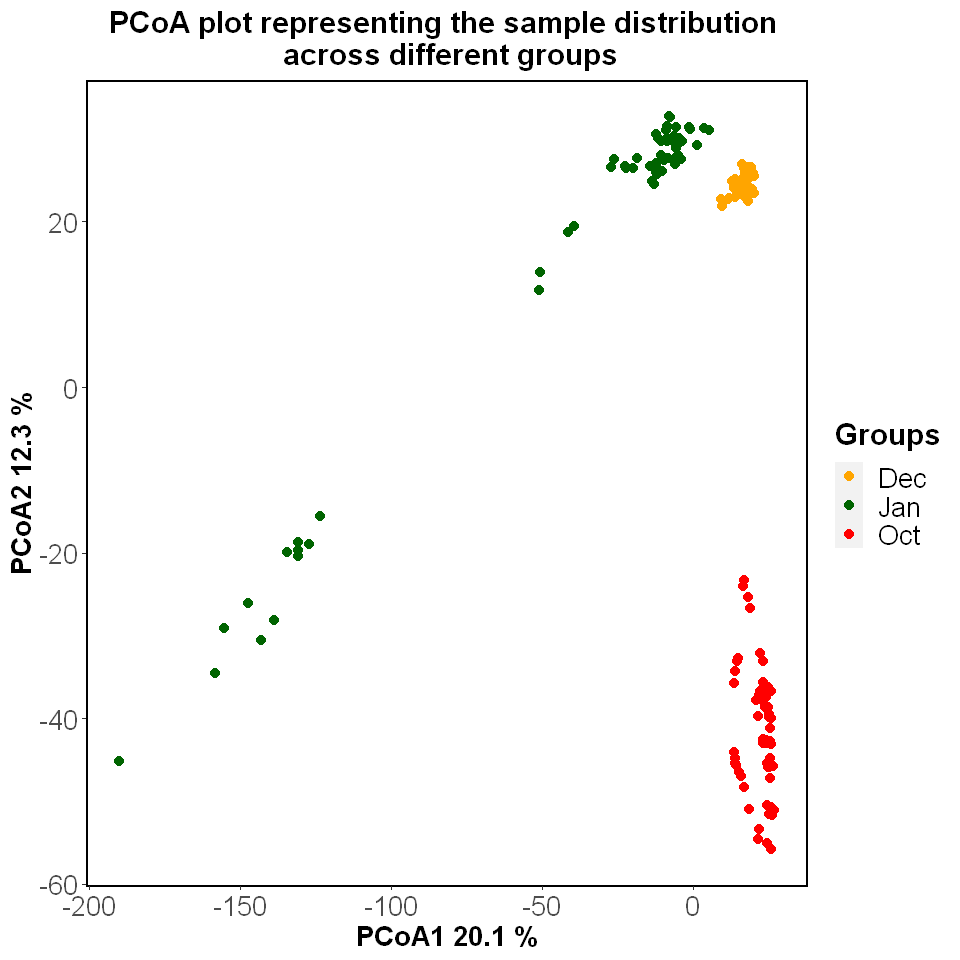

In [260]:
options(repr.plot.width=8, repr.plot.height=8, res=600) # changing the output plot size

ggplot(PcoA_points, 
       aes(x = PCoA1, # PCo1 as x-axis
           y = PCoA2, # PCo1 as y-axis
           colour = Interested_attribute, #coloring the scores using ATTRIBUTE_Month
           label = row.names(PcoA))) +
 geom_point(size=2.5) +
 scale_colour_manual(values = c('orange','darkgreen','red','blue','black')) +
 xlab(paste('PCoA1',variance[1],'%', sep = ' ')) + #variance explained by PCo1 as x-axis
 ylab(paste('PCoA2',variance[2],'%', sep = ' ')) + #variance explained by PCo2 as y-axis
 labs(title="PCoA plot representing the sample distribution \n across different groups", 
      color = 'Groups') +
 theme(axis.text = element_text(size = 16),
       axis.title = element_text(size = 16, face= 'bold'),
       plot.title = element_text(size = 18, face= 'bold',hjust=0.5),
       legend.title = element_text(size = 18, face= 'bold'),
       legend.text = element_text(size = 16),
       panel.background = element_blank(),
       panel.border = element_rect(colour = "black", fill=NA, linewidth=1)) 

<p style='text-align: justify;'> It looks like there is a strong separation between the chemotypes of seawater sampled during different months. But is the separation significant? Let's perform a permutational multivariate analysis of variance (PERMANOVA) to find out! </p>

### PERMANOVA

<p style='text-align: justify;'> Permutational multivariate analysis of variance (PERMANOVA) is a non-parametric method for multivariate ANOVA, where P-values are obtained using permutations. The metric was originally developed within the field of ecology <a href ='https://onlinelibrary.wiley.com/doi/full/10.1002/9781118445112.stat07841'>(Anderson, 2008)</a> but is today widely used in other fields, including the microbiome and metabolomics field. PERMANOVA is used to compare groups of samples and it tests whether the centroid and/or the spread of the samples is different among the groups. Here, H0 states no differences among the groups and it is rejected when there is a significance difference among the groups. </p>

### <font color ='darkblue'> Step 34: Conduct PERMANOVA Test </font>

<p style='text-align: justify;'> The adonis2() function in the <a href ='https://cran.r-project.org/web/packages/vegan/index.html'>(vegan package)</a> can be used to perform a PERMANOVA. The input is any dissimilarity matrix and the test-statistic retrieved is a multivariate analogue to Fisher's F-ratio as well as an R2 value (Adonis R2). </p>

In [264]:
unique(Interested_attribute)

[1] "Jan" "Oct" "Dec"

In [265]:
adonres <- adonis2(distm ~ Interested_attribute)
adonres

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Interested_attribute,2,364194.6,0.2372719,27.53087,0.001
Residual,177,1170730.4,0.7627281,NA,NA
Total,179,1534925.0,1.0000000,NA,NA


<p style='text-align: justify;'> The PERMANOVA test result tells us that there is a significant difference in the metabolomic profiles of seawater sampled during different months (PERMANOVA, P < 0.05, Adonis R2 = 0.2367) and that app. 23% of the variation in our data can be explained by month of sampling. As we already could clearly observe in the PCoA plot, this means that there are strong differences between the chemotypes of seawater sampled during different months. </p>

### Perform PCoA and assess separation using PERMANOVA

### <font color ='darkblue'> Step 35: Define a Function for Streamlined Analysis </font>

<p style='text-align: justify;'> To speed up the analysis and so we don't have to rewrite the entire code when testing different parameters, we can define a function, which will perform a principal coordinates analysis (PCoA) using a distance metric of choice, calculate a PERMANOVA and plot results in a 2-D graph: </p>

In [266]:
plotPCoA <- function(ft, 
                     md, 
                     distmetric = c("bray","euclidean", "maximum", "manhattan","canberra", "binary", "minkowski"), 
                     collow = "#810f7c", colhigh ="#f7fcb9", catper = "plate", 
                     catcols = "plate", mdtype = 'categorical', 
                     cols = c('grey','black','orange','pink','darkgreen','darkred','brown','blue','skyblue3','green'),
                     title = 'Principal coordinates plot'){
    
    catper <<- catper
    distm <- vegdist(ft, method = distmetric)
    d <- as.matrix(distm)

    #Calculation perMANOVA
    if (length(which(is.na(md[,colnames(md) == catper]))) !=0){
          red <- as.dist(as.matrix(distm)[-which(is.na(md[,colnames(md) == catper])),-which(is.na(md[,colnames(md) == catper]))])
          adonres <- adonis2(red ~ na.omit(md[,colnames(md) == catper]))
          Rsq <- adonres$R2[1]
          pval <- adonres$'Pr(>F)'[1]
        } else {
          adonres <- adonis2(distm ~ md[,colnames(md) == catper])
          Rsq <- adonres$R2[1]
          pval <- adonres$'Pr(>F)'[1]
        }


   #computing multi-dimensional scaling on distance matrix
    PcoA <- cmdscale(distm, k =10, eig = T, add = T) # k=10 gets the first 10 Principal coordinates or PCOs
    PcoA_points <- as.data.frame(PcoA$points) #getting the PCOs into dataframe
    variance <- round(PcoA$eig*100/sum(PcoA$eig),1) # getting the variance explained by each PCo
    names(PcoA_points)[1:10] <- paste0('PCoA', seq(1,10))  #naming the 10 PCos
    PcoA_points$Group <- md[,colnames(md) == catcols][match(rownames(PcoA_points),rownames(md))]
    
    # plot
    cbPalette <- cols

    if (mdtype == 'continuous'){
        Tr_PcoA <- ggplot(PcoA_points, # plot on PCoA_points dataframe
                            aes(x = PCoA1, y = PCoA2, colour = Group, label = row.names(PcoA))) +
        geom_point(size=2.5) +
        scale_colour_gradient(low = collow, high = colhigh, space = "Lab", na.value = "grey50", guide = "colourbar", aesthetics = "colour") + 
        xlab(paste('PCoA1',variance[1],'%', sep = ' ')) +
        ylab(paste('PCoA2',variance[2],'%', sep = ' ')) +
        ggtitle(paste(title,paste0("(p=",round(pval,4),","),paste0("adonis-R2=",round(Rsq,4),")"),sep=" ")) +
        theme(axis.text = element_text(size = 16),
              axis.title = element_text(size = 16, face= 'bold'),
              plot.title = element_text(size = 18, face= 'bold',hjust=0.5),
              legend.title = element_text(size = 18, face= 'bold'),
              legend.text = element_text(size = 16),
              panel.background = element_blank(),
              panel.border = element_rect(colour = "black", fill=NA, linewidth=1)) 

        } else {
        Tr_PcoA <- ggplot(PcoA_points, 
                          aes(x = PCoA1, y = PCoA2, colour = Group, label = row.names(PcoA))) + 
        geom_point(size=2.5) +
        scale_colour_manual(values = cbPalette) +
        xlab(paste('PCoA1',variance[1],'%', sep = ' ')) +
        ylab(paste('PCoA2',variance[2],'%', sep = ' ')) +
        ggtitle(paste(title,paste0("(p=",round(pval,4),","),paste0("adonis-R2=",round(Rsq,4),")"),sep=" ")) +
        theme(axis.text = element_text(size = 16),
              axis.title = element_text(size = 16, face= 'bold'),
              plot.title = element_text(size = 18, face= 'bold',hjust=0.5),
              legend.title = element_text(size = 18, face= 'bold'),
              legend.text = element_text(size = 16),
              panel.background = element_blank(),
              panel.border = element_rect(colour = "black", fill=NA, linewidth=1)) 
        }
    
    print(Tr_PcoA)
}

<font size=3> **Parameters to define when using the plotPCoA function:**</font><br>
By defining different parameters within the plotPCoA function, we can quickly draw the same PCoA plot as above and retrieve PERMANOVA test results at the same time. <br>

- **distmetric:** A distance metric of your choice, including "bray", "euclidean", "maximum", "manhattan","canberra", "binary", or "minkowski".
- **catper:** How should the samples be grouped for PERMANOVA, this can be any column name of your metadata.
- **catcols:** According to what groups should the samples be colored on the PCoA, this can be any column name of your metadata.
- **mdtype: Either 'categorical' or 'continuous'**, this value defines whether a continuous or categorical color scale should be used for the PCoA.
- **cols:** Colors used for plotting the groups in the PCoA. The length of this object should be equal to the number of groups plotted.
- **title:** Any title of your choice you want to give the plot.<br>

<font size =3>**Let's look at our raw data before cleanup:**

In [82]:
# since the plotPCoA function compares the rownames of given feature table and metadata, we make sure to give rownames to new_md
rownames(new_md) <- new_md$filename 

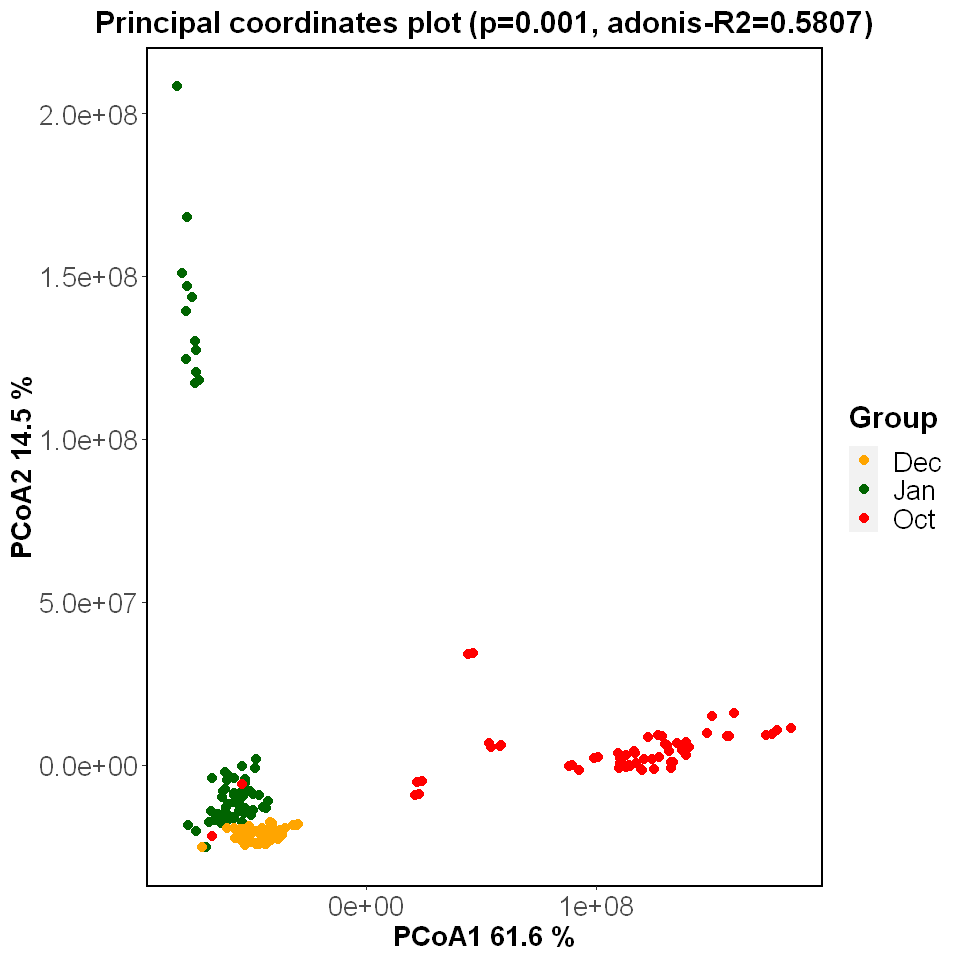

In [267]:
#svglite('PCoA_raw_euclidean_Month.svg', width=10, height=10, bg='white') #uncomment to save as svg plot

plotPCoA(ft_t, # raw data
         new_md, 
         distmetric = "euclidean", #desired distance metric
         catper = "ATTRIBUTE_Month", #desired group for permanova calculation
         catcols = "ATTRIBUTE_Month", #coloring the scores based on this group
         mdtype = 'categorical', 
         cols = c('orange','darkgreen','red','blue','black','grey','purple'),
         title = 'Principal coordinates plot')

#dev.off() #uncomment while saving as svg plot

<b>Tip:</b> To save a plot in SVG or PDF format using the `svglite()` function, you should initiate a plotting device with `svglite()`. Subsequently, execute the plotting command (for instance, `plotPCoA()` for creating a PCoA plot). This process will generate the plot and store it in the specified SVG or PDF file. Don't forget to close the plotting device after the final plot has been created using `dev.off()`.

Looking at the scaled table:

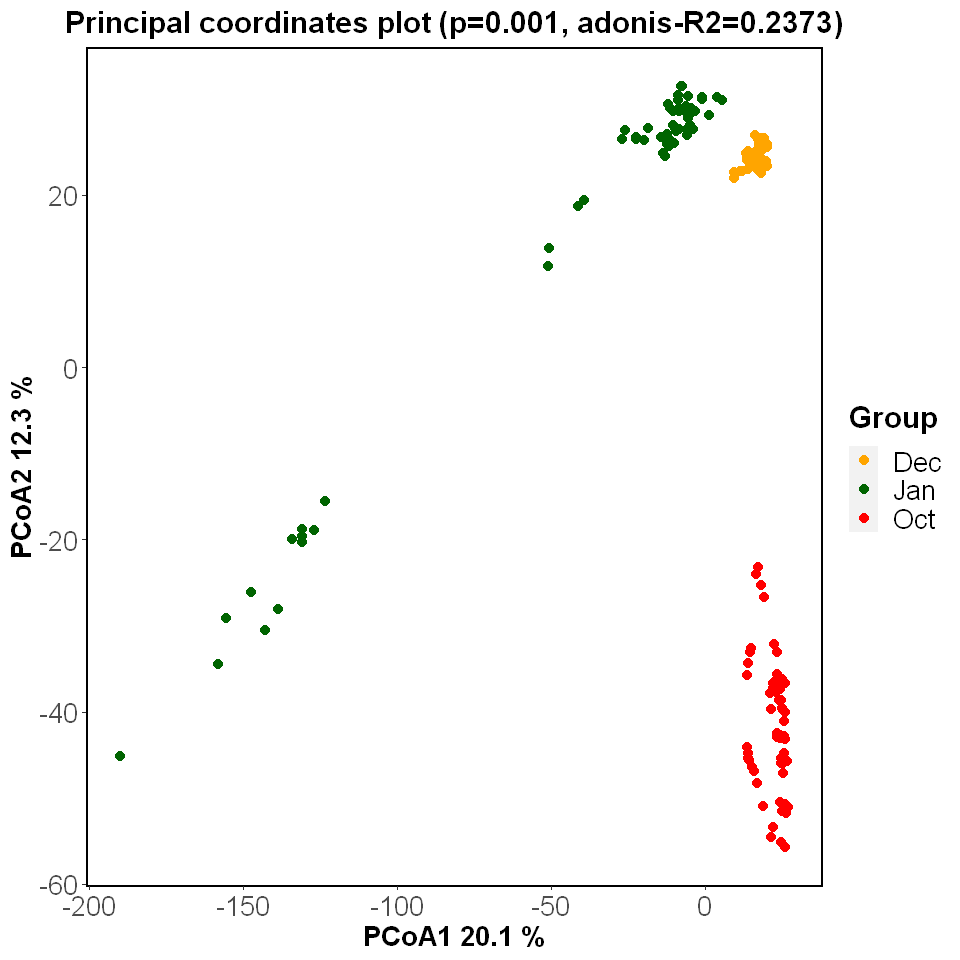

In [268]:
#svglite('PCoA_imputed-scaled_euclidean_Month.svg', width=10, height=10, bg='white') #uncomment to save as svg plot

plotPCoA(cleaned_data, # here cleaned data is scaled data
         md_Samples, #corresponding metadata table
         distmetric = "euclidean", #desired distance metric
         catper = "ATTRIBUTE_Month", #desired group for permanova calculation
         catcols = "ATTRIBUTE_Month", #coloring the scores based on this group
         mdtype = 'categorical', #type of the desired group
         cols = c('orange','darkgreen','red','blue','black'),
         title = 'Principal coordinates plot') #change the title as you prefer

#dev.off() #uncomment while saving as svg plot

We can also test a different distance metric and look at the separation of samples. During data cleanup, we imputed all zero values. However, we can also use different distance metric that can deal better with missing values (e.g. Canberra).  
<br/>
We can also test whether there a significant differences in metabolomic profiles between different sample areas

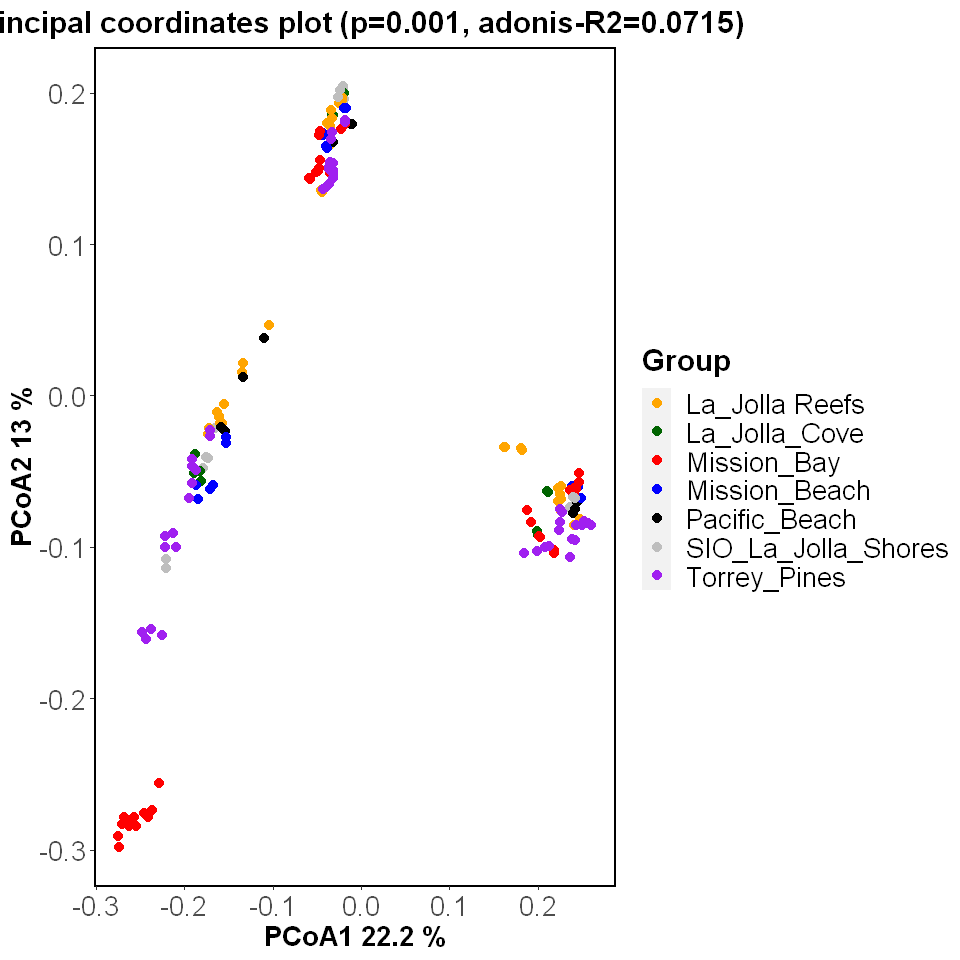

In [269]:
#svglite('PCoA_Imp_Scaled_canberra_SampleArea.svg', width=10, height=10, bg='white') #uncomment to save as svg plot

plotPCoA(cleaned_data, # not-centered, but scaled data
         md_Samples, 
         distmetric = "canberra", #canberra distance is used
         catper = "ATTRIBUTE_Sample_Area", # now a different group is used
         catcols = "ATTRIBUTE_Sample_Area", 
         mdtype = 'categorical', 
         cols = c('orange','darkgreen','red','blue','black','grey','purple'),
         title = 'Principal coordinates plot')

#dev.off() #uncomment while saving as svg plot

The results tell us that there are significant differences in the metabolomic profiles of seawater collected at different sampling areas (PERMANOVA p-value < 0.05). However, the differences are not as strong as the differences observed for month of sampling with only 7% (R2=0.0722) of the variation in the data explained by sampling area. Similarly, the user can use this funcion to compare the before and after effects of datacleanup. For more information, please follow the manuscript.

For example, we can look at the blank removed table here:

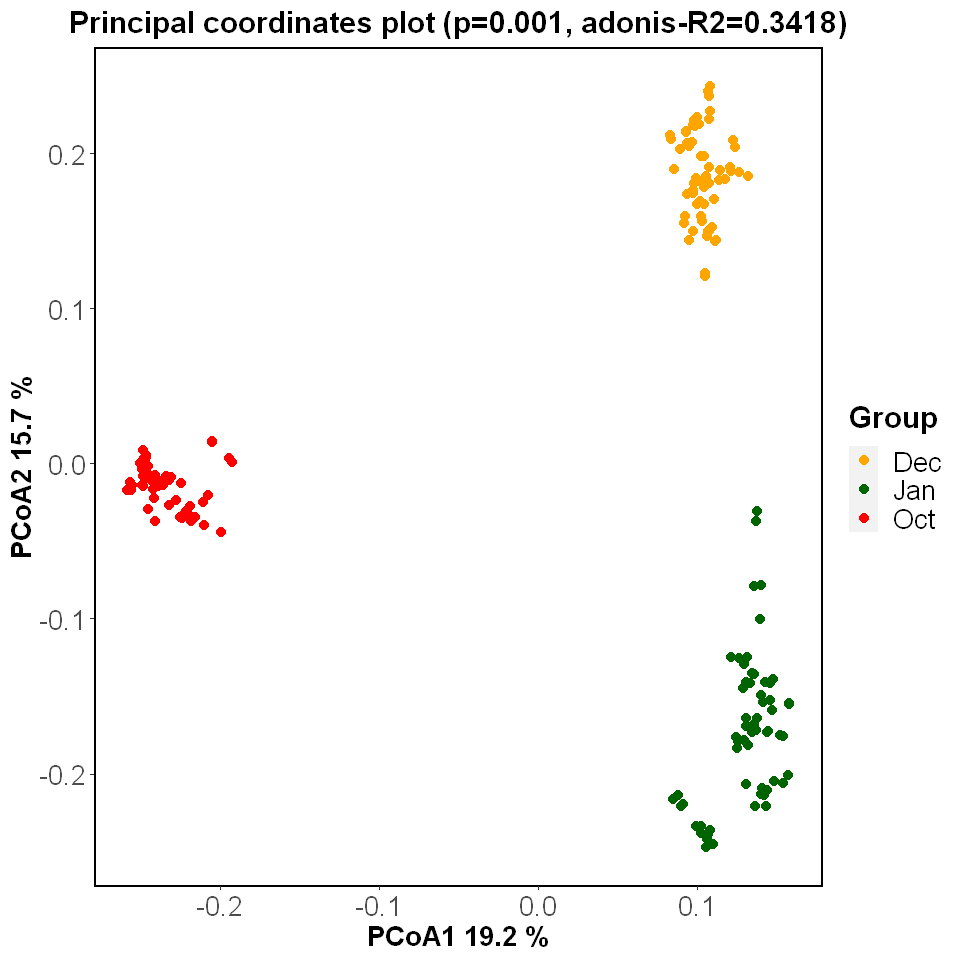

In [270]:
#svglite('PCoA_blanks_removed_canberra_Month.svg', width=10, height=10, bg='white') #uncomment to save as svg plot

plotPCoA(blk_rem, # blank removed data
         md_Samples, 
         distmetric = "canberra", #canberra distance is used
         catper = "ATTRIBUTE_Month", #desired group for permanova calculation
         catcols = "ATTRIBUTE_Month", #coloring the scores based on this group
         mdtype = 'categorical', 
         cols = c('orange','darkgreen','red','blue','black','grey','purple'),
         title = 'Principal coordinates plot')

#dev.off() #uncomment while saving as svg plot

Here, the results shows the significant differences in the metabolomic profiles of seawater collected during different sampling time (p < 0.05). The observed differences helps explain 34.4% (R2=0.344) of the variation in the data.

---
## <font color = 'darkblue'> Hierarchial Clustering Algorithm</font>
<a name="hca"></a>

We can also perform another unsupervised analysis such as a cluster analysis. The concept behind hierarchical clustering algorithm (HCA) is to repeatedly combine the two nearest clusters into a larger cluster.
  
It involves calculating the distance between every pair of observation points and stores it in a matrix.
1. Put every point in its own cluster.
2. Merge the closest pairs of points according to their distances.
3. Recompute the distance between the new cluster and the old ones and stores them in a new distance matrix.
4. Repeat steps 2 and 3 until all the clusters are merged into one single cluster. <br>

<p style='text-align: justify;'> Now, we can proceed to perform HCA. As you can see in the following code, we need to specify the <b>'method'</b> argument. This argument tells the algorithm how to measure the distance between clusters and it's usually referred as <b>'Linkage Method'</b>. There are several methods. <a href="https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/hclust">Explore the different options</a>. Usually, you will try different ones and plot the result.</p>

### <font color ='darkblue'> Step 36: Setting the Plot Size </font>

In [272]:
options(repr.plot.width=25, repr.plot.height=10, res=128) # we are redefining the plot size for dendrograms as these plots have increased width

Here, we use the default 'complete' (i.e. complete-linkage), which calculates the maximum distance between clusters before merging.

### <font color ='darkblue'> Step 37: Executing HCA </font>

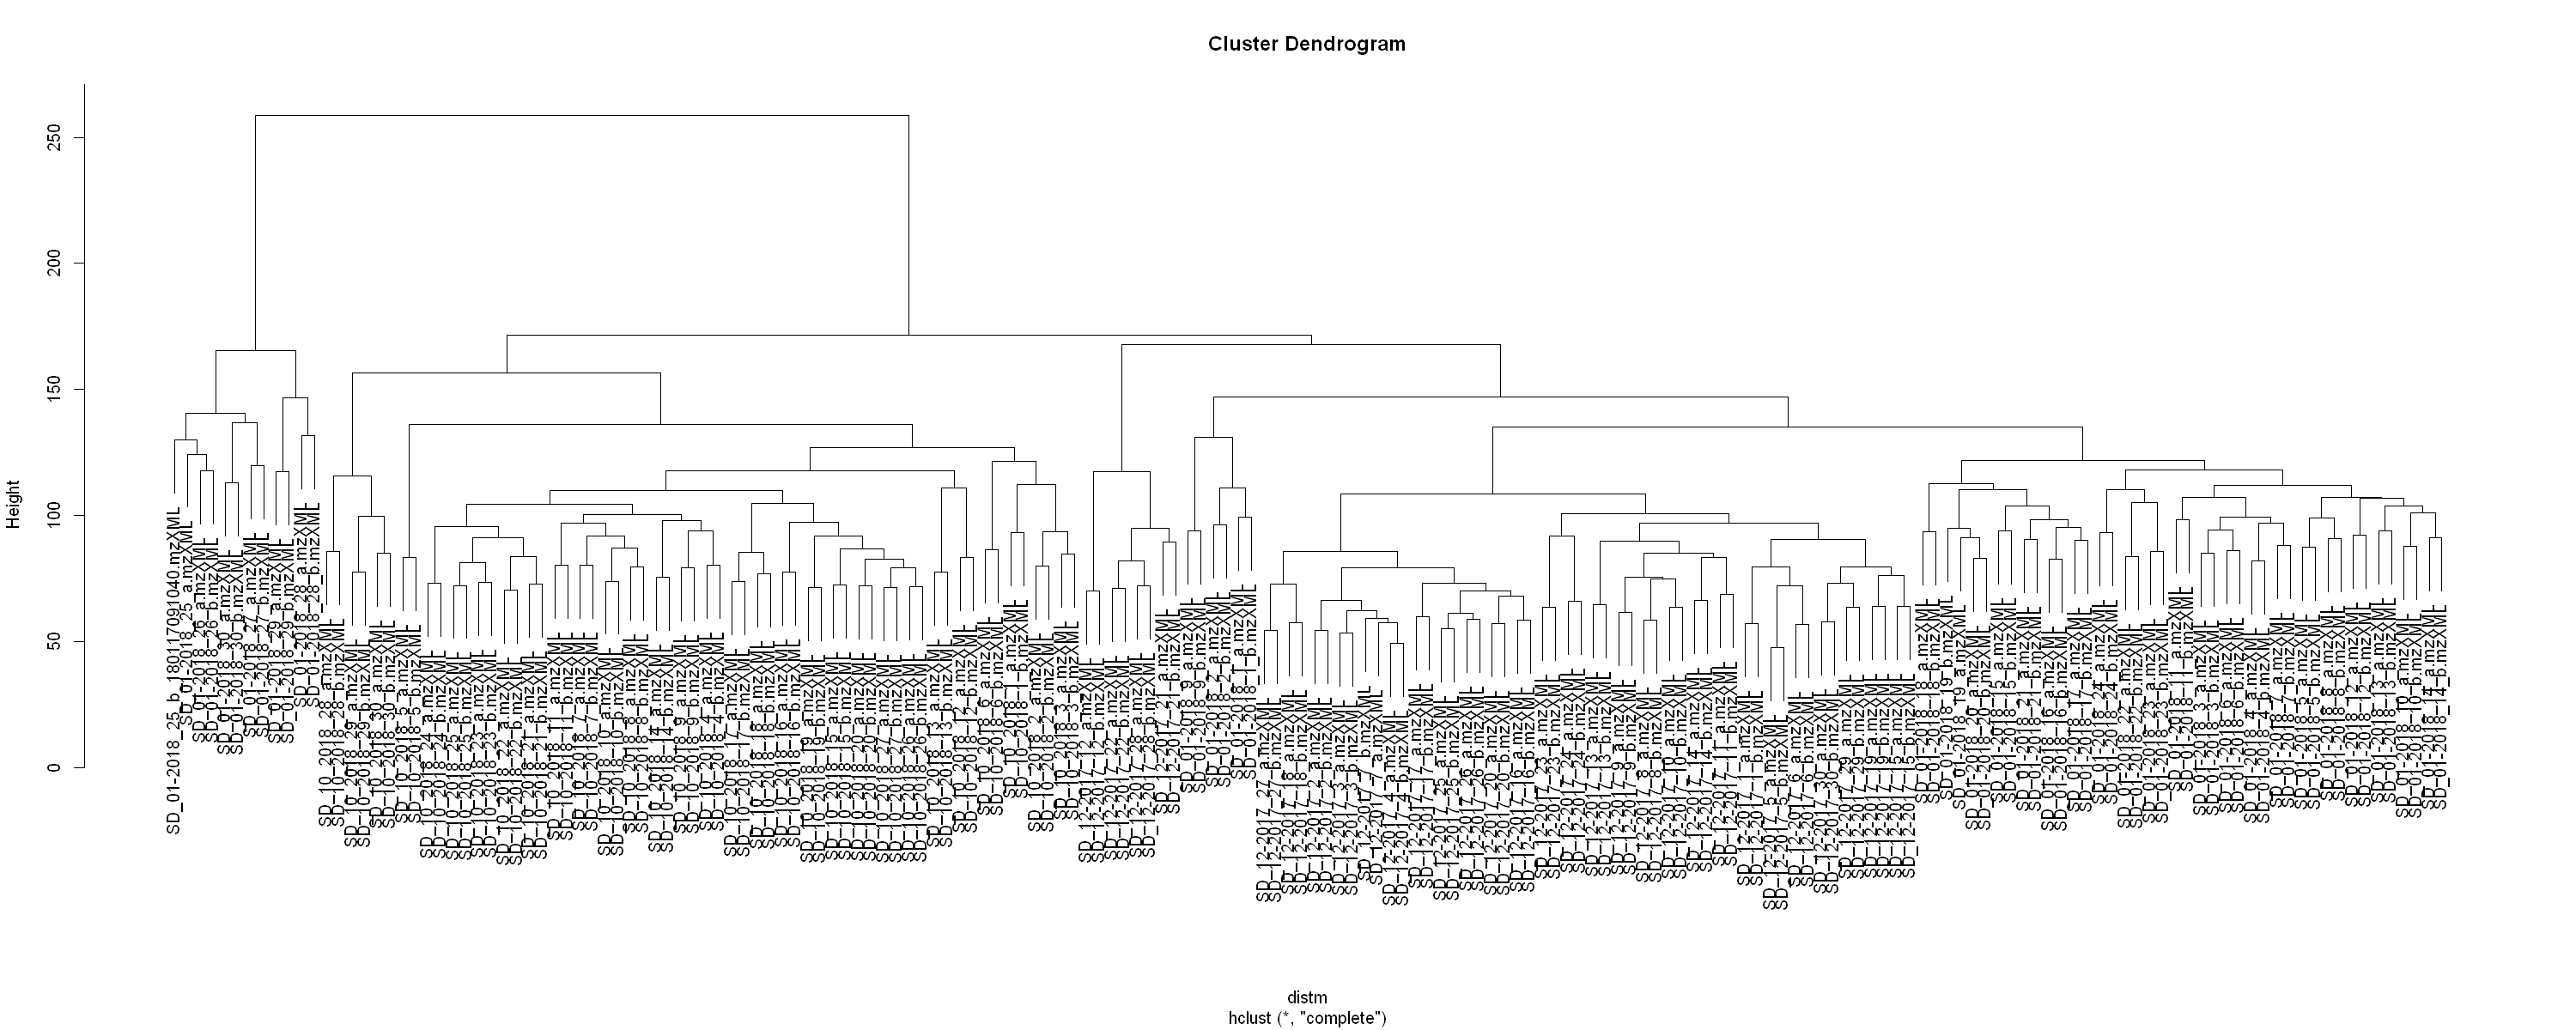

In [273]:
set.seed(1234) # Setting a seed for reproducing the same result
hclust_res <- hclust(distm, method = 'complete')
plot(hclust_res) #visualize the cluster relationships in a tree-like diagram called dendrogram

### <font color ='darkblue'> Step 38: Examining the Dendrogram </font>

Once HCA is completed, a dendrogram is generated. This dendrogram shows split or merge distances as ‘height’ along the y-axis, providing a visual representation of the cluster formation.

### <font color ='darkblue'> Step 39: Cutting the Dendrogram </font>

You can also cut the dendrogram to create the desired number of clusters. In this case, it seems we have 3 main 'splits', further divided into a total of 4 clusters. We are going to use the <a href="https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/cutree">cutree() function</a> for this

In [274]:
cut_res <- cutree(hclust_res, k = 4) # where k indicates the number of clusters we want
head(data.frame(cut_res)) # looking at the header of the cluster assignment

,cut_res
,<int>
SD_01-2018_1_a.mzXML,1
SD_01-2018_1_b.mzXML,1
SD_01-2018_10_a.mzXML,1
SD_01-2018_10_b.mzXML,1
SD_01-2018_11_a.mzXML,1
SD_01-2018_11_b.mzXML,1


In [275]:
# counting the number of samples present in each cluster
table(data.frame(cut_res))


  1   2   3   4 
100  12  60   8 

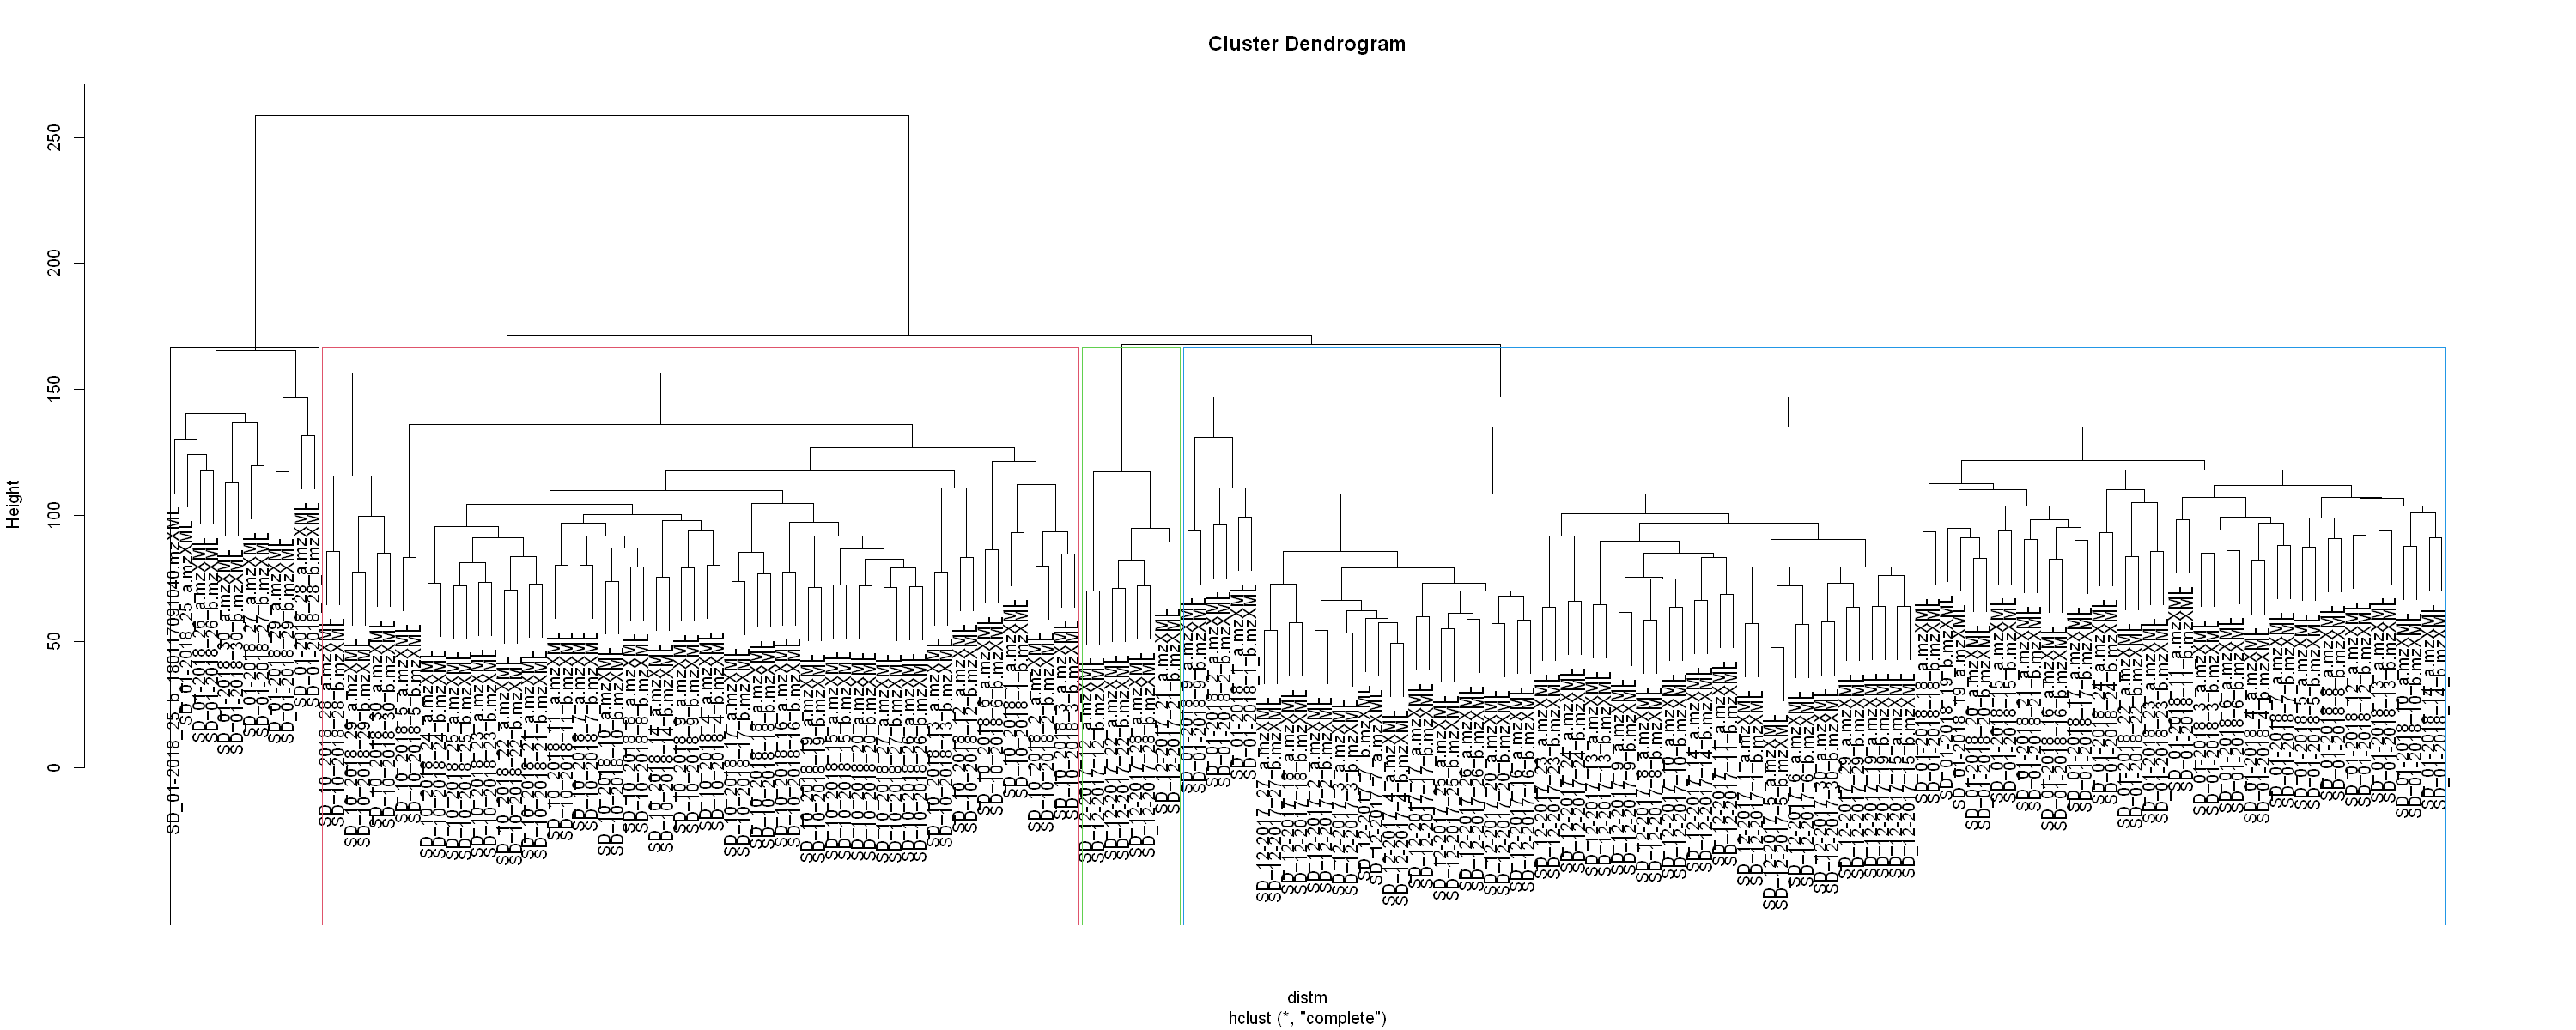

In [276]:
# highlight the clusters in the dendrogram by coloring their borders.
plot(hclust_res)
rect.hclust(hclust_res, k = 4, border = 1:4)

### <font color ='darkblue'> Step 40: Coloring the Dendrogram </font>

Finally, we can extract the cluster allocation information and color the dendrogram according to the clusters. For our data, the dendrogram suggests two main splits, resulting in four distinct clusters.

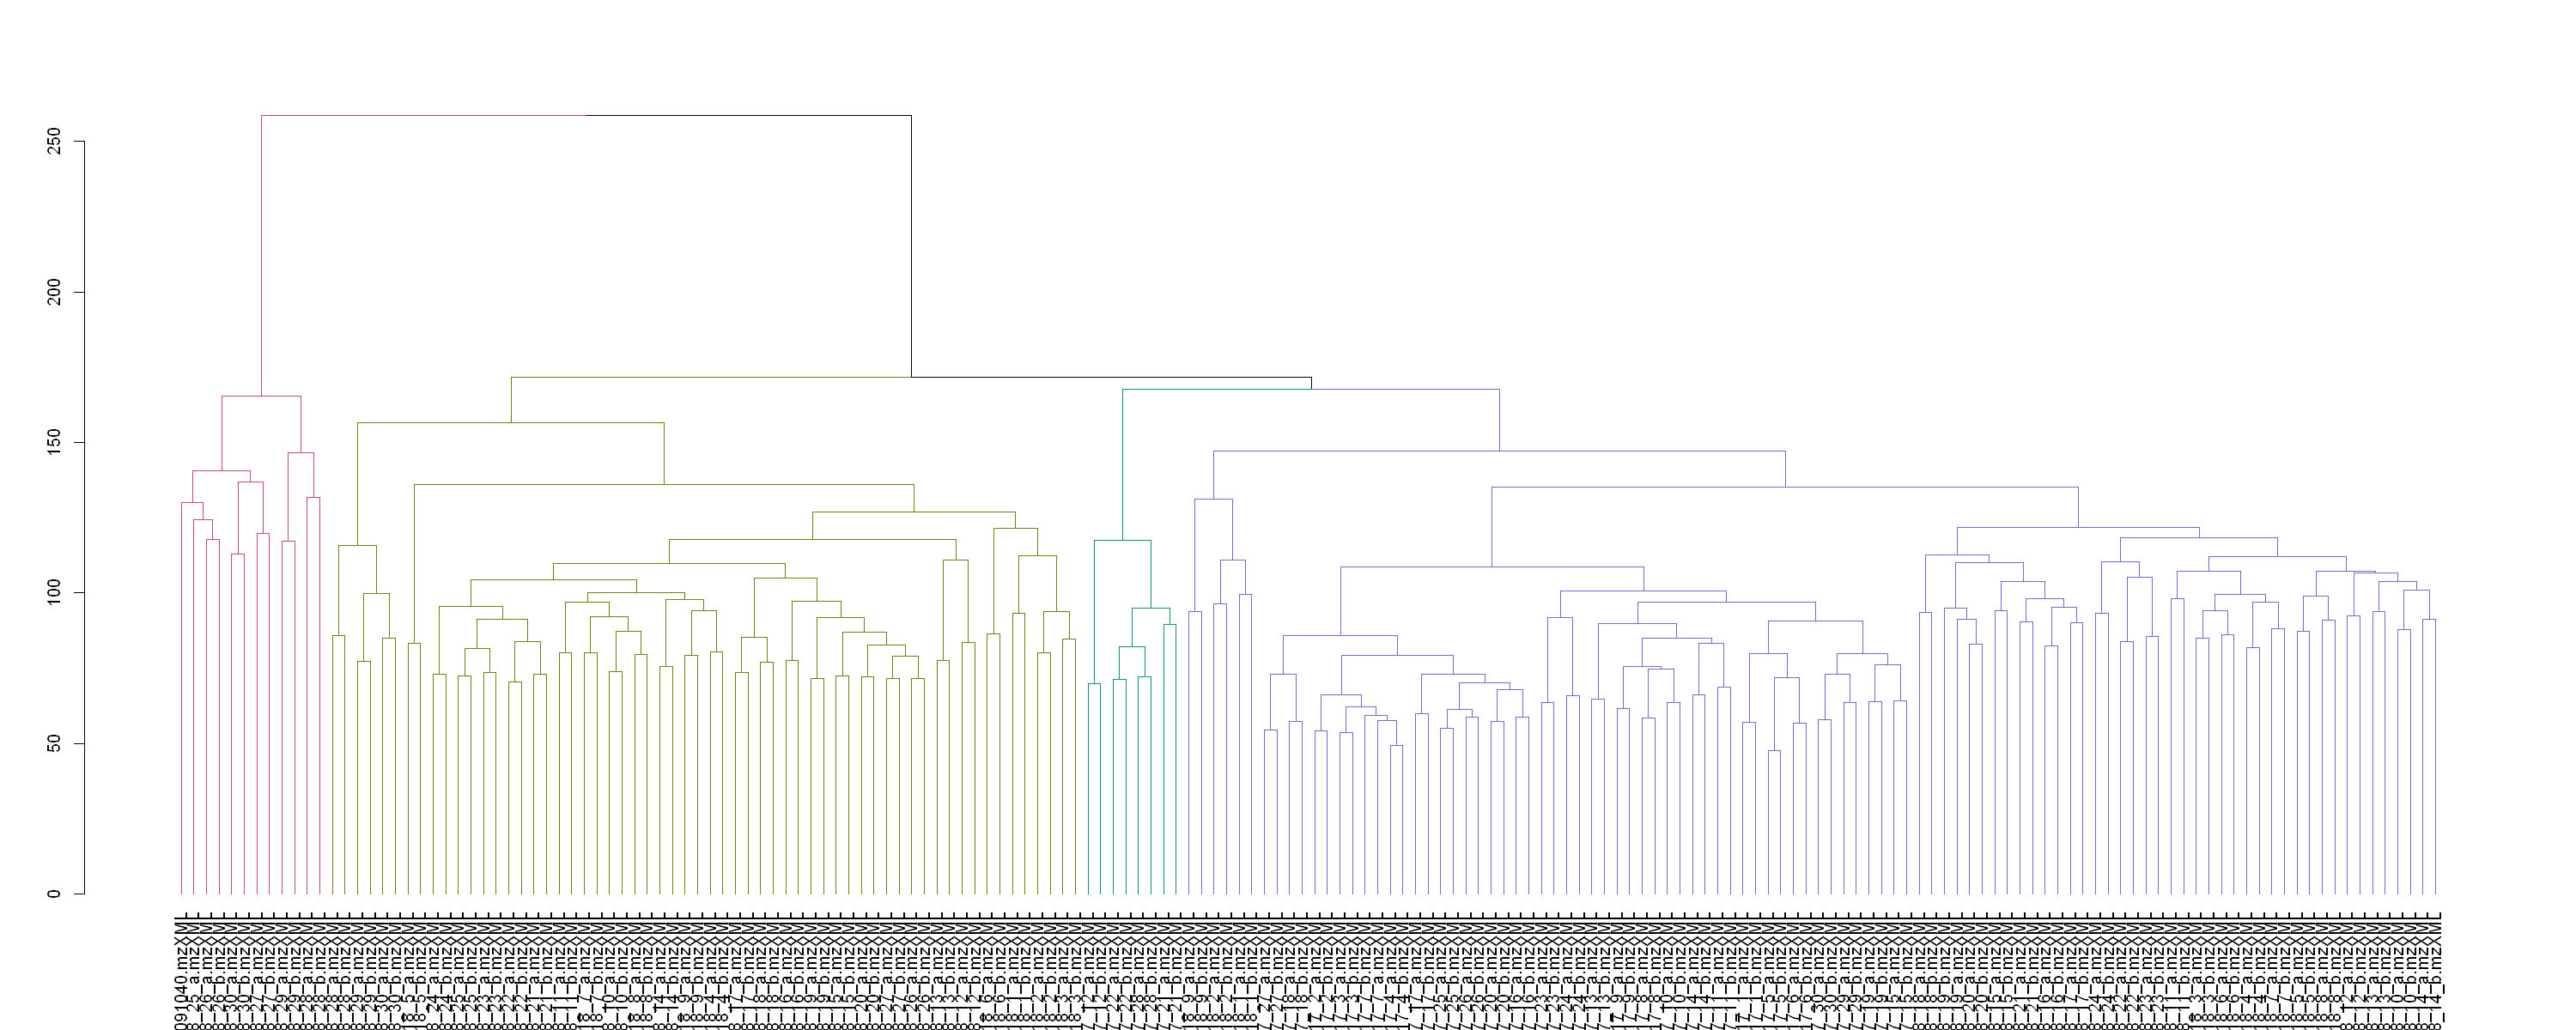

In [277]:
# Coloring the entire clusters with different colors
dend_obj <- as.dendrogram(hclust_res)
col_dend <- dendextend::color_branches(dend_obj, k = 4)
plot(col_dend)

### <font color ='darkblue'> Step 41: Determining the Optimal Number of Clusters </font>

We can define the number of clusters using some simple approaches. We are going to use the NbClust and factoextra packages for this purpose. We will look at two methods here: (i) the Elbow approach and (ii) the average silhouette method. The **Elbow method** looks at the total within-cluster sum of square (WSS) as a function of the number of clusters. <br>
WSS: sum of distances between the points and the corresponding centroids for each cluster.

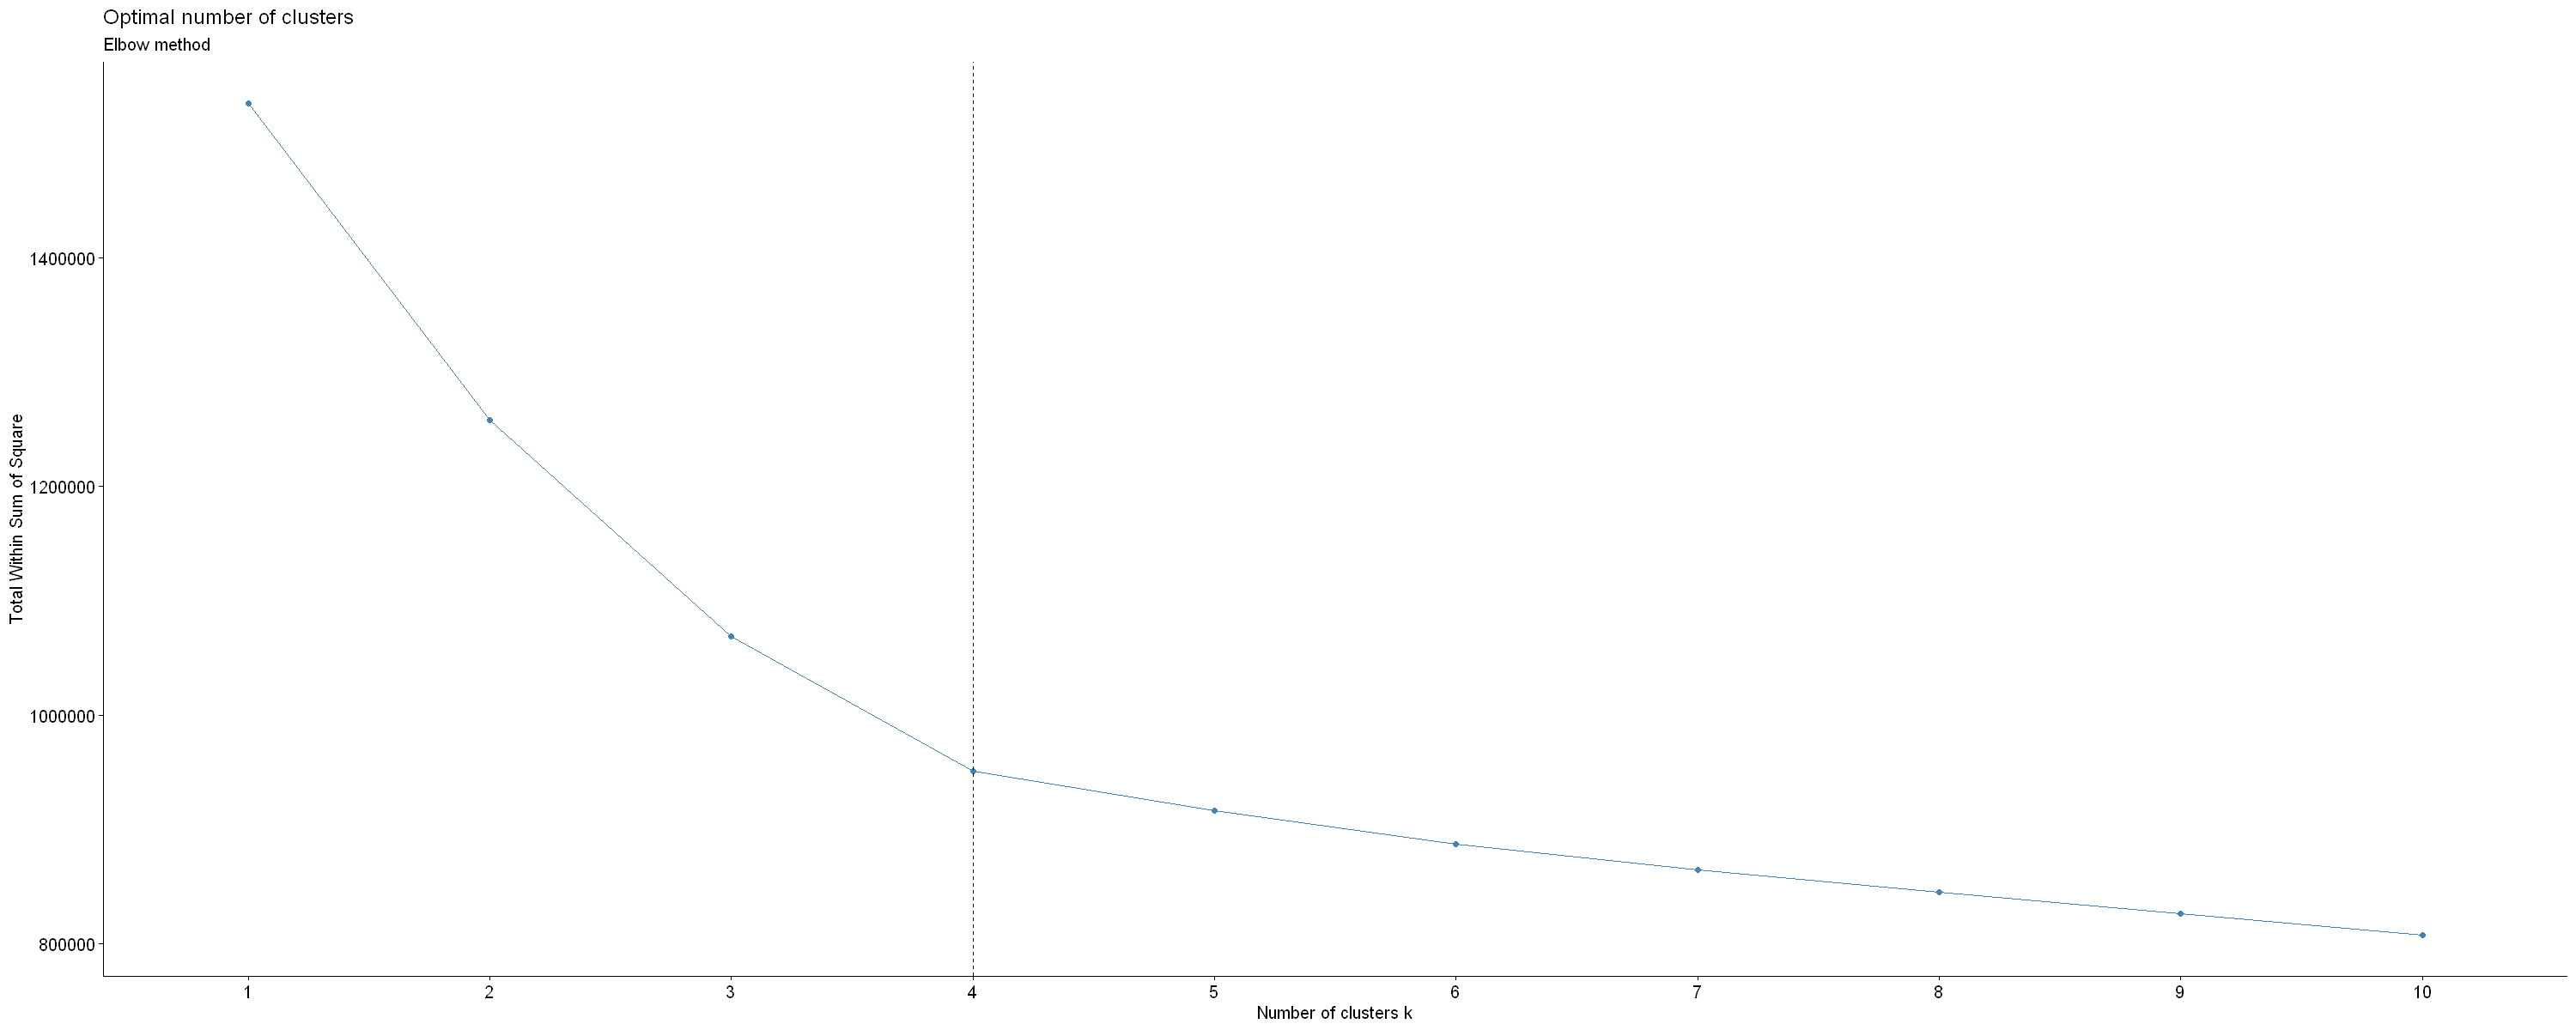

In [278]:
# Elbow method. Here we use 'hcut' which computes the hierarchical clustering and cut the tree.
fviz_nbclust(cleaned_data, hcut, method = "wss") +
  geom_vline(xintercept = 4, # add line indicating what you think is the optimal number of clusters
             linetype = 2) + 
  labs(subtitle = "Elbow method") # add subtitle

The location of an 'elbow' in the plot is usually considered as an indicator of the appropriate number of clusters because it means that adding another cluster does not improve the grouping. This method seems to suggest 3 or 4 clusters. Also in the above plot, the line at cluster 4 is given by us `geom_vline(xintercept = 4)`. The Elbow method is sometimes ambiguous. An alternative to this is the **average silhouette method**. The Silhouette method measures the quality of a clustering and determines how well each point lies within its cluster.

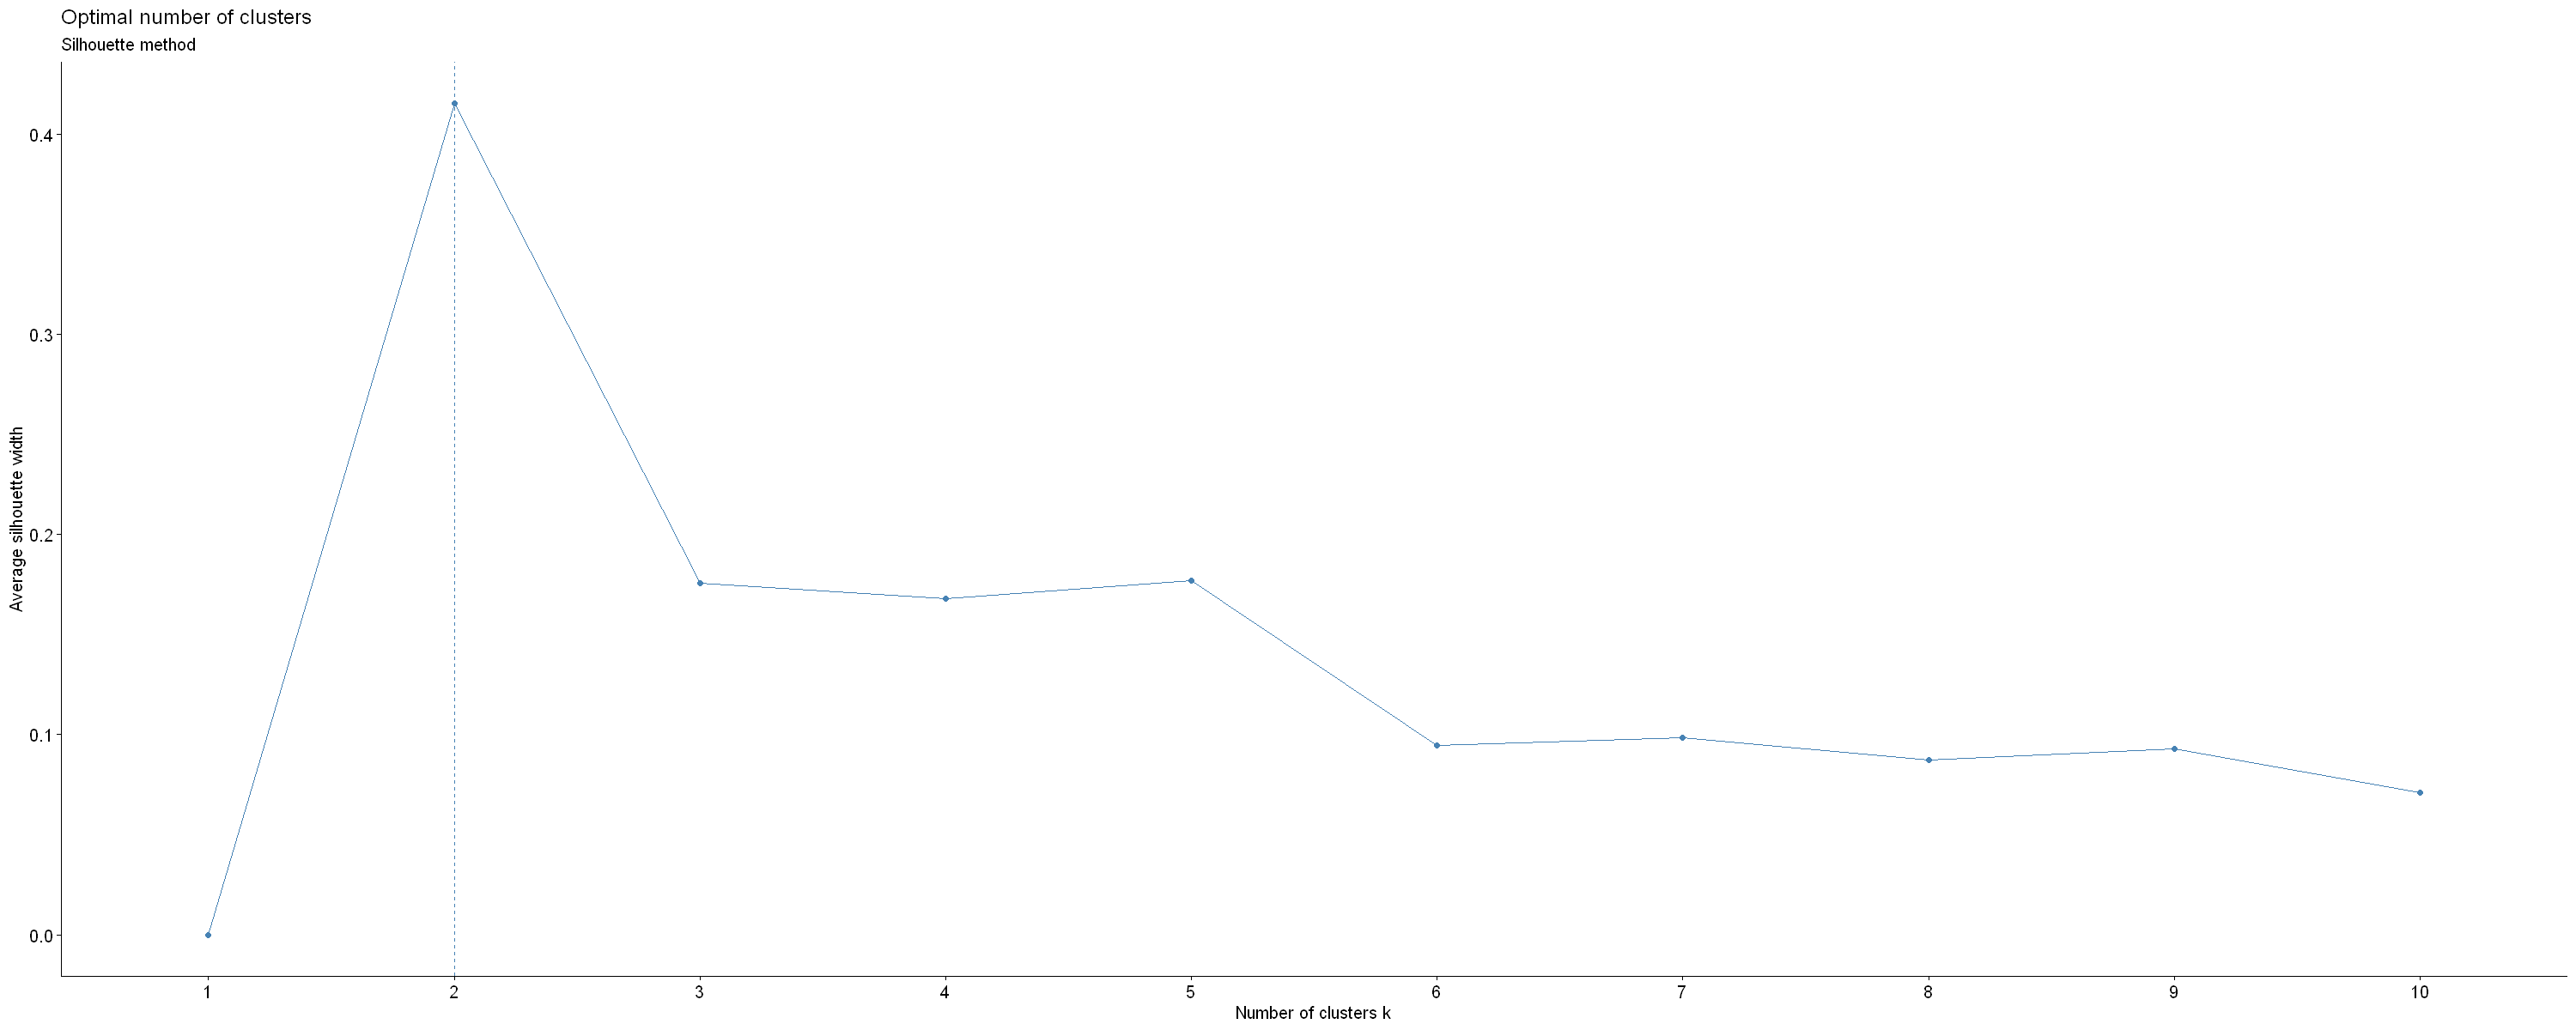

In [92]:
# Silhouette method
fviz_nbclust(cleaned_data, hcut, method = "silhouette") + 
labs(subtitle = "Silhouette method")

<p style='text-align: justify;'> In this case, the silouette method seems to find 2 main clusters. There are several other methods to discover the optimal number of clusters and sometimes they do not fully agree. Often, you will need to bring your own knowledge about the specific field to decide whether the number of clusters makes sense. </p>

---
## Heatmaps
<a name="heat_maps"></a>

<p style='text-align: justify;'>In the next section we will add an additional layer in our visualization by plotting a heatmap together with the hierarchical clustering. First, we prepare the <b>'decoration'</b> for our heatmap. We want to show some of the metadata such as 'ATTRIBUTE_Year', 'ATTRIBUTE_Month' and 'ATTRIBUTE_Sample_Area' colored in a distinctive way. It is much easier to read the heatmap in this way.  For this, we are going to use the <a href="https://jokergoo.github.io/ComplexHeatmap/reference/Heatmap.html">ComplexHeatmap package</a></p>
  

In [93]:
# metadata
colnames(md_Samples)

[1] "filename"                  "ATTRIBUTE_Sample.Type"    
 [3] "ATTRIBUTE_Batch"           "ATTRIBUTE_Month"          
 [5] "ATTRIBUTE_Year"            "ATTRIBUTE_Sample_Location"
 [7] "ATTRIBUTE_Replicate"       "ATTRIBUTE_Spot"           
 [9] "ATTRIBUTE_Latitude"        "ATTRIBUTE_Longitude"      
[11] "ATTRIBUTE_Sample_Area"     "ATTRIBUTE_Spot_Name"      
[13] "ATTRIBUTE_time_run"        "ATTRIBUTE_Injection_order"

### <font color ='darkblue'> Step 42: Preparing Metadata for Heatmap </font>

To start with, determine which metadata columns or attributes will be used to decorate the heatmap. In our case, we specified the following attributes: 'ATTRIBUTE_Year', 'ATTRIBUTE_Month', and 'ATTRIBUTE_Sample_Area'. 

### <font color ='darkblue'> Step 43: Generating Dataframe for Metadata </font>

Next, create a data frame comprising the chosen metadata, assigning individual colors for clear differentiation. Assign this data frame to annotate the heatmap using ‘HeatmapAnnotation’ function from the ‘ComplexHeatmap’ package. <font color = 'red'> For your own dataset, change these metadata attributes accordingly in the next cell. </font>

In [134]:
# Users can customize this section by choosing the columns they want to include
#and renaming them as desired for the heatmap

ann <- md_Samples %>%
  select(Year = ATTRIBUTE_Year,       # Rename 'ATTRIBUTE_Year' to 'Year'
         Month = ATTRIBUTE_Month,     # Rename 'ATTRIBUTE_Month' to 'Month'
         Area = ATTRIBUTE_Sample_Area) # Rename 'ATTRIBUTE_Sample_Area' to 'Area'

In [167]:
# Define a custom colorblind-friendly palette with 10 colors (you can replace with your desired colors)
custom_palette <- c("#4E79A7", "#F28E2B", "#E15759", "#76B7B2", "#59A14F", 
                    "#EDC948", "#B07AA1", "#FF9DA7", "#9C755F", "#BAB0AB")

Explore more colors using the RColorBrewer package or by simply check for the hex code https://www.color-hex.com/

In [168]:
library(RColorBrewer)
generate_colors <- function(attributes) {
  colors_list <- list()
    
    for(attribute in names(attributes)) {
        unique_values <- unique(attributes[[attribute]])
        n_colors <- length(unique_values)
        selected_colors <- custom_palette[1:n_colors] # Select the required number of colors from the "Set3" palette
        colors_list[[attribute]] <- setNames(selected_colors, unique_values)
    }
    return(colors_list)
}

In [169]:
colours <- generate_colors(ann)
colours

$Year
     2018      2017 
"#4E79A7" "#F28E2B" 

$Month
      Jan       Oct       Dec 
"#4E79A7" "#F28E2B" "#E15759" 

$Area
       Torrey_Pines SIO_La_Jolla_Shores       La_Jolla_Cove      La_Jolla Reefs 
          "#4E79A7"           "#F28E2B"           "#E15759"           "#76B7B2" 
      Pacific_Beach       Mission_Beach         Mission_Bay 
          "#59A14F"           "#EDC948"           "#B07AA1"

In [170]:
 # the function in ComplexHeatmap for preparing the annotation object 
colAnn <- HeatmapAnnotation(df = ann, col = colours, annotation_width = unit(c(1, 4), 'cm'),gap = unit(1, 'mm'))

### <font color ='darkblue'> Step 44: Creating the Heatmap </font>

[ComplexHeatmap](https://jokergoo.github.io/ComplexHeatmap/reference/Heatmap.html) gives you a flexible function and it is easy to change parameters. In the following, we will perform hierarchical clustering based on Euclidean distance. ComplexHeatmap uses the R package hclust function for this purpose, as seen in the previous section. 

<p style='text-align: justify;'> As we said, Euclidean distance is just an example that fits well continuous numerical values in your dataset but there are several distance measures such as Manhattan, Minkowski, Canberra etc. If you have binary data, you may consider to use Jaccard distance. </p>

In [171]:
# set the parameters for the type of clustering to perform. You can play with different options
set.seed(1234)
hmap <- Heatmap(
    t(cleaned_data),
    heatmap_legend_param = list(title = "Scaled/centered\nintensity"), 
    col = circlize::colorRamp2(c(0, 0.5, 1), colors = c("blue","white","darkred")),
    show_row_names = FALSE, show_column_names = FALSE,
    cluster_rows = TRUE, cluster_columns = TRUE,
    show_column_dend = TRUE, show_row_dend = TRUE,
    row_dend_reorder = TRUE, column_dend_reorder = TRUE,
    clustering_distance_rows = "euclidean", # you can change the distance here
    clustering_distance_columns = "euclidean", # you can change the distance here
    clustering_method_rows = "complete", 
    clustering_method_columns = "complete",
    width = unit(100, "mm"),
    top_annotation = colAnn)

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



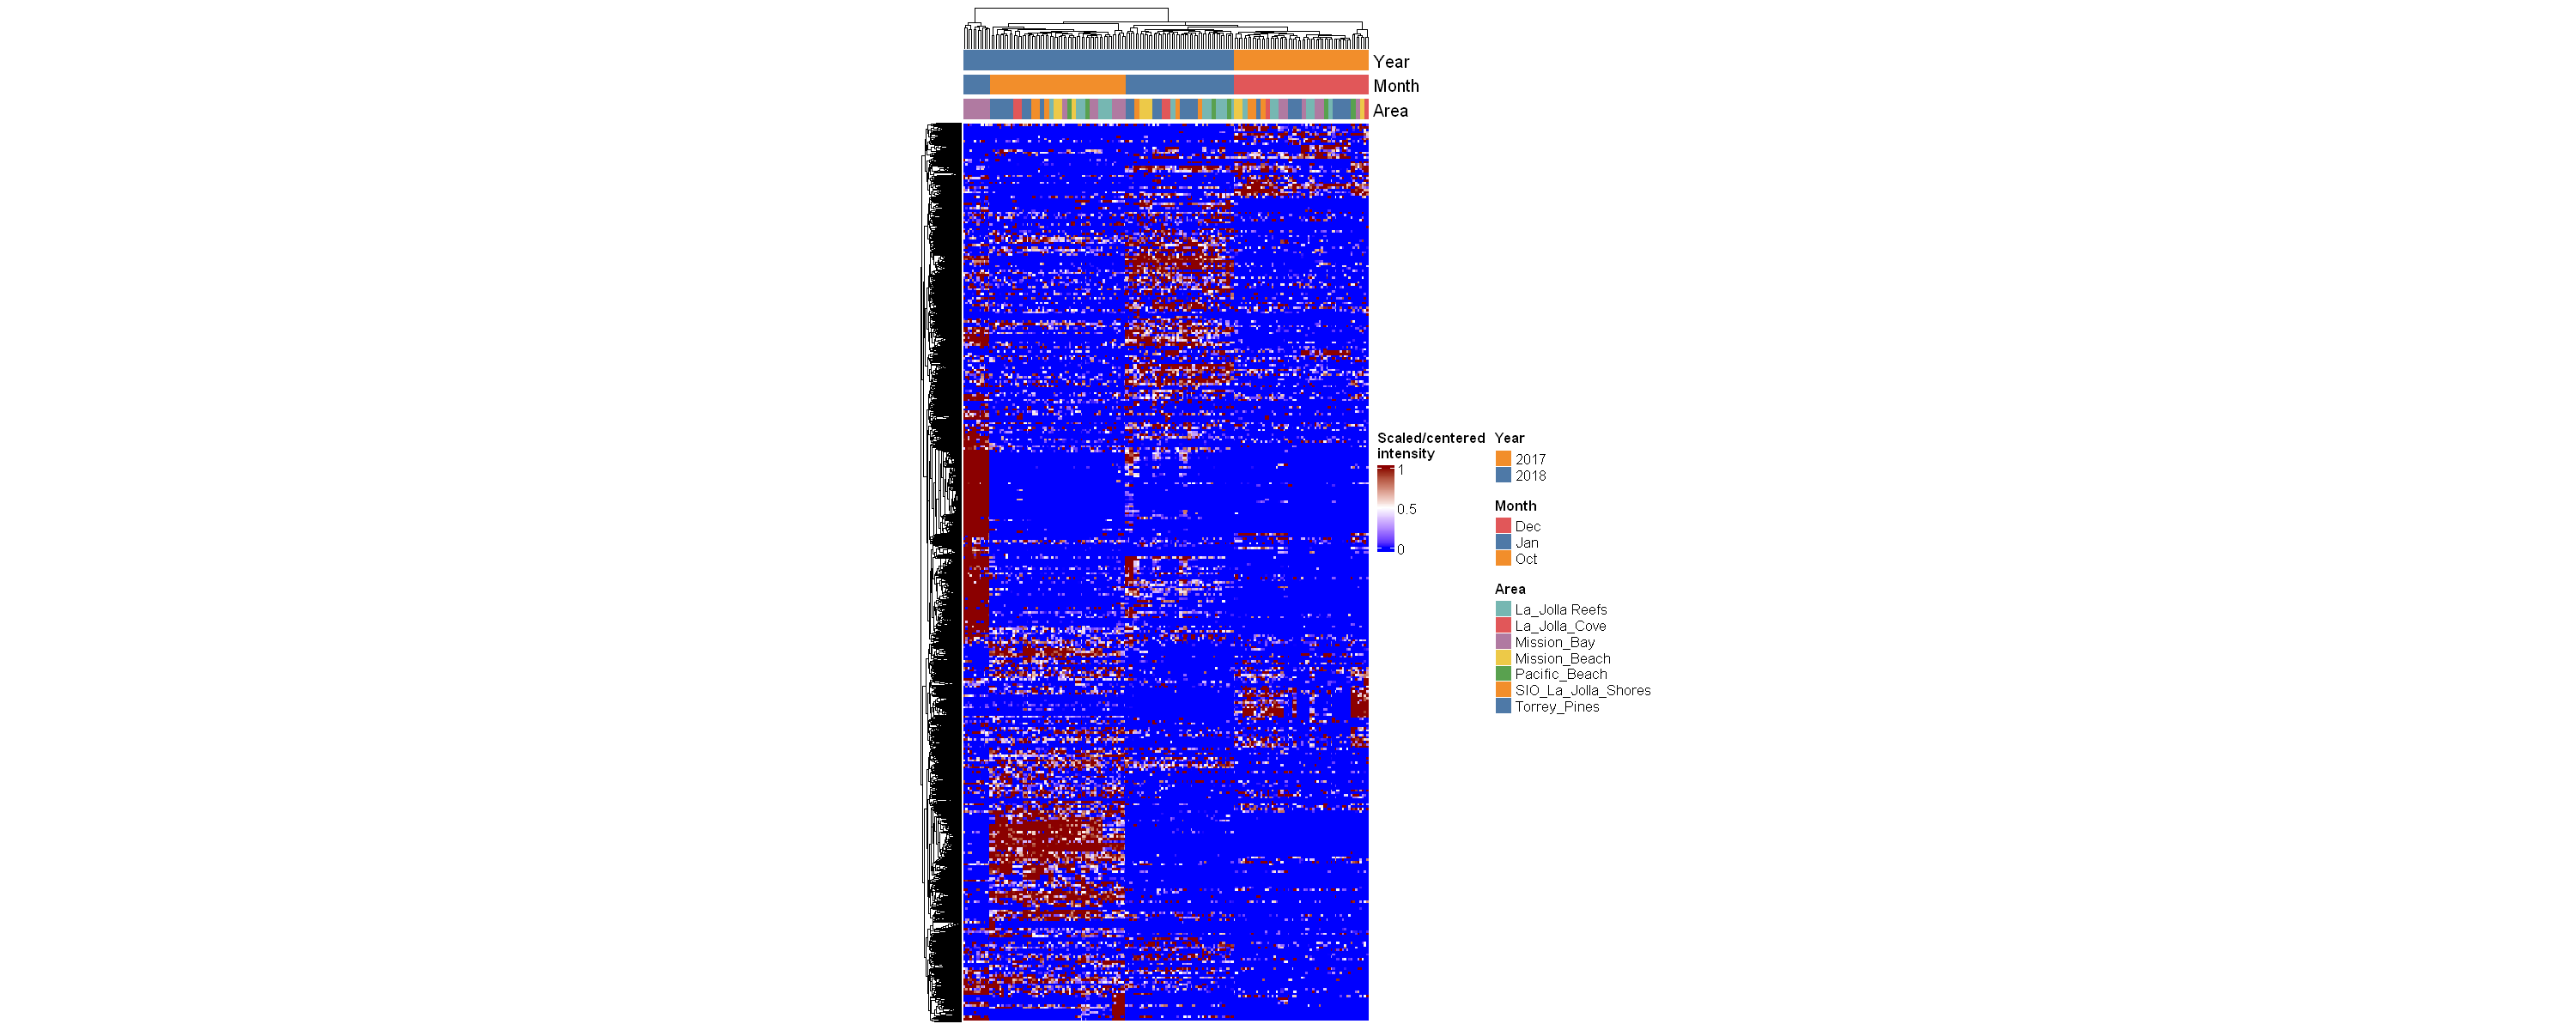

In [172]:
ComplexHeatmap::draw(hmap, heatmap_legend_side="right", annotation_legend_side="right")

As we can see, by using this type of visualization we can clearly observe the similarities between samples and features, in particular we can see again the separation of samples retrieved in 2017 and 2018 and separation based on month. We can also apply a method for dividing the heatmap according to a cluster assignment, similarly to the cutree() step, for generating better visualizations that can help the interpretation of the results.

Save the heatmap in svg format. The plot can be imported & modified  in Illustrator or similar program.

In [174]:
svglite('HeatMap_3D.svg', width=10, height=12, bg='white') # for saving as png, just change the extension as Heatmap.png
ComplexHeatmap::draw(hmap, heatmap_legend_side="right", annotation_legend_side="right")
dev.off() 

png 
  2

---
### <font color ='darkblue'> Step 45: Refining Data Clustering with k-means </font>

#### Heatmap with k-means clustering
ComplexHeatmap contains a function to find clusters by using another clustering algorithm called k-means.

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



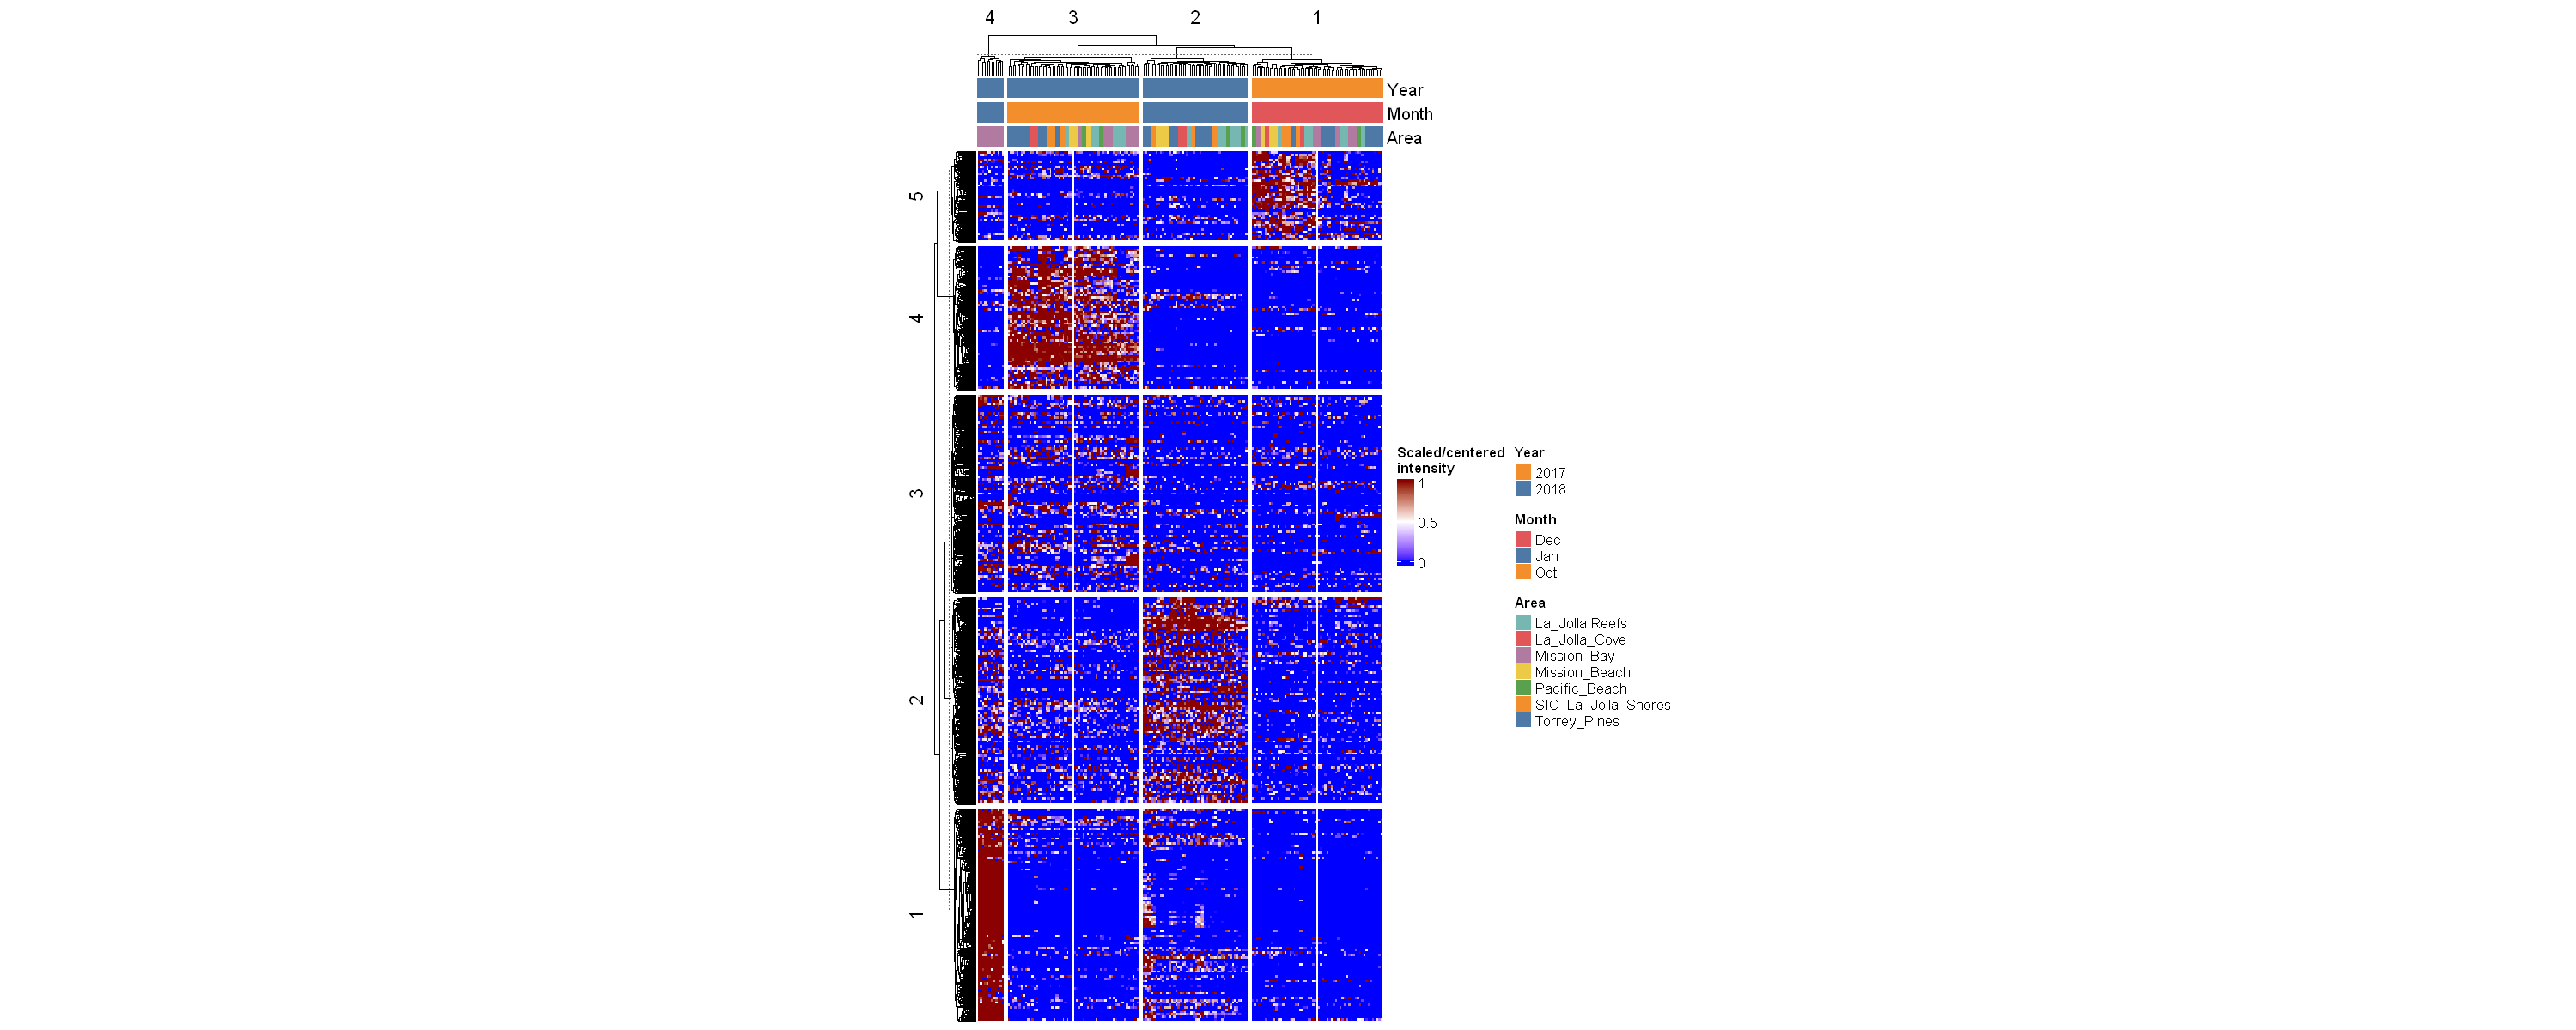

In [178]:
# set the parameters for the type of clustering to perform. You can play with different options
set.seed(1234)
hmap_km <- Heatmap(
    t(cleaned_data),
    heatmap_legend_param = list(title = "Scaled/centered\nintensity"), 
    col = circlize::colorRamp2(c(0, 0.5, 1), colors = c("blue","white","darkred")),
    show_row_names = FALSE, show_column_names = FALSE,
    cluster_rows = TRUE, cluster_columns = TRUE,
    show_row_dend = TRUE, show_column_dend = TRUE,
    row_dend_reorder = TRUE, column_dend_reorder = TRUE,
    clustering_distance_rows = "euclidean", # you can change the distance here
    clustering_distance_columns = "euclidean", # you can change the distance here
    clustering_method_rows = "complete", 
    clustering_method_columns = "complete",
    width = unit(100, "mm"),
    top_annotation = colAnn,
    # Parameters to perform k-means clustering:  
    row_km = 5, row_km_repeats = 100, #row_km indicates the no.of clusters you want in the rows
    column_km = 4, column_km_repeats = 100) #column_km refers to the no.of clusters you want in the columns

# draw heatmap. It can take some time if your input data is quite large
ComplexHeatmap::draw(hmap_km, heatmap_legend_side="right", annotation_legend_side="right")

We can see that k-means clustering was able to separate samples retrieved in a particular year and month and highlighted a subgroup (i.e. cluster 4 in the columns) consisting of the area Mission Bay. In the next step, we extract the features belonging to the clusters for future use.

### <font color ='darkblue'> Step 46: Extracting Features from Each Cluster </font>

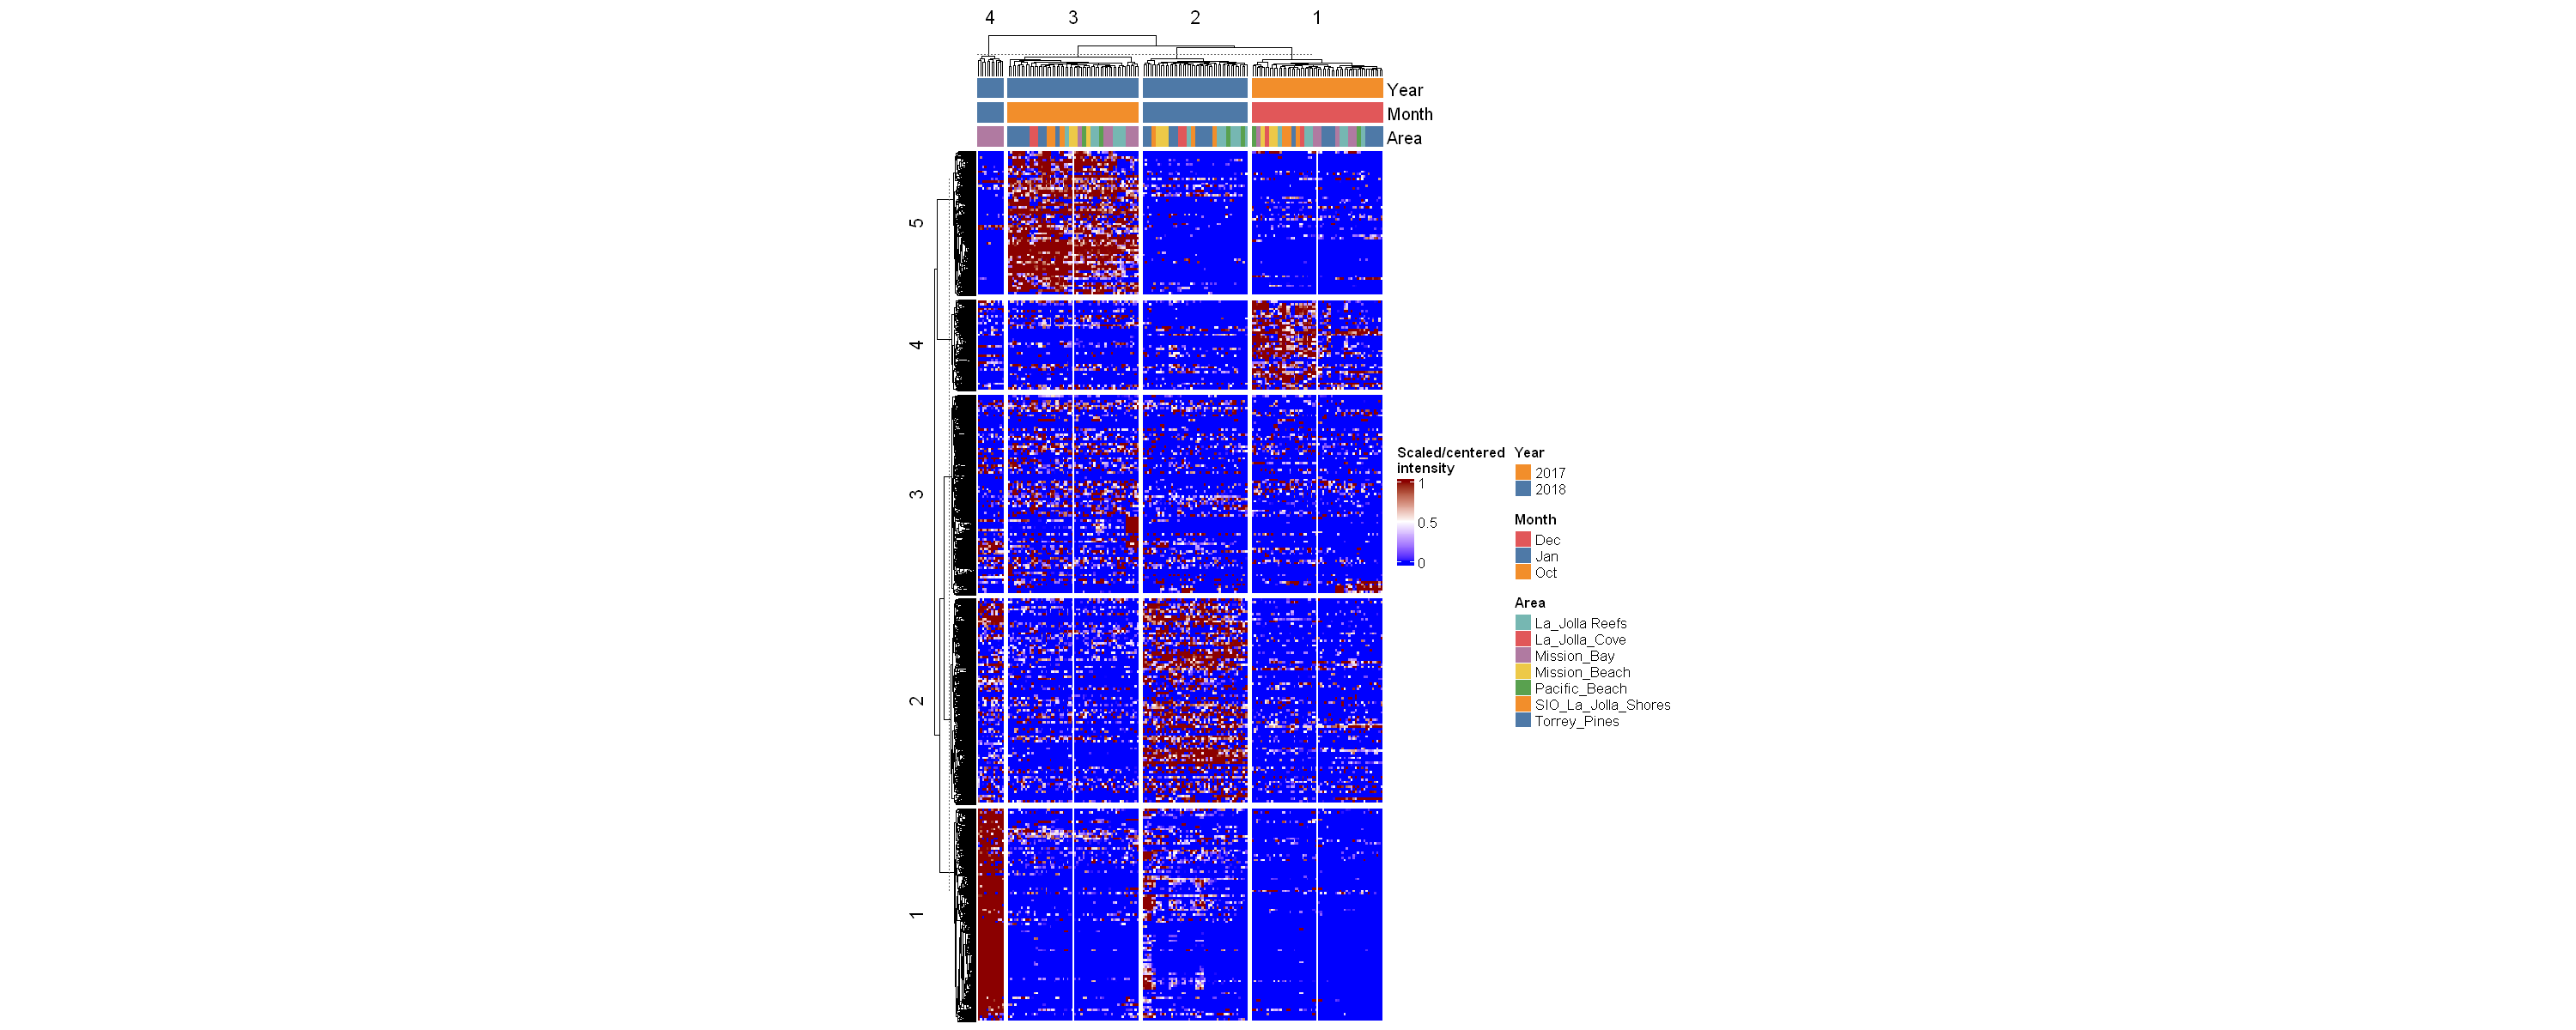

In [179]:
row_order_res <- row_order(ComplexHeatmap::draw(hmap_km, 
                                                heatmap_legend_side="right", 
                                                annotation_legend_side="right"))  

In [180]:
# check/confirm size of clusters
print(lengths(row_order_res))

   5    4    3    2    1 
1453  914 2003 2063 2142 


In [181]:
# loop to extract features for each cluster
out_res <- NULL
for (i in seq_along(row_order_res)){
out_res[[i]] <- cbind(colnames(cleaned_data[,row_order_res[[i]]]), paste("cluster", i, sep=""))  
}

out_res <- as.data.frame(do.call(rbind, out_res)) #getting the list elements into a dataframe
colnames(out_res) <- c('feature','cluster')
dim(out_res) # dimension of the object
table(out_res$cluster) # number of features in each cluster
head(out_res)

[1] 8575    2


cluster1 cluster2 cluster3 cluster4 cluster5 
    1453      914     2003     2063     2142 

,feature,cluster
,<chr>,<chr>
1,X49843_492.226_6.496_NA,cluster1
2,X52004_336.216_6.717_NA,cluster1
3,X49917_309.205_6.504_NA,cluster1
4,X45067_535.252_5.978_NA,cluster1
5,X55162_426.321_7.132_NA,cluster1
6,X44453_455.028_5.917_NA,cluster1


In [182]:
# save the data frame with cluster information as csv
write.csv(out_res, paste0(Sys.Date(),'_feature_clusters.csv'), row.names =F)

In [183]:
# save the heatmap in svg format.
svglite('heatmap_kmeans.svg', width=10, height=8, bg='white')
draw(hmap_km, heatmap_legend_side="right", annotation_legend_side="right")
dev.off()

png 
  2

---
# <font color = 'blue'> 5. Supervised learning with Random Forest</font>
<a name="rf"></a>

In [184]:
pacman::p_load("rfPermute") #loading the rfpermute package for performing random forest

<p style='text-align: justify;'> Random Forest is a powerful machine learning algorithm used for both classification and regression tasks. It is an ensemble learning method that combines multiple decision trees to improve the accuracy and robustness of the model. Each tree in the forest is constructed using a random subset of features and training data, which helps to reduce overfitting and increase the diversity of the trees. Random Forest can handle multidimensional data with complex interactions and provides feature importance measures, making it a popular choice for many applications in various fields. </p>

### <font color ='darkblue'> Step 47: Prepare the data for Random Forest </font>

In [185]:
# merging metadata with scaled data
Data <- merge(md_Samples,Imp_s,by.x="filename",by.y="row.names") 

In [186]:
write.csv(Data, paste0(Sys.Date(),"_cleaned_Imp_s_metadata_merged.csv"),row.names =T) #writing the file as csv

In [187]:
#merging metadata with normalised data for further use as well
md_Norm_merged <- merge(md_Samples,norm_TIC, by.x="filename", by.y="row.names")

In [188]:
write.csv(md_Norm_merged, paste0(Sys.Date(),"_normTIC_metadata_merged.csv"),row.names =T) #writing the file as csv

We make sure that the merging of the two data frames was successful. 

In [189]:
dim(Imp_s)
dim(md_Samples)
dim(Data) # no.of columns of Data = (no.of columns of Imp_s) + (no.of columns of md_Samples)

[1]  180 8575

[1] 180  14

[1]  180 8589

In [190]:
head(Data)

,filename,ATTRIBUTE_Sample_Type,ATTRIBUTE_Batch,ATTRIBUTE_Month,ATTRIBUTE_Year,ATTRIBUTE_Sample_Location,ATTRIBUTE_Replicate,ATTRIBUTE_Spot,ATTRIBUTE_Latitude,ATTRIBUTE_Longitude,...,X9833_268.175_2.821_NA,X9860_240.144_2.824_NA,X9876_414.139_2.761_NA,X9884_190.05_2.832_NA,X9897_333.144_2.881_NA,X9909_400.16_2.813_NA,X9918_252.123_2.833_NA,X9957_402.139_3.01_NA,X9972_323.123_2.716_NA,X9995_276.159_2.805_NA
,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,SD_01-2018_1_a.mzXML,Sample,2,Jan,2018,1,a,1,32.93365,-117.2648,...,0.50939531,0.3411232,-0.9690079,-0.2136802,-1.0317304,-0.3098083,-0.177995,1.1679223,-0.9536029,-0.720866222
2,SD_01-2018_1_b.mzXML,Sample,2,Jan,2018,1,b,1,32.93365,-117.2648,...,0.09223042,0.5325915,1.0516269,-0.3039294,-0.1930184,-0.7478302,1.252001,0.9551530,-0.9361819,-0.008649493
3,SD_01-2018_10_a.mzXML,Sample,2,Jan,2018,10,a,10,32.86261,-117.2604,...,-0.24656797,-0.2876450,4.3836879,-0.6677396,-0.4632050,4.5197958,2.438135,-0.7384554,1.9221174,0.486385714
4,SD_01-2018_10_b.mzXML,Sample,2,Jan,2018,10,b,10,32.86261,-117.2604,...,-0.25209546,-0.2285787,0.4843269,-0.5685205,1.5535042,-0.8303185,1.434401,4.0595393,0.6681850,0.985040468
5,SD_01-2018_11_a.mzXML,Sample,2,Jan,2018,11,a,11,32.85601,-117.2625,...,-0.28863284,-0.2476732,1.5809568,-0.6621337,0.3906509,-0.6962414,2.185162,-0.5521619,0.4461508,1.021275053
6,SD_01-2018_11_b.mzXML,Sample,2,Jan,2018,11,b,11,32.85601,-117.2625,...,-0.24694487,-0.2404170,0.3811471,-0.6654102,-1.1098859,3.4050301,1.824056,-0.6258216,-0.7639999,-0.815276164


Printing all the column names that belong to the metadata category:

In [191]:
Data %>% select(!starts_with("X")) %>% colnames %>% print #getting the column names that does not begin with 'X'

 [1] "filename"                  "ATTRIBUTE_Sample_Type"    
 [3] "ATTRIBUTE_Batch"           "ATTRIBUTE_Month"          
 [5] "ATTRIBUTE_Year"            "ATTRIBUTE_Sample_Location"
 [7] "ATTRIBUTE_Replicate"       "ATTRIBUTE_Spot"           
 [9] "ATTRIBUTE_Latitude"        "ATTRIBUTE_Longitude"      
[11] "ATTRIBUTE_Sample_Area"     "ATTRIBUTE_Spot_Name"      
[13] "ATTRIBUTE_time_run"        "ATTRIBUTE_Injection_order"


In [192]:
RF_data <- Data %>% select(starts_with("X")) #selecting the  column names beginning with 'X', these are the features

Here, we want to see how RF classifies the samples according to different sample area.
In the cell below, enter the column name of the interested attribute to use for the classification.

In [193]:
Interested_attribute <- 'ATTRIBUTE_Sample_Area' 

The data used for RF classification should contain the interested attribute for classification in addition to the feature information.

In [194]:
RF_data <- cbind(Data[,Interested_attribute,drop=F],RF_data) 
head(RF_data)

,ATTRIBUTE_Sample_Area,X10015_282.169_2.763_NA,X10035_325.139_2.817_NA,X10037_216.123_2.847_NA,X10047_338.159_2.845_NA,X10058_280.117_2.961_NA,X10059_414.175_2.851_NA,X10082_309.144_2.886_NA,X10095_388.254_2.791_NA,X10097_302.206_2.849_NA,...,X9833_268.175_2.821_NA,X9860_240.144_2.824_NA,X9876_414.139_2.761_NA,X9884_190.05_2.832_NA,X9897_333.144_2.881_NA,X9909_400.16_2.813_NA,X9918_252.123_2.833_NA,X9957_402.139_3.01_NA,X9972_323.123_2.716_NA,X9995_276.159_2.805_NA
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Torrey_Pines,-1.1304738,-0.2996814,-0.1117478,2.2186171,-1.45214596,-0.17585640,-0.98669140,-0.2001378,-0.2847595,...,0.50939531,0.3411232,-0.9690079,-0.2136802,-1.0317304,-0.3098083,-0.177995,1.1679223,-0.9536029,-0.720866222
2,Torrey_Pines,-1.1265155,-0.6037285,1.9885974,0.2986375,-1.02831734,0.38489623,0.01064872,-0.2193144,-0.1910732,...,0.09223042,0.5325915,1.0516269,-0.3039294,-0.1930184,-0.7478302,1.252001,0.9551530,-0.9361819,-0.008649493
3,SIO_La_Jolla_Shores,-0.6995949,-0.4612237,-0.3619079,1.2580121,0.74726202,-0.05862904,-0.56453208,-0.2186275,-0.2692562,...,-0.24656797,-0.2876450,4.3836879,-0.6677396,-0.4632050,4.5197958,2.438135,-0.7384554,1.9221174,0.486385714
4,SIO_La_Jolla_Shores,-0.2034930,-0.4966002,-0.2732416,1.3559666,-1.39170040,-0.28470826,-0.55716080,-0.2199242,-0.2546691,...,-0.25209546,-0.2285787,0.4843269,-0.5685205,1.5535042,-0.8303185,1.434401,4.0595393,0.6681850,0.985040468
5,SIO_La_Jolla_Shores,-0.7347561,0.6853802,-0.1363247,2.9093771,0.06876711,-1.01417176,-0.53667810,-0.2181610,-0.2570599,...,-0.28863284,-0.2476732,1.5809568,-0.6621337,0.3906509,-0.6962414,2.185162,-0.5521619,0.4461508,1.021275053
6,SIO_La_Jolla_Shores,-0.7096955,-0.6041064,0.2861615,1.1639750,0.64835653,-0.18416959,-0.56446679,-0.2005905,-0.3214967,...,-0.24694487,-0.2404170,0.3811471,-0.6654102,-1.1098859,3.4050301,1.824056,-0.6258216,-0.7639999,-0.815276164


In [195]:
table(RF_data[,1]) #1st column is the attribute information


     La_Jolla Reefs       La_Jolla_Cove         Mission_Bay       Mission_Beach 
                 36                  12                  36                  18 
      Pacific_Beach SIO_La_Jolla_Shores        Torrey_Pines 
                 12                  18                  48 

### <font color ='darkblue'> Step 48: Balance sample sizes </font>

Here, when the sample size is different among the group, we need to balance the size.

In [196]:
balanced_size <- balancedSampsize(RF_data[,1])
print(balanced_size)

     La_Jolla Reefs       La_Jolla_Cove         Mission_Bay       Mission_Beach 
                  6                   6                   6                   6 
      Pacific_Beach SIO_La_Jolla_Shores        Torrey_Pines 
                  6                   6                   6 


### <font color ='darkblue'> Step 49: Run Random Forest </font>

<p style='text-align: justify;'> Performing Random Forest with 500 trees (ntree) and 500 permutations (num.rep). Generally, a larger number of these variables improves the performance of the model but also increases the computational cost. It is recommended to start with a reasonable number of trees (e.g., 500-1000) and num.rep (500-10000) and then tune it based on the performance. </p> 

<font color="red"><font size=3> Depending on the number of trees and permutations provided, the following cell may take a considerable amount of time to execute !!</font>

In [119]:
rp <- rfPermute(x = RF_data[,-1], #feature table without the classification info
                y = as.factor(RF_data[,1]), #classification variable
                sampsize=balanced_size, #give the balanced sample size info
                ntree=500,
                num.rep=500,
                proximity = T)

In [120]:
rp

An rfPermute model

               Type of random forest: classification 
                     Number of trees: 500 
No. of variables tried at each split: 95 
       No. of permutation replicates: 500 
                          Start time: 2023-08-07 14:20:55 
                            End time: 2023-08-07 15:16:39 
                            Run time: 55.7 mins 

                    La_Jolla Reefs La_Jolla_Cove Mission_Bay Mission_Beach
La_Jolla Reefs                  23             1           2             2
La_Jolla_Cove                    0            11           0             0
Mission_Bay                      4             0          26             4
Mission_Beach                    3             0           0            13
Pacific_Beach                    2             0           0             3
SIO_La_Jolla_Shores              1             1           0             2
Torrey_Pines                     0             0           0             0
Overall                       

### <font color ='darkblue'> Step 50: Evaluate model performance </font>
<p style='text-align: justify;'>In Random Forest, the OOB (Out-Of-Bag) error is an estimate of the model's prediction error on unseen data. During the training process, each tree in the forest is grown using a bootstrap sample of the original data, leaving out about one-third of the observations on average. These left-out observations are called the OOB samples. The OOB error line in Random Forest provides an estimate of the model's error rate based on the OOB samples. It is a useful metric for evaluating the performance of the model and for comparing different random forest models. A lower OOB error indicates better predictive performance, but it is important to validate the model on a separate test set to obtain a more accurate estimate of its performance on new data. </p>

In [123]:
#Most important model quality plot
#OOB error lines should flatline. If it doesn't flatline, add more trees

#svglite('OOB_curve_RF.svg', width=15, height=10, bg='white')
plotTrace(rp)
#dev.off()

png 
  2

### <font color ='darkblue'> Step 51: Interpreting RF Results </font>

Beyond these, the RF results can be interpreted in various ways:

- One could plot the most impactful predictors in the model using violin plots. Here, we show the top 9 predictors

- Compare class predictions versus the actual group in a proximity plot

- Rank features by importance using the 'Mean Decrease Accuracy' metric. This metric helps identify features whose removal significantly impacts the model's accuracy, thus marking their importance. If a feature's removal does not affect accuracy, it may be deemed less important. Features with a ‘MeanDecreaseAccuracy.pval’ < .05 are considered significant, implying that their absence would affect the model's performance significantly. This ranked list can also be exported as a CSV file for further analysis.


**Plot the top predictions (9) violin plots**:

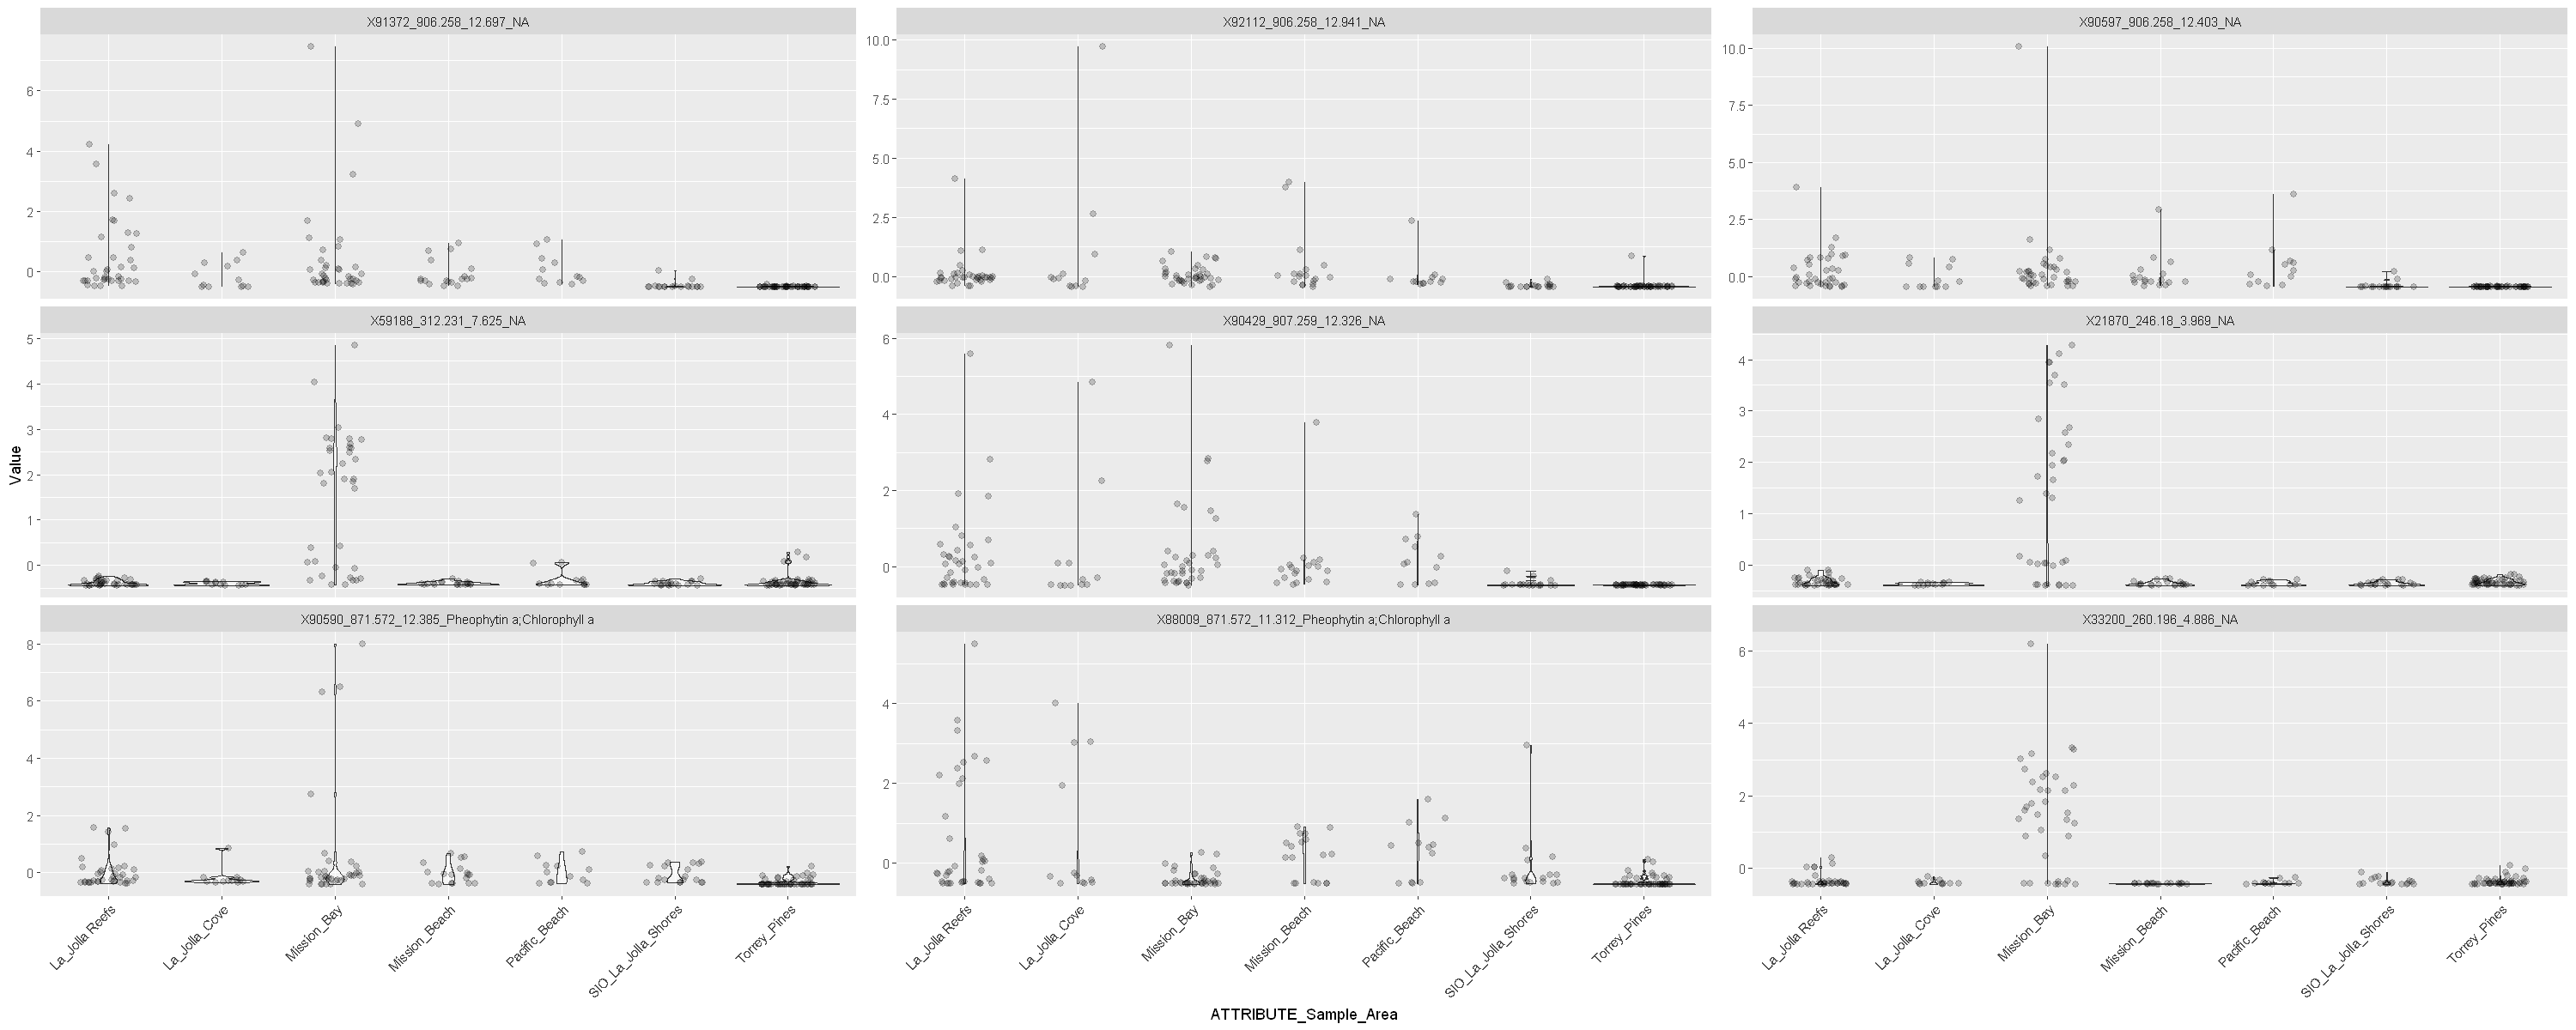

In [126]:
#svglite('Top9_violinPlots_RF.svg')
plotImpPreds(
    rp, #rfPermute model object
    RF_data, #dataframe
    colnames(RF_data)[1], #takes the name of attribute column in RF_data
    imp.type = NULL,
    max.vars = 9, #chnage for the number of top features
    scale = FALSE,
    size = 2,
    point.alpha = 0.2,
    violin.alpha = 0.5,
    plot = TRUE
)
#dev.off()

**Plot class predictions vs actual group and add 95% confidence ellipse.**:

In [150]:
#svglite('ClassPredictions_RF.svg', width=10, height=10)
plotProximity(
  rp,
  class.cols = c('orange','darkgreen','red','blue','black','grey','purple'), #colors provided as same as PCoA. To give standard colors, include NULL
  legend.type = c("legend"),
  legend.loc = c("bottom"),
  point.size = 2.2,
  circle.size = 9,
  circle.border = 1.2,
  group.type = c("ellipse"),
  group.alpha = 0.2,
  ellipse.level = 0.95,
  n.contour.grid = 100,
  label.size = 10,
  label.alpha = 0.9,
  plot = TRUE
)
dev.off()

png 
  2

Here, dot represents the actual sample. The circle represents the prediction.

**Ranking features by importance**:

We can also rank the feature by importance. The top features had a larger impact on determining the prediction of sampling area. 

In [129]:
#Extract the important features in the model
Important_features_RF <- data.frame(importance(rp))
head(Important_features_RF,3)
dim(Important_features_RF)

,La_Jolla.Reefs,La_Jolla.Reefs.pval,La_Jolla_Cove,La_Jolla_Cove.pval,Mission_Bay,Mission_Bay.pval,Mission_Beach,Mission_Beach.pval,Pacific_Beach,Pacific_Beach.pval,SIO_La_Jolla_Shores,SIO_La_Jolla_Shores.pval,Torrey_Pines,Torrey_Pines.pval,MeanDecreaseAccuracy,MeanDecreaseAccuracy.pval,MeanDecreaseGini,MeanDecreaseGini.pval
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X91372_906.258_12.697_NA,3.015494,0.001996008,-0.4061187,0.948103792,2.770172,0.001996008,2.249322,0.001996008,2.363081,0.001996008,2.951836,0.001996008,3.802757,0.001996008,3.857012,0.001996008,0.1507204,0.001996008
X92112_906.258_12.941_NA,3.021081,0.001996008,-0.1238817,0.920159681,2.780703,0.001996008,1.388303,0.009980040,2.442695,0.001996008,3.044028,0.001996008,3.557362,0.001996008,3.627999,0.001996008,0.1560637,0.001996008
X90597_906.258_12.403_NA,3.012017,0.001996008,1.7812483,0.001996008,2.296821,0.001996008,2.880902,0.001996008,2.128914,0.001996008,2.562427,0.001996008,3.246883,0.001996008,3.534567,0.001996008,0.1334735,0.001996008


[1] 9092   18

In [130]:
#Selecting only features that are significant.
Significant_features_RF <- Important_features_RF[Important_features_RF$MeanDecreaseAccuracy.pval < .05,]
head(Significant_features_RF,3)
dim(Significant_features_RF)

,La_Jolla.Reefs,La_Jolla.Reefs.pval,La_Jolla_Cove,La_Jolla_Cove.pval,Mission_Bay,Mission_Bay.pval,Mission_Beach,Mission_Beach.pval,Pacific_Beach,Pacific_Beach.pval,SIO_La_Jolla_Shores,SIO_La_Jolla_Shores.pval,Torrey_Pines,Torrey_Pines.pval,MeanDecreaseAccuracy,MeanDecreaseAccuracy.pval,MeanDecreaseGini,MeanDecreaseGini.pval
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X91372_906.258_12.697_NA,3.015494,0.001996008,-0.4061187,0.948103792,2.770172,0.001996008,2.249322,0.001996008,2.363081,0.001996008,2.951836,0.001996008,3.802757,0.001996008,3.857012,0.001996008,0.1507204,0.001996008
X92112_906.258_12.941_NA,3.021081,0.001996008,-0.1238817,0.920159681,2.780703,0.001996008,1.388303,0.009980040,2.442695,0.001996008,3.044028,0.001996008,3.557362,0.001996008,3.627999,0.001996008,0.1560637,0.001996008
X90597_906.258_12.403_NA,3.012017,0.001996008,1.7812483,0.001996008,2.296821,0.001996008,2.880902,0.001996008,2.128914,0.001996008,2.562427,0.001996008,3.246883,0.001996008,3.534567,0.001996008,0.1334735,0.001996008


[1] 503  18

<p style='text-align: justify;'>The 'Mean Decrease Accuracy' metric in the RF model is used to find which features are the most important for the model to make accurate predictions. When a feature is very important for the model, removing it significantly decrease the model's accuracy. On the other hand, if a feature is not important, removing it will have little effect on the model's accuracy. <b>MeanDecreaseAccuracy.pval < .05</b> is a statistical test applied to the Mean Decrease Accuracy values of each feature. It checks whether the Mean Decrease Accuracy value of a feature is significantly different from the null hypothesis (H0), which assumes that the feature has no effect on the model. A p-value < 0.05 indicates that the Mean Decrease Accuracy value is significantly different from the null hypothesis, and the feature is considered important for the model. </p>
    
<p style='text-align: justify;'> We can thh examine how these significant annotated features contribute to sample classification based on the grouping factor such as Sampling Area, in our example. We can further explore our experimental data to determine the influence of several factors such as type of sampling area, environmental conditions during the sampling process, and sample preparation steps on the observed intensity differences among different groups. Further analysis such as pathway analysis, correlation analysis, or literature search can be performed to investigate the biological relevance of these compounds and their relationship to sample classification. Experimental validation can also be performed to confirm the potential of identified compounds as biomarkers.</p>

In [131]:
write.csv(Important_features_RF, paste0(Sys.Date(),'_Importance_features_RF_500trees_500perm.csv'))
write.csv(Significant_features_RF, paste0(Sys.Date(),'_Top5percent_ImportantFeatures_RF_500trees_500perm.csv'))

In addition to the provided steps, we have also included instructions for advanced supervised classification methods like the Gradient boosting algorithm <b>XGBoost</b> in a separate notebook [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Functional-Metabolomics-Lab/FBMN-STATS/blob/main/Individual_Notebooks/R-Notebooks/XGBoost_Tuning_Parameters.ipynb)

---

# <font color ='blue'> 6. Univariate Analysis </font>
<a name="uni"></a>

### <font color ='darkblue'> Step 52: Install Packages for Univariate Analyses </font>
<font color="red" size =4> Initial installation of the packages will take about 10-15 mins !!</font> 

In [132]:
pacman::p_load("matrixStats","FSA","cowplot") #installing & loading the necessary libraries

In [173]:
options(repr.plot.width=6, repr.plot.height=6,res=600)

<p style='text-align: justify;'>Univariate statistics involves analysing "one" variable (or one category) at a time in an attempt to describe the data. In univariate statistics, our null hypothesis H0 states that there is no relationship between different groups or categories. To test this hypothesis, we use statistical tests to either either reject (meaning there is a relationship between groups) or accept the null hypothesis (means no relationship). Below is a list of some parametric and non-parametric tests used for hypothesis testing. In general, parametric test assusmes the data to have normal distribution whereas non-parametric tests have no such assumption about the distribution of the data. </p>

<table>
    <thead>
        <tr><th><font size=3>Parametric Test</font></th>
            <th><font size=3>Non-Parametric test</font></th>
        </tr>
    </thead>
    <tbody>
        <tr><td><font size=3>Paired t-test</font></td>
            <td><font size=3>Wilcoxon Rank sum test</font></td></tr>
        <tr><td><font size=3>Unpaired t-test</font></td>
            <td><font size=3>Mann Whitney U-test</font></td></tr>
        <tr><td><font size=3>One-way ANOVA</font></td>
            <td><font size=3>Kruskal Wallis Test</font></td></tr>
    </tbody>
</table>

In the following section we will use univariate statistical analyses to investigate how the metabolome is influenced by:
*   Sampling site: We will compare seven different sampling areas and investigate if there is a gradual shift in metabolite levels from along the coast. 
*   Heavy rainfall: We will compare the metabolite levels before and and after a heavy rainfall in January 2018.

---
## Test for normality
<a name="norm_test"></a>

In order to decide whether to go for parametric or non-parametric tests, we test for normality. Some common methods to test for normality are:
1. Visual representations like histogram, Q–Q Plot
2. Statistical tests such as Shapiro–Wilk test, Kolmogorov–Smirnov test

The null hypothosis(H0) of these statistical tests states that the data has a normal distribution. H0= TRUE if p > 0.05. <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6350423/">Read more about normality tests</a>

Let's start by inspecting a histogram of the first feature in the dataset:

### <font color ='darkblue'> Step 53: Normality Testing for One Feature </font>

In [134]:
norm_test <- Data %>% 
  select(starts_with("X")) %>% #select all columns that starts with X
  select(.,1)  #gets the 1st column that starts with X

head(norm_test)

,X10015_282.169_2.763_NA
,<dbl>
1,-1.1304738
2,-1.1265155
3,-0.6995949
4,-0.2034930
5,-0.7347561
6,-0.7096955


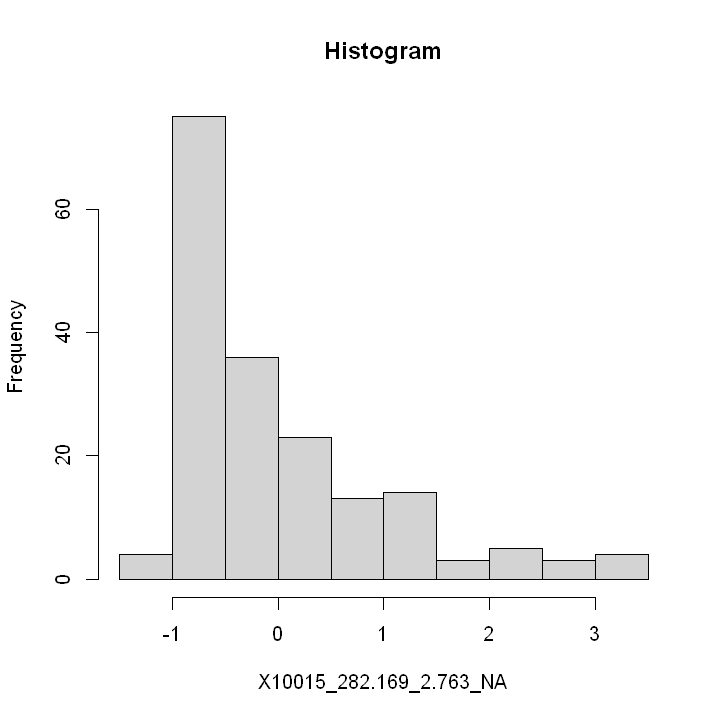

In [135]:
hist(norm_test[,1], xlab=names(norm_test[1]), main="Histogram")

<p style='text-align: justify;'> We can also visualize the same using a quantile-quantile plot (Q-Q plot), which plots the observed sample distribution against a theoretical normal distribution.  For ex: In our case, the length of <code>norm_test[,1]</code> is 180. There are 180 samples (or datapoints) for that particular feature. In a Q-Q plot, we first sort these 180 datapoints and then calculate the quantile for each datapoint. The quantile of a datapoint will describe the number of datapoints that falls under that particular datapoint with respect to total number of datapoints. Then these sample quantiles are plotted against the quantiles obtained using a standard normal distribution. With a Q-Q plot, we can visually see how much a particular feature varies from normality, but it is very subjective. </p>

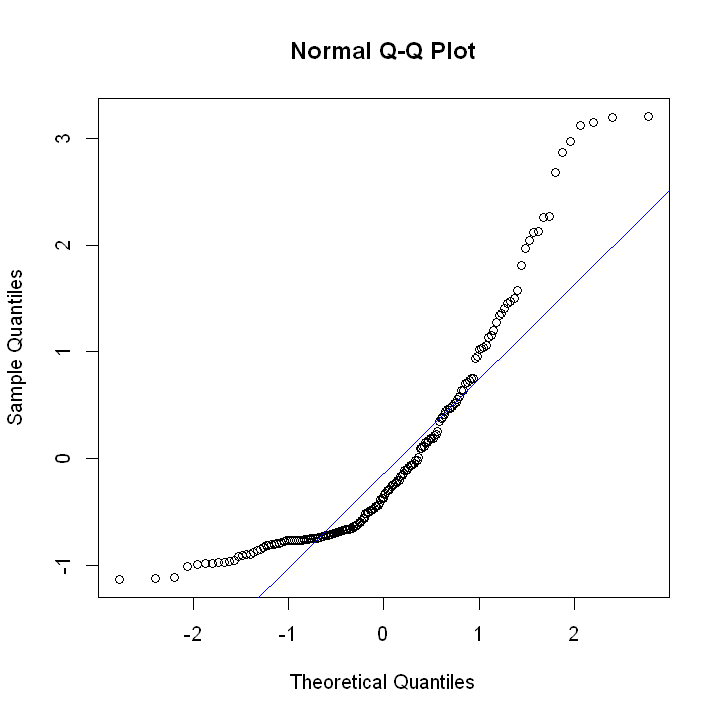

In [136]:
qqnorm(norm_test[,1])
qqline(norm_test[,1], col = "blue") #add the line with theoretic normal distribution

The plot indicates that the particular feature follows a non-normal distribution. We can also perform a Shapiro-Wilk test on this feature to assess the normality. Here, H0 states that the data has a normal distribution. In a Shapiro-Wilk test, when W=1, it means H0 is true. Also, H0=TRUE when p > 0.05. Howver, in most cases, it is common to have W<1. To see how different the observed distribution from the "empirical" normal distribution, we can look at the p-value. 

In [137]:
shapiro.test(norm_test[,1])


	Shapiro-Wilk normality test

data:  norm_test[, 1]
W = 0.83361, p-value = 4.636e-13


In our case, p < 0.05 indicating that the variable follows a non-normal distribution. We can now systematically investigate all metabolite features in the dataset for normality:

We can repeat the same steps and test it on a <b>log-transformed data</b>:

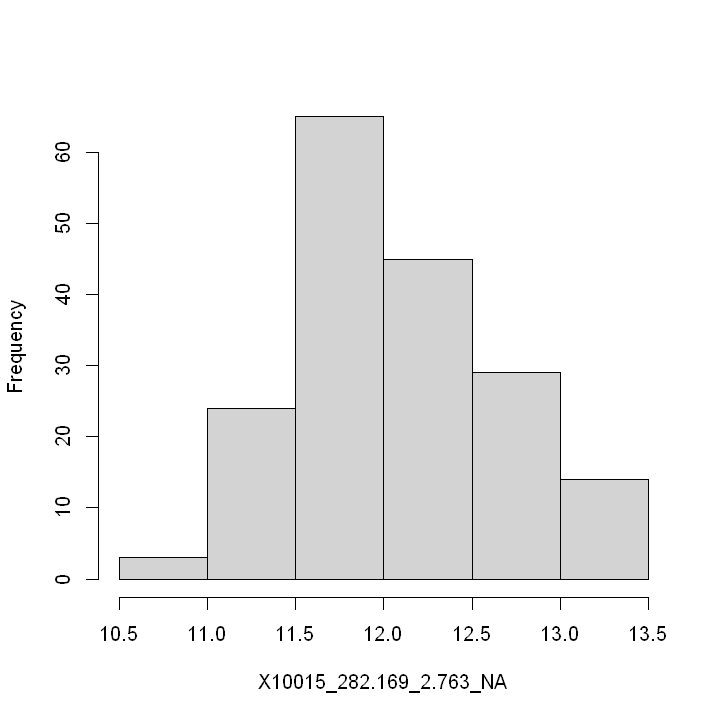

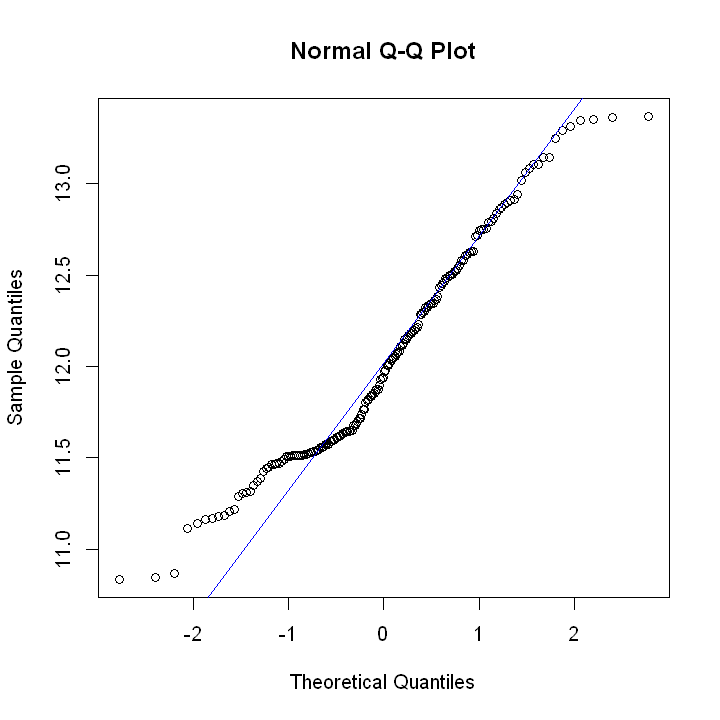

In [138]:
imp_log <- as.data.frame(log(Imp_t)) #log transforming the imputed table

hist(imp_log[,1],xlab=names(imp_log[1]),main=NULL) # histogram of 1st feature

qqnorm(imp_log[,1]) #Q-Q plot of 1st log-transformed feature
qqline(imp_log[,1], col = "blue") #add the line with theoretic normal disribution

In [139]:
shapiro.test(imp_log[,1])


	Shapiro-Wilk normality test

data:  imp_log[, 1]
W = 0.96209, p-value = 8.631e-05


Here, from the qqplot and histogram, one can see that log-transformed data is close to normality than the scaled data that was used before.

### <font color ='darkblue'> Step 54: Normality Testing for All Features </font>

Here, we perform shapiro test on each feature and obtain their p-values. These p-values are then corrected for false discovery rate using BH (Benjamini & Hochberg) correction method. When the significance level of p_adj < 0.05, it rejects H0, thus it will be counted as a non-normal distribution, else it follows normal distribution.

In [140]:
uni_data <- Data %>% select(starts_with("X")) #selecting all the columns starting with X from "Data" 

You can also change the data in the above cell as <code>uni_data <- norm_TIC</code> or <code>uni_data <- norm_pqn</code> to test the normality of normalized features. And, try <code>uni_data <- imp_log</code> to test normality of log-transformed data </font>. This applies for all the univariate tests mentioned below as well. However, keep in mind of which dataset you used for the analysis.

In [141]:
op_shapiro <- uni_data %>% colnames() %>% as.data.frame #getting all the column names into a dataframe called "op_shapiro"
colnames(op_shapiro)[1] <- "Metabolites" #naming the column as "Metabolites"

op_shapiro$p <- sapply(1:ncol(uni_data), function(n){shapiro.test(uni_data[,n])$p}) #performing shapiro test on each feature and getting the p-value as a column 'p'
op_shapiro$p_adj <- p.adjust(op_shapiro$p,method="fdr") #adding a column "p_adj" with corrected p-values. The method used is FDR 
op_shapiro$distribution <- ifelse(op_shapiro$p_adj<0.05,"Non-normal","Normal")

op_shapiro %>% arrange(p) %>% head(n=5) #getting the top-5 p-value metabolites

paste("No.of features with normal distribution:", sum(op_shapiro$distribution=="Normal"))
paste("No.of features with non-normal distribution:", sum(op_shapiro$distribution=="Non-normal"))

,Metabolites,p,p_adj,distribution
,<chr>,<dbl>,<dbl>,<chr>
1,X84985_565.566_10.884_NA,4.371118e-29,9.78941e-27,Non-normal
2,X84649_587.548_10.842_NA,4.461996e-29,9.78941e-27,Non-normal
3,X90897_792.441_12.493_NA,4.506668e-29,9.78941e-27,Non-normal
4,X90643_508.544_12.391_NA,4.534865e-29,9.78941e-27,Non-normal
5,X90847_793.442_12.473_NA,4.599743e-29,9.78941e-27,Non-normal


[1] "No.of features with normal distribution: 54"

[1] "No.of features with non-normal distribution: 9038"

In [144]:
write.csv(op_shapiro, paste0(Sys.Date(),'_Normality_test_results.csv'))

This shows majority of the features have non-normal distribution.  Also, performing shapiro test with log-transformed data shows that 479 features are normally distributed. However, majoity  of them are still not normal. Thus non-parametric tests might make more sense to our data. These normality tests are particularly more useful for small dataset. When your sample size is large, one can still perform the paramteric tests.

---
## ANOVA
<a name="anova"></a>

<p style='text-align: justify;'> We can also perform the parametric test, ANOVA (Analysis of Variance) on our data. Here, we will test whether metabolite levels were different between different sampling sites. Here, the seven different sampling areas will be compared. We  use the function 'aov' to run statistical analyses using ANOVA. ANOVA makes use of variances of different groups to see if they are different from each other. (Variance = SD<sup>2</sup>) </p>
<p style='text-align: justify;'> 
<b>H0 = No differences among the groups (their means or Standard deviations)</b>.Using p-value, one can see if the groups are statistically different from one another. When there is a significant difference, F-ratio, another output of ANOVA will be larger and H0 will be rejected. </p>

$$F-statistic = \frac{\text{between-group variance}}{\text{within groups variance}}$$

Let's see the ANOVA results for the 1st feature vs ATTRIBUTE_Sample_Area:

In [151]:
head(uni_data, 3)

,X10015_282.169_2.763_NA,X10035_325.139_2.817_NA,X10037_216.123_2.847_NA,X10047_338.159_2.845_NA,X10058_280.117_2.961_NA,X10059_414.175_2.851_NA,X10072_305.157_2.851_NA,X10074_283.175_2.851_Spectral Match to Hexaethylene glycol from NIST14,X10078_300.201_2.851_NA,X10082_309.144_2.886_NA,...,X9833_268.175_2.821_NA,X9860_240.144_2.824_NA,X9876_414.139_2.761_NA,X9884_190.05_2.832_NA,X9897_333.144_2.881_NA,X9909_400.16_2.813_NA,X9918_252.123_2.833_NA,X9957_402.139_3.01_NA,X9972_323.123_2.716_NA,X9995_276.159_2.805_NA
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1.1304738,-0.2996871,-0.1117275,2.2186171,-1.452146,-0.17593037,-0.3434611,-0.1778404,-0.1933466,-0.98676658,...,0.50953425,0.3411530,-0.9690079,-0.2136334,-1.0317304,-0.3097998,-0.177995,1.1679223,-0.9536029,-0.720846274
2,-1.1265155,-0.6037355,1.9885898,0.2986375,-1.028317,0.38485813,-0.3749450,-0.1894778,-0.1876122,0.01064504,...,0.09238905,0.5326194,1.0516269,-0.3038794,-0.1930184,-0.7478181,1.252001,0.9551530,-0.9361819,-0.008639177
3,-0.6995949,-0.4612301,-0.3618842,1.2580121,0.747262,-0.05869551,-0.4289946,-0.2615139,-0.2501572,-0.56453788,...,-0.24639335,-0.2865859,4.3836879,-0.6676765,-0.4632050,4.5197644,2.438135,-0.7384554,1.9221174,0.486389335


In [152]:
# Convert "ATTRIBUTE_Sample_Area" to factor
Data$'ATTRIBUTE_Sample_Area' <- as.factor(Data$'ATTRIBUTE_Sample_Area') 

#tidy summarizes the anova ouptut in a  tibble
broom::tidy(aov(uni_data[,1]~Data$'ATTRIBUTE_Sample_Area')) 

term,df,sumsq,meansq,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Data$ATTRIBUTE_Sample_Area,6,7.560749,1.2601248,1.271597,0.2728111
Residuals,173,171.439251,0.9909783,NA,NA


### <font color ='darkblue'>  Step 55: Running ANOVA </font>

We can run ANOVA for each metabolite feature using a for loop and save the output for each feature in a dataframe called 'anova_out'. Here, We run the for loop to pass each feature column as the first argument of the 'aov' function, while the second argument, 'ATTRIBUTE Sample Area', is kept constant.

In [153]:
anova_out=list() # creates an empty list
anova_model=list() # creates an empty list

for(i in 1:ncol(uni_data)) {
  anova_model[[i]] <- aov(uni_data[,i] ~ Data$ATTRIBUTE_Sample_Area) #performing ANOVA and storing the model as a list element in anova_model
  anova_tidy <- broom::tidy(anova_model[[i]]) # summarizing the model output as a tibble using 'tidy'
  result <- anova_tidy[1, ] # getting only the 1st row the tibble
  anova_out <- bind_rows(anova_out, result) # combining all anova outputs
}
anova_out$term <- colnames(uni_data) ##for each row in column'term', give the corresponding name of its feature

anova_out <- arrange(anova_out, p.value) # arranging anova_out by p values
anova_out["p_bonferroni"] <- p.adjust(anova_out$p.value,method="bonferroni") #adding another with bonferroni corrected p-values
anova_out["significant"]  <- ifelse(anova_out$p_bonferroni<0.05,"Significant","Non-significant")

names(anova_model) <- colnames(uni_data) #providing names for each list element

In [154]:
head(anova_out)
dim(anova_out)

term,df,sumsq,meansq,statistic,p.value,p_bonferroni,significant
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
X59188_312.231_7.625_NA,6,102.91774,17.15296,39.00333,9.413695e-30,8.558932e-26,Significant
X33200_260.196_4.886_NA,6,100.31136,16.71856,36.75640,1.649322e-28,1.499563e-24,Significant
X57080_314.247_7.36_NA,6,90.64932,15.10822,29.58350,3.033785e-24,2.758317e-20,Significant
X21870_246.18_3.969_NA,6,87.26696,14.54449,27.42957,7.261726e-23,6.602361e-19,Significant
X80910_243.174_10.41_NA,6,83.80376,13.96729,25.38274,1.655165e-21,1.504876e-17,Significant
X55328_312.232_7.138_NA,6,83.09569,13.84928,24.98246,3.090564e-21,2.809941e-17,Significant


[1] 9092    8

The 'anova_out' dataframe ranks features (metabolites) by significance from most to least and non-significant. However, most features are not annotated here. Annotated features allows us to easily identify the metabolites that are significantly different between groups, and gain insights into their biological relevance.

### <font color ='darkblue'> Step 56: Subsetting Significant Features </font>

In [155]:
anova_sig <- filter(anova_out, significant=="Significant")
anova_sig_names <-anova_sig$term #getting the names of all significant metabolites

In [156]:
display(paste("Total no.of features on which ANOVA test was performed:",nrow(anova_out)))
display(paste("No.of features that showed significant difference:",sum(anova_out$significant=="Significant")))
display(paste("No.of features that did not show significant difference:",sum(anova_out$significant=="Non-significant")))

[1] "Total no.of features on which ANOVA test was performed: 9092"

[1] "No.of features that showed significant difference: 1554"

[1] "No.of features that did not show significant difference: 7538"

These significant features show a significant difference among the different sampling areas. These features can be further investigated with (tukey) post-hoc analysis shown in next section.

### <font color ='darkblue'> Step 57: Visualize ANOVA Results </font>

<p style='text-align: justify;'> The 'anova_out' results are sorted after the p value. To see if there any significant findings, we will use ggplot to visualize results from the ANOVA, with log(F-Statistic values) on the x-axis and -log(p) on the y-axis. Using 'geom_text_repel', one can make sure the labels of these features are not overlapping. </p>

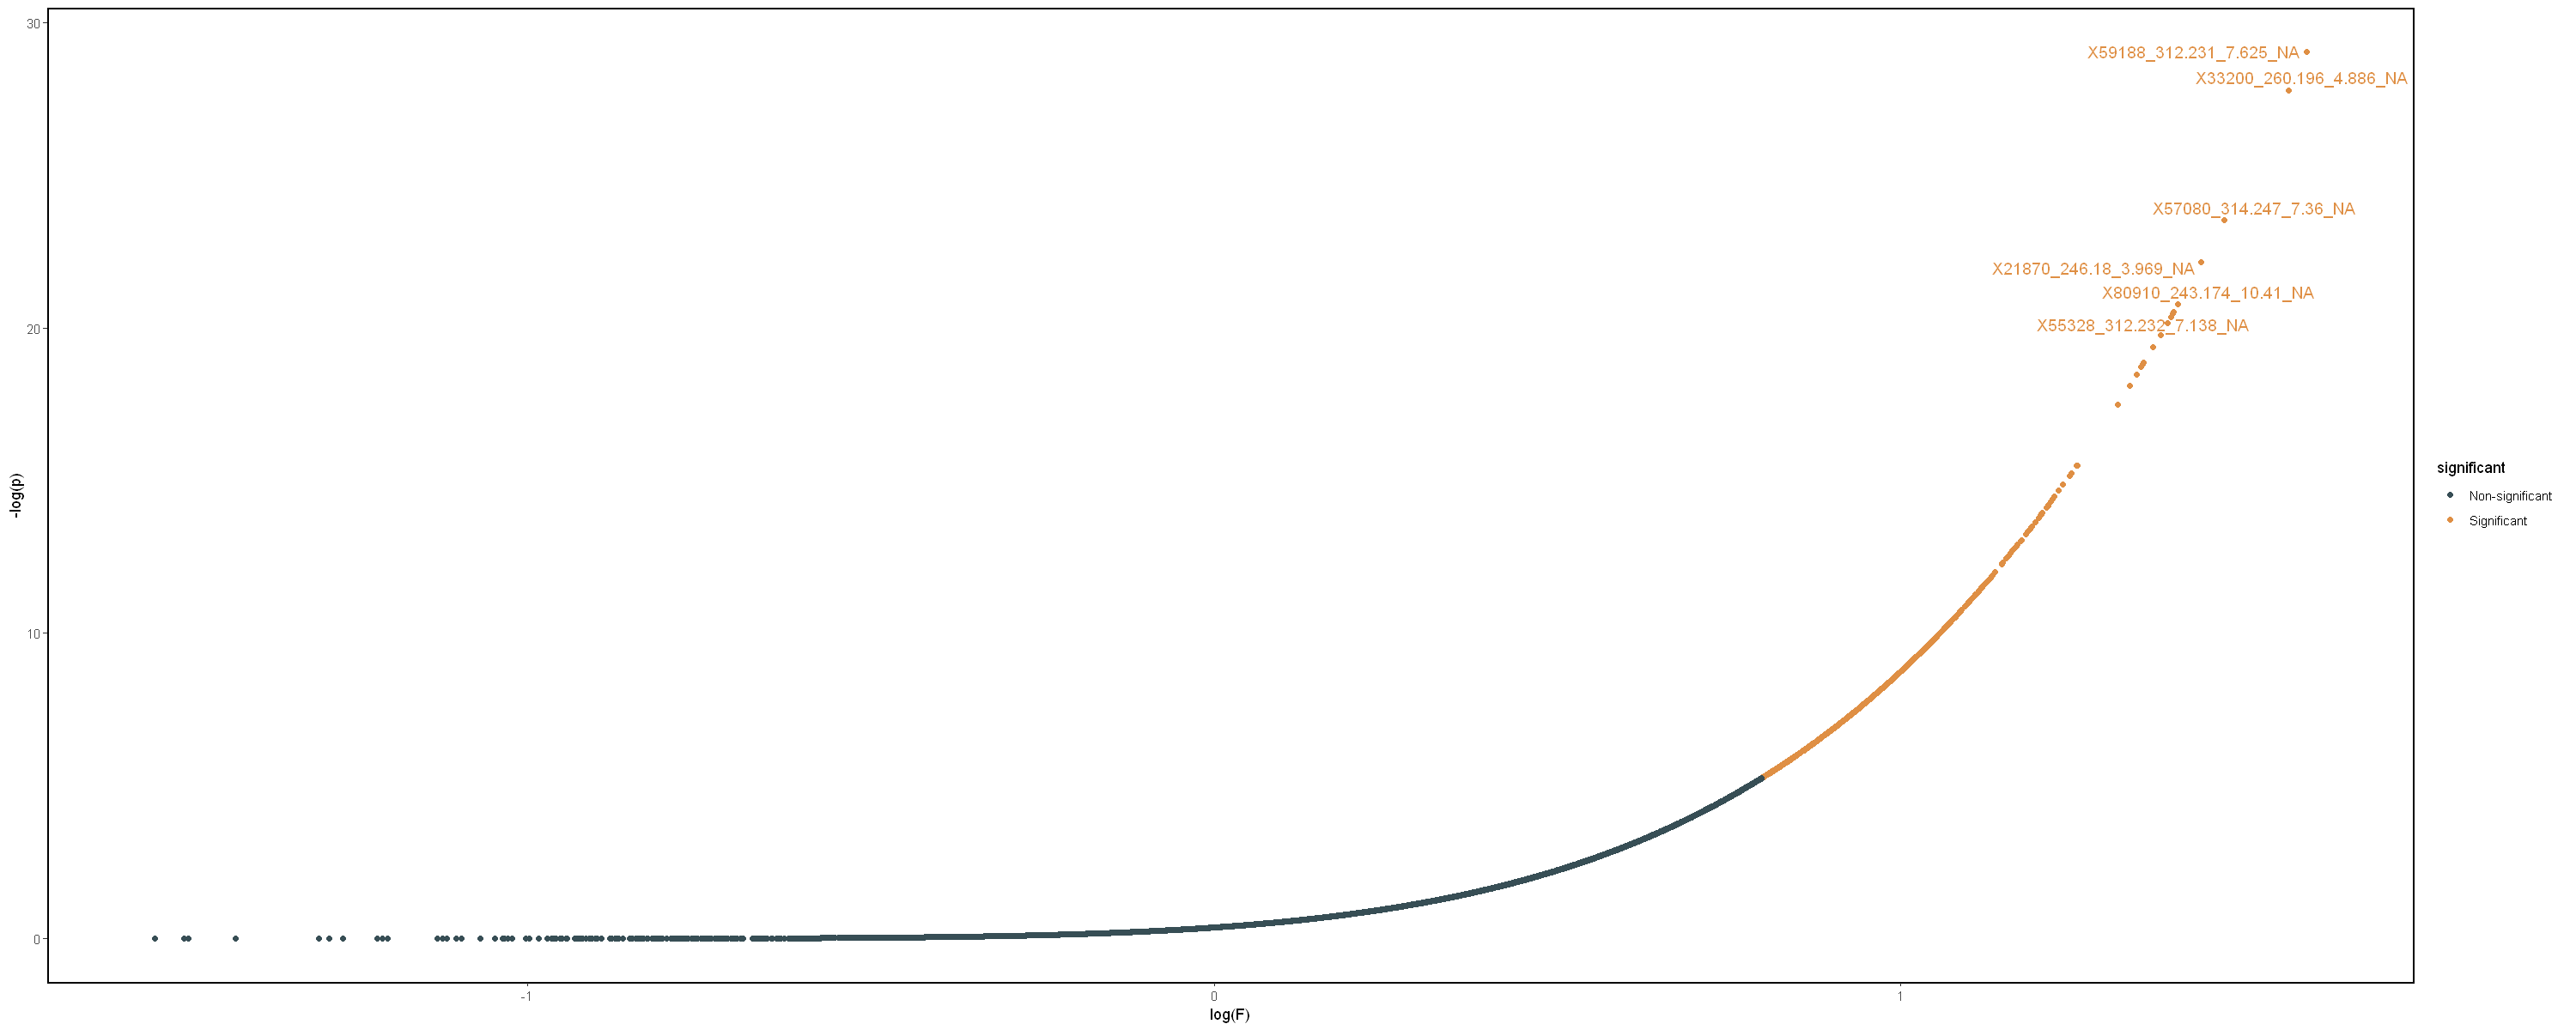

In [157]:
#plot ANOVA results
plot_anova <- ggplot(anova_out,aes(x = log(statistic,base=10), y = -log(p.value,base=10), color = significant)) + 
              geom_point() + 
              theme_classic() + 
              scale_color_jama() + 
              ylab("-log(p)") + 
              xlab("log(F)") +
              ggrepel::geom_text_repel(data=head(anova_out), # showing the top 6 features
                                       aes(label=term),
                                       size=4,
                                       show.legend = FALSE, max.overlaps = 100) +
              theme(panel.background = element_blank(), #making the ggplot background white
                    panel.border = element_rect(colour = "black", fill=NA, linewidth=1)) # giving a rectangle black border

plot_anova

<p style='text-align: justify;'>The ANOVA only tests if the between-group variance is larger than the within-group variance. Thus, results only show you whether there are groupwise differences in metabolite levels, but do not show you which pair-wise group comparison are driving this difference. This can be furhter explored using Tukey's Honest Significant Difference.</p>

In [158]:
# to export as svg
svglite("plot_ANOVA.svg", width=10, height=8, bg='white')
plot_anova
dev.off()

png 
  2

In [159]:
#to export as png
png("plot_ANOVA.png", width = 400, height = 300, units='mm', res = 300)
plot_anova
dev.off()

png 
  2

In [160]:
# write the output as a csv file
write.csv(anova_out,"ANOVA_results.csv")

### <font color ='darkblue'> Step 58: Visualize Top Significant Metabolites </font> 

In [161]:
b <- list() # creating an empty list to store the boxplot of each metabolite as an element [[i]]
for(i in 1:4){
    b[[i]] <- ggplot(Data,aes(x=ATTRIBUTE_Sample_Area,
                              y=Data[,(anova_sig_names[i])], # this will get the corresponding column from the dataframe 'Data'
                              color=ATTRIBUTE_Sample_Area))+
    geom_boxplot() + 
    scale_color_jama() +  # specifying the 'journal-friendly' color palette
    labs(x='ATTRIBUTE Sample Area',y=as.character(anova_sig_names[i])) + #labelling the axes
    theme_classic() + # white background theme
    geom_jitter() + #adds some random variation to each point location to avoid overfitting
    theme(axis.text.x= element_blank()) #removing the x axis labels for each boxplot in a plot
}

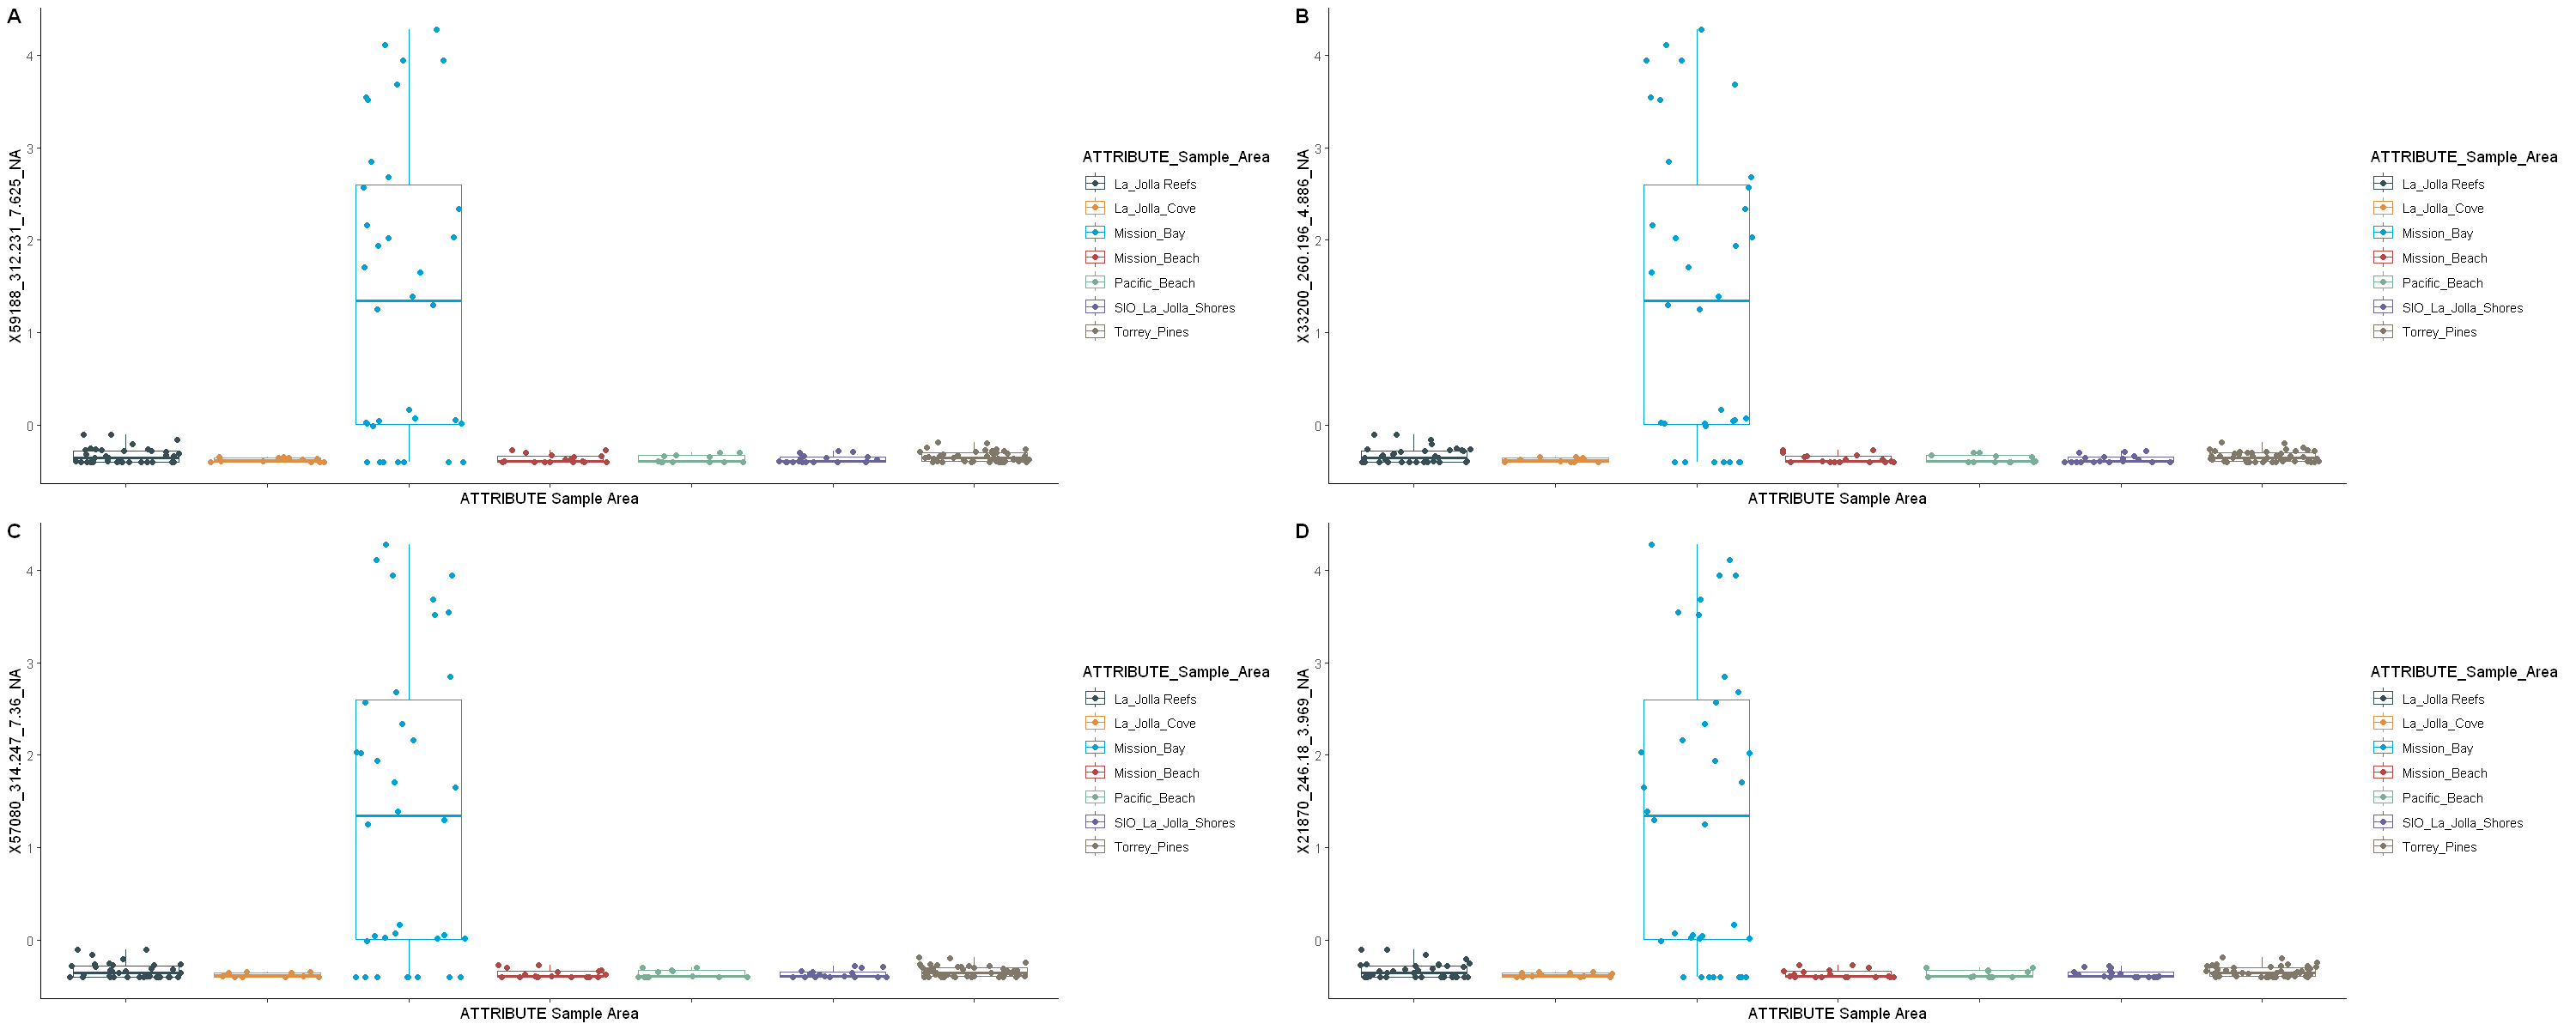

In [162]:
combined_boxplots <- plot_grid(b[[1]],b[[2]],b[[3]],b[[4]], labels = c('A','B','C','D'))
combined_boxplots

Write boxplot of top 4 metabolites to pdf

In [163]:
ggsave("combined_boxplots.pdf",combined_boxplots, height = 9,width = 16)

For the top four metabolites, Mission bay is the area that drives the difference between sampling sites, with much higher levels. 

---
## Tukey's post-hoc test
<a name ="tukey"></a>

As mentioned above, Tukey's post hoc test is a common post-hoc test after a 1-way anova. It also assumes the data to be normally distributed and homoscedastic (having same variances). One we know that there is a significant difference among different sampling sites, we can use tukey-test to calculate, which features show statistically significant differences between 2 sampling sites. 

In [164]:
#looking at one of the anova model that showed significant difference
model_1 <- anova_model[[anova_sig_names[1]]] 
broom::tidy(model_1)

term,df,sumsq,meansq,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Data$ATTRIBUTE_Sample_Area,6,102.91774,17.1529568,39.00333,9.413695e-30
Residuals,173,76.08226,0.4397818,NA,NA


### <font color ='darkblue'> Step 59: Perform Tukey HSD for a Significant Feature </font>

In [165]:
broom::tidy(TukeyHSD(model_1)) # Perform Tukey HSD test on the model_1 and summarize the result

term,contrast,null.value,estimate,conf.low,conf.high,adj.p.value
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Data$ATTRIBUTE_Sample_Area,La_Jolla_Cove-La_Jolla Reefs,0,-0.0146107707,-0.6740913,0.6448698,1.000000e+00
Data$ATTRIBUTE_Sample_Area,Mission_Bay-La_Jolla Reefs,0,1.9009769489,1.4346538,2.3673001,0.000000e+00
Data$ATTRIBUTE_Sample_Area,Mission_Beach-La_Jolla Reefs,0,-0.0134035939,-0.5845305,0.5577233,1.000000e+00
Data$ATTRIBUTE_Sample_Area,Pacific_Beach-La_Jolla Reefs,0,0.0642958118,-0.5951848,0.7237764,9.999494e-01
Data$ATTRIBUTE_Sample_Area,SIO_La_Jolla_Shores-La_Jolla Reefs,0,-0.0132175276,-0.5843445,0.5579094,1.000000e+00
Data$ATTRIBUTE_Sample_Area,Torrey_Pines-La_Jolla Reefs,0,0.0317892050,-0.4044162,0.4679946,9.999910e-01
Data$ATTRIBUTE_Sample_Area,Mission_Bay-La_Jolla_Cove,0,1.9155877196,1.2561071,2.5750683,1.142419e-13
Data$ATTRIBUTE_Sample_Area,Mission_Beach-La_Jolla_Cove,0,0.0012071769,-0.7361145,0.7385289,1.000000e+00
Data$ATTRIBUTE_Sample_Area,Pacific_Beach-La_Jolla_Cove,0,0.0789065825,-0.7287889,0.8866020,9.999488e-01


According to the TukeyHSD function description:
- term: shows the regression model.
- contrast: shows the levels that are compared.
- estimate: The estimated difference between the means of the contrast groups.
- null.value: Value to which the estimate is compared.
- adj.p.value: P-value adjusted for multiple comparisons.
- conf.high: Upper bound on the confidence interval for the estimate.
- conf.low: Lower bound on the confidence interval for the estimate.

Here, every possible pair-wise group difference is explored. From ANOVA results, since Mission Bay seemed to differ from other sampling sites for the four most significant metabolites, we could specifically look at the results from comparison between Mission Bay and another sampling site. 

### <font color ='darkblue'> Step 60: Perform Tukey HSD for All Significant Features</font>

In the code below, we look at the differences between <b> Mission Bay and La Jolla Reefs</b>. We take the anova models that shows significant difference among samplig sites and perform tukey test on only those models. 

<font color="red">If you want to look at some other comparison, you can change it in the next cell, in the line:
    <br/> `result <- filter(tukey_tidy, contrast == 'Mission_Bay-La_Jolla Reefs')` </font>. This comparsion information given as 'contrast' can be simply copied from the output datframe of previous cell `broom::tidy(TukeyHSD(model_1))` and pasted in the cell below.

In [166]:
output_tukey <- NULL
for(i in anova_sig_names) {
  tukey_tidy <- broom::tidy(TukeyHSD(anova_model[[i]])) # Perform Tukey HSD test on the model & summarize the result

  # Combine all Tukey results
  result <- filter(tukey_tidy, contrast == 'Mission_Bay-La_Jolla Reefs') # subsetting that particular comparison
  result$term <- i #giving the rowname as the name of its feature
  output_tukey <- bind_rows(output_tukey, result) #combine outputs from all features
}

In [168]:
output_tukey["p_bonferroni"] <- p.adjust(output_tukey$adj.p.value,method="bonferroni")
output_tukey["significant"] <- ifelse(output_tukey$p_bonferroni<0.05,"Significant","Nonsignificant")
output_tukey <- arrange(output_tukey, adj.p.value) # arranging anova_out by p_bonferroni values

Display the top results. Any significant findings? Other impressions?

In [169]:
head(output_tukey,5)

term,contrast,null.value,estimate,conf.low,conf.high,adj.p.value,p_bonferroni,significant
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
X59188_312.231_7.625_NA,Mission_Bay-La_Jolla Reefs,0,1.900977,1.434654,2.367300,0.000000e+00,0.000000e+00,Significant
X33200_260.196_4.886_NA,Mission_Bay-La_Jolla Reefs,0,1.829682,1.355439,2.303926,0.000000e+00,0.000000e+00,Significant
X57080_314.247_7.36_NA,Mission_Bay-La_Jolla Reefs,0,1.777045,1.274528,2.279561,3.275158e-14,5.089595e-11,Significant
X55328_312.232_7.138_NA,Mission_Bay-La_Jolla Reefs,0,1.703309,1.179752,2.226867,4.274359e-14,6.642353e-11,Significant
X21870_246.18_3.969_NA,Mission_Bay-La_Jolla Reefs,0,1.719871,1.207826,2.231916,4.496403e-14,6.987411e-11,Significant


### <font color ='darkblue'> Step 61: Count Significant Features </font>

In [170]:
display(paste("Total no.of features on which tukey test was performed:",nrow(output_tukey)))
display(paste("No.of features that showed significant difference between",output_tukey$contrast[1],":",sum(output_tukey$significant=="Significant")))
display(paste("No.of features that did not show significant difference between",output_tukey$contrast[1],":",sum(output_tukey$significant=="Nonsignificant")))

[1] "Total no.of features on which tukey test was performed: 1554"

[1] "No.of features that showed significant difference between Mission_Bay-La_Jolla Reefs : 1258"

[1] "No.of features that did not show significant difference between Mission_Bay-La_Jolla Reefs : 296"

### <font color ='darkblue'> Step 62: Visualize Results with a Volcano Plot </font>

Create a volcano plot that displays -log(adj.p.value) on the y-axis and group-difference ('estimate') on the x-axis and display names of top findings in the plot.

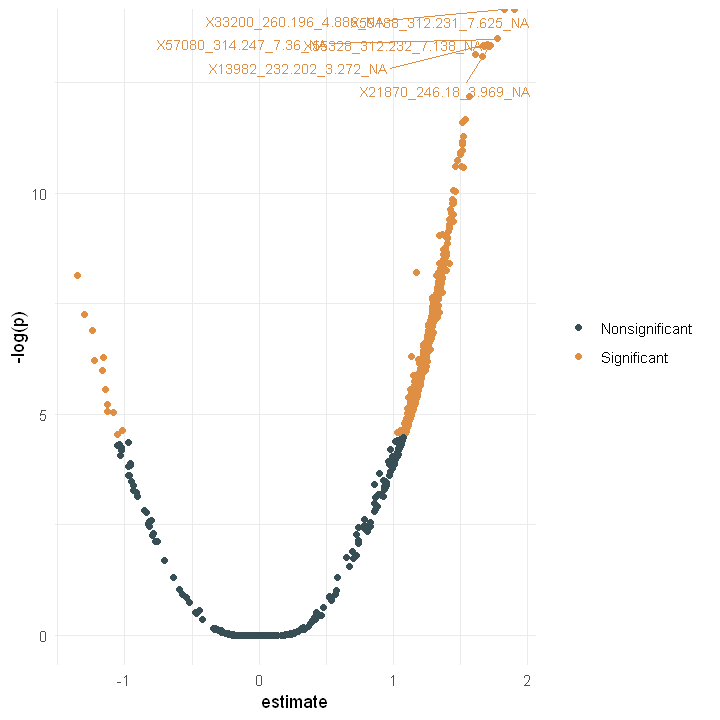

In [174]:
plot_tukey <- ggplot(output_tukey,aes(x=estimate,y=-log(adj.p.value,base=10),color=significant)) + 
  geom_point() + 
  theme_minimal() + 
  scale_color_jama() + 
  ylab("-log(p)") +
  ggrepel::geom_text_repel(data=head(output_tukey),aes(label=term),size=3, show.legend = F, max.overlaps = 100) +
  theme(legend.title = element_blank())            

plot_tukey

Export the plot as a pdf-file and the output as a csv.

In [172]:
svglite("TukeyHSD_MissionBayLaJollaReefs.svg", width=10, height=10, bg='white')
plot_tukey
dev.off()

png 
  2

In [175]:
png("TukeyHSD_MissionBayLaJollaReefs.png", width=300, height=300, bg='white', units='mm', res = 300)
plot_tukey
dev.off()

png 
  2

In [170]:
write.csv(output_tukey,"TukeyHSD_output_MissionBay_LaJollaReefs.csv")

---
## T-test
<a name = "t_test"></a>

A T-test is commonly used when one has to compare between only two groups. Here, null hypothesis H0 states no difference between the mean of 2 groups. Similar to the F-statistic used by ANOVA, T-tests use T-statistic.

$$\text{T-statistic} = \frac{\text{Mean}_{\text{group}} - \text{Mean}_{\text{population}}}{\text{SD}_{\text{group}} / \sqrt{\text{group size}}}$$

In our dataset, a heavy rainfall in January 2018 could have influenced the metabolome. We will investigate the effect of the rainfall using t-tests. The 2 conditions will be 'Jan-2018' or 'not Jan-2018'

In [176]:
#add a column 'rainfall' to Data
Data <- Data %>% add_column(ATTRIBUTE_rainfall=ifelse(Data$ATTRIBUTE_Month=="Jan",1,0),
                            .before = 10) # position this ATTRIBUTE column before the 10th column in'Data'

In [177]:
#showing t-test result for 1st feature
t.test(uni_data[,1]~Data$ATTRIBUTE_rainfall) 


	Welch Two Sample t-test

data:  uni_data[, 1] by Data$ATTRIBUTE_rainfall
t = -1.6465, df = 81.795, p-value = 0.1035
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -0.66534135  0.06274266
sample estimates:
mean in group 0 mean in group 1 
     -0.1004331       0.2008662 


### <font color ='darkblue'> Step 63: Perform T-Test </font>

Showing t-test for all features

In [178]:
rain_out <- data.frame()
for (i in 1:ncol(uni_data)){
    model <- t.test(uni_data[,i] ~ Data$ATTRIBUTE_rainfall) #perform t-test for each feature against rainfall
    t_tidy <- broom::tidy(model)
    rain_out <- bind_rows(rain_out, t_tidy) #combine outputs from all features
}

rownames(rain_out) <- colnames(uni_data) # naming each row with feature name

rain_out <- arrange(rain_out, p.value) # arranging rain_out by p values
rain_out["p_bonferroni"] <- p.adjust(rain_out$p.value,method="bonferroni")
rain_out["significant"] <- ifelse(rain_out$p_bonferroni<0.05,"Significant","Nonsignificant")

In [179]:
head(rain_out,3)

,estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative,p_bonferroni,significant
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
X2716_252.123_1.231_NA,-1.925634,-0.6418780,1.283756,-36.58884,1.698330e-84,177.1242,-2.029494,-1.821773,Welch Two Sample t-test,two.sided,1.544122e-80,Significant
X4504_301.175_2.04_NA,-1.950350,-0.6501167,1.300233,-37.12209,7.507471e-84,171.3667,-2.054057,-1.846644,Welch Two Sample t-test,two.sided,6.825793e-80,Significant
X61401_256.19_7.915_NA,-1.981327,-0.6604424,1.320885,-34.80403,1.838910e-61,110.7469,-2.094137,-1.868518,Welch Two Sample t-test,two.sided,1.671937e-57,Significant


Here,in our example, Estimate 1: Mean before rain. Estimate 2: Mean after rain. 

### <font color ='darkblue'> Step 64: Plot T-Test Results </font>

In [180]:
volcano_rainfall <- ggplot(rain_out,aes(x=estimate,y=-log(p.value,base=10),color=significant)) +
  geom_point() +
  theme_classic() +
  scale_color_jama() +
  geom_vline(xintercept = 0, linetype="dashed") +
  xlab("Beta") +
  ylab("-log(p)") +
  theme(legend.title = element_blank()) +
  ggrepel::geom_text_repel(data=head(rain_out), aes(label=rownames(rain_out)[1:6]), size=3, show.legend = F, max.overlaps = 100)

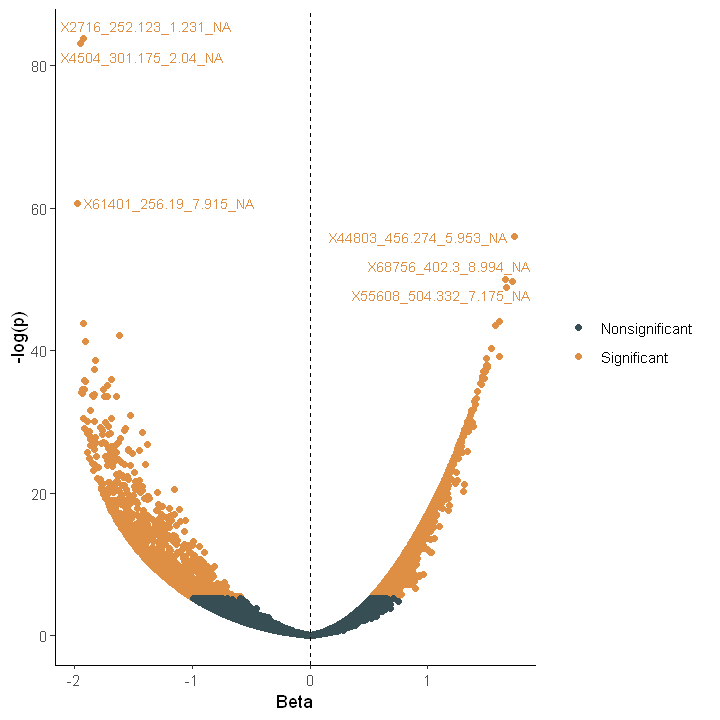

In [181]:
volcano_rainfall

In [182]:
write.csv(rain_out,"rainfall_t_test.csv")
ggsave("volcano_plot_rainfall.pdf",volcano_rainfall)

Saving 6.67 x 6.67 in image


---
## Kruskal-Wallis Test
<a name="kr_wallis"></a>

Kruskal-Wallis Test is a non-parametric version of ANOVA. Here, the test does not assume normality of the data. The median of multiple groups are compared to see if they are statistically different from one another. The null hypothesis H0 states no significant difference among different groups. Based on the p value, we decide whether to reject H0 or not. When H0 is rejected, the alternate hypothesis H1 states that atleast one group is statistically different from the others.
<a href="https://statsandr.com/blog/kruskal-wallis-test-nonparametric-version-anova/#introduction">Read more about Kruskal-Wallis test</a>

### <font color ='darkblue'> Step 65: Perform Kruskal-Wallis Test on the first feature </font>
Similar to its parametric counterpart,ANOVA, we tried to perfom Kruskal-Wallis test across different sample areas.

In [183]:
broom::tidy(kruskal.test(uni_data[,1] ~ Data$'ATTRIBUTE_Sample_Area'))

statistic,p.value,parameter,method
<dbl>,<dbl>,<int>,<chr>
6.007019,0.4224043,6,Kruskal-Wallis rank sum test


### <font color ='darkblue'>  Step 66: Run Kruskal-Wallis Test for All Features </font>

In [184]:
kruskall_out <- data.frame()
for (i in 1:ncol(uni_data)){
    kw_model <- broom::tidy(kruskal.test(uni_data[,i] ~ Data$'ATTRIBUTE_Sample_Area')) #perform Kruskall Wallis for each feature against sample area
    kruskall_out <- bind_rows(kruskall_out, kw_model) #combine outputs from all features
}

rownames(kruskall_out) <- colnames(uni_data) # naming each row with feature name

kruskall_out <- arrange(kruskall_out, p.value) # arranging rain_out by p values
kruskall_out["p_bonferroni"] <- p.adjust(kruskall_out$p.value,method="bonferroni")
kruskall_out["significant"] <- ifelse(kruskall_out$p_bonferroni<0.05,"Significant","Nonsignificant")

In [185]:
head(kruskall_out,3)

,statistic,p.value,parameter,method,p_bonferroni,significant
,<dbl>,<dbl>,<int>,<chr>,<dbl>,<chr>
X91372_906.258_12.697_NA,112.2322,6.945518e-22,6,Kruskal-Wallis rank sum test,6.314865e-18,Significant
X91133_907.259_12.628_NA,109.2861,2.875768e-21,6,Kruskal-Wallis rank sum test,2.614649e-17,Significant
X90743_908.258_12.555_NA,109.2668,2.902660e-21,6,Kruskal-Wallis rank sum test,2.639098e-17,Significant


In [188]:
write.csv(kruskall_out,"kruskall-wallis_output.csv")

### <font color ='darkblue'>  Step 67: Filter Significant Features </font>

In [190]:
display(paste("Total no.of features on which Kruskal test was performed:",nrow(kruskall_out)))
display(paste("No.of features that showed significant difference:",sum(kruskall_out$significant=="Significant")))
display(paste("No.of features that did not show significant difference:",sum(kruskall_out$significant=="Nonsignificant")))

[1] "Total no.of features on which Kruskal test was performed: 9092"

[1] "No.of features that showed significant difference: 151"

[1] "No.of features that did not show significant difference: 8941"

In [191]:
kw_sig_names <- kruskall_out%>% filter(significant=="Significant") %>% rownames(.) #getting the rownames of significant features from KW output
length(kw_sig_names)

[1] 151

### <font color ='darkblue'> Step 68: Compare Results from ANOVA and Kruskal-Wallis </font>

We can also compare the results of ANOVA and Kruskal-Wallis to see if the answers are correlating. 

In [192]:
#combining anova and kruskal-wallis outputs:
AOV_KW <- kruskall_out #taking krusall-wallis output in a new variable "AOV_KW"
colnames(AOV_KW) <- paste0('KW_',colnames(AOV_KW)) #renaming the column names with a prefix 'KW'
AOV_KW <- merge(anova_out,AOV_KW, by.x="term", by.y=0) # merging anova output with AOV_KW 
AOV_KW <- arrange(AOV_KW,p.value) # arranging by p value

In [193]:
head(AOV_KW,3)
dim(AOV_KW)

,term,df,sumsq,meansq,statistic,p.value,p_bonferroni,significant,KW_statistic,KW_p.value,KW_parameter,KW_method,KW_p_bonferroni,KW_significant
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<chr>
1,X59188_312.231_7.625_NA,6,102.91774,17.15296,39.00333,9.413695e-30,8.558932e-26,Significant,65.59017,3.268380e-12,6,Kruskal-Wallis rank sum test,2.971612e-08,Significant
2,X33200_260.196_4.886_NA,6,100.31136,16.71856,36.75640,1.649322e-28,1.499563e-24,Significant,41.40176,2.413061e-07,6,Kruskal-Wallis rank sum test,2.193955e-03,Significant
3,X57080_314.247_7.36_NA,6,90.64932,15.10822,29.58350,3.033785e-24,2.758317e-20,Significant,61.62328,2.104966e-11,6,Kruskal-Wallis rank sum test,1.913835e-07,Significant


[1] 9092   14

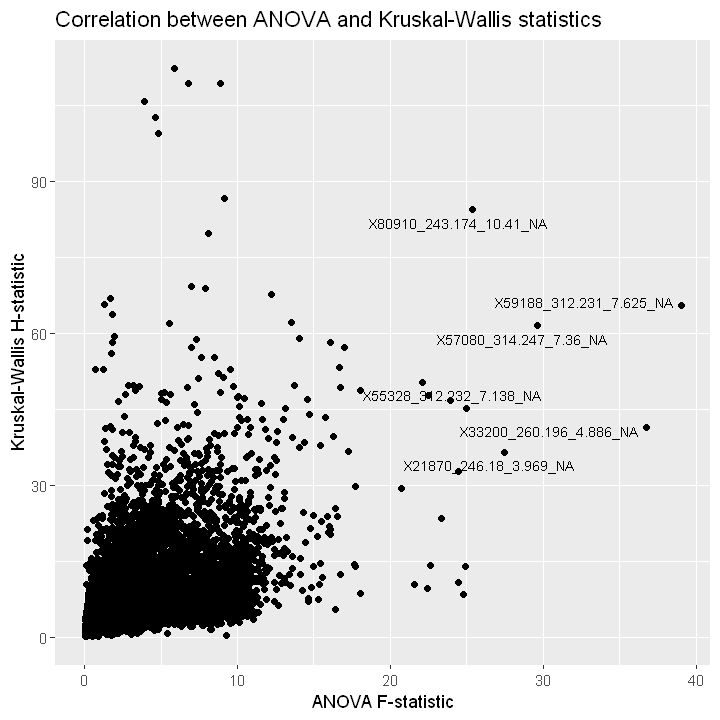

In [196]:
correlation_plot <- ggplot(AOV_KW,aes(x=statistic, y=KW_statistic)) + 
    labs(x="ANOVA F-statistic", y="Kruskal-Wallis H-statistic", title="Correlation between ANOVA and Kruskal-Wallis statistics") +
    geom_point() +
    ggrepel::geom_text_repel(data=head(AOV_KW), aes(label=term), size=3, show.legend = F, max.overlaps = 100)

correlation_plot

In [197]:
ggsave("correlation_ANOVA_kruskal-Wallis.svg",correlation_plot)

Saving 6.67 x 6.67 in image


A higher score for a particular feature in both axes indicates that both tests, ANOVA and Kruskal-Wallis, rejected the null-hypothesis. Thus those features are significantly different among different groups.

In [198]:
cor(AOV_KW$statistic,AOV_KW$KW_statistic,method="spearman")

[1] 0.5781331

Spearman correlation between the test-statistics of these 2 methods (ANOVA and Kruskal-Wallis) shows that around 58% of the results tend to agree the same in both cases.

---
## Dunn's post hoc test
<a name ="dunn"></a>
If Kruskal_Wallis test shows there is a significant difference among groups, then we can perform post-hoc test. The most common post-hoc test for Kruskal-Wallis is "Dunn Test" where one can perform multiple pairwise comparison to know exactly which groups are significantly different.
Here, in our example, we use Dunn test to calculate, which features show statistically significant differences between individual sampling sites. 

### <font color ='darkblue'> Step 69: Perform Dunn Test for a Significant Feature </font>

In [199]:
#Performing Dunn Test on the first significant feature of Kruskal Wallis output
dunnTest_model <- dunnTest(uni_data[,kw_sig_names[1]], 
                           Data$`ATTRIBUTE_Sample_Area`, 
                           method="bonferroni")

In [200]:
dunnTest_model$res

Comparison,Z,P.unadj,P.adj
<chr>,<dbl>,<dbl>,<dbl>
La_Jolla Reefs - La_Jolla_Cove,2.15269042,3.134302e-02,6.582034e-01
La_Jolla Reefs - Mission_Bay,0.43200113,6.657406e-01,1.000000e+00
La_Jolla_Cove - Mission_Bay,-1.84721949,6.471534e-02,1.000000e+00
La_Jolla Reefs - Mission_Beach,0.99539316,3.195451e-01,1.000000e+00
La_Jolla_Cove - Mission_Beach,-1.15439662,2.483376e-01,1.000000e+00
Mission_Bay - Mission_Beach,0.64266571,5.204410e-01,1.000000e+00
La_Jolla Reefs - Pacific_Beach,0.36304660,7.165701e-01,1.000000e+00
La_Jolla_Cove - Pacific_Beach,-1.46123806,1.439501e-01,1.000000e+00
Mission_Bay - Pacific_Beach,0.05757567,9.540866e-01,1.000000e+00


### <font color ='darkblue'> Step 70: Perform Dunn Test for All Significant Features</font>

In [201]:
dunn_out <- NULL
for (i in kw_sig_names){
    dunn_out[[i]] <- dunnTest(uni_data[,i] ~ Data$'ATTRIBUTE_Sample_Area',method="bonferroni") #perform dunn-test on Kruskal test's significant features against sample area
}
names(dunn_out) <- kw_sig_names
length(dunn_out)

[1] 151

Here, we perform Dunn test for features that showed significant difference in Kruskal-Wallis test and pick only the pairwise comparison between 'La Jolla Reefs' and 'Mission Bay'. <br>
<font color ="red"> To look at some other comparison, change it in the next cell: <br/>
</font>`result <- filter(dunn_out[[i]]$res, Comparison == 'La_Jolla Reefs - Mission_Bay')`. 
The **'Comparison'** can be simply copied from the output datframe of <code>dunnTest_model$res</code> and pasted in the cell below. 

In [202]:
#combining all dunn test results of 'La_Jolla Reefs - Mission_Bay':

dunn_ML <- data.frame() #empty dataframe for dunn test between Mission-Bay and La Jolla Reefs

for (i in 1:length(dunn_out)){
    result <- filter(dunn_out[[i]]$res, Comparison == 'La_Jolla Reefs - Mission_Bay') # subsetting that particular comparison
    rownames(result) <- kw_sig_names[i] # naming each row with feature name
    dunn_ML <- bind_rows(dunn_ML, result) #combine outputs from all features
}
 
dunn_ML <- arrange(dunn_ML, P.adj) # arranging dunn_out by p values
dunn_ML["p_bonferroni"] <- p.adjust(dunn_ML$P.adj, method="bonferroni") #p adj for bonferroni
dunn_ML["significant"] <- ifelse(dunn_ML$p_bonferroni<0.05,"Significant","Nonsignificant")

In [203]:
head(dunn_ML)

,Comparison,Z,P.unadj,P.adj,p_bonferroni,significant
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
X57080_314.247_7.36_NA,La_Jolla Reefs - Mission_Bay,-6.790999,1.113600e-11,2.338561e-10,3.531227e-08,Significant
X60583_506.326_7.811_NA,La_Jolla Reefs - Mission_Bay,-6.600999,4.083970e-11,8.576338e-10,1.295027e-07,Significant
X59188_312.231_7.625_NA,La_Jolla Reefs - Mission_Bay,-6.468715,9.884002e-11,2.075640e-09,3.134217e-07,Significant
X82124_413.268_10.607_NA,La_Jolla Reefs - Mission_Bay,-6.194994,5.828737e-10,1.224035e-08,1.848293e-06,Significant
X54129_381.808_6.99_NA,La_Jolla Reefs - Mission_Bay,-5.919286,3.233425e-09,6.790193e-08,1.025319e-05,Significant
X36504_214.191_5.227_NA,La_Jolla Reefs - Mission_Bay,-5.916814,3.282376e-09,6.892989e-08,1.040841e-05,Significant


### <font color ='darkblue'> Step 71: Count Significant Features </font>

In [204]:
display(paste("Total no.of features on which Dunn test was performed:",length(dunn_out)))
display(paste("No.of features that showed significant difference between",dunn_ML$Comparison[1],":",sum(dunn_ML$significant=="Significant")))
display(paste("No.of features that did not show significant difference between",dunn_ML$Comparison[1],":",sum(dunn_ML$significant=="Nonsignificant")))

[1] "Total no.of features on which Dunn test was performed: 151"

[1] "No.of features that showed significant difference between La_Jolla Reefs - Mission_Bay : 49"

[1] "No.of features that did not show significant difference between La_Jolla Reefs - Mission_Bay : 102"

### <font color ='darkblue'> Step 72: Visualize Results with a Volcano Plot </font>

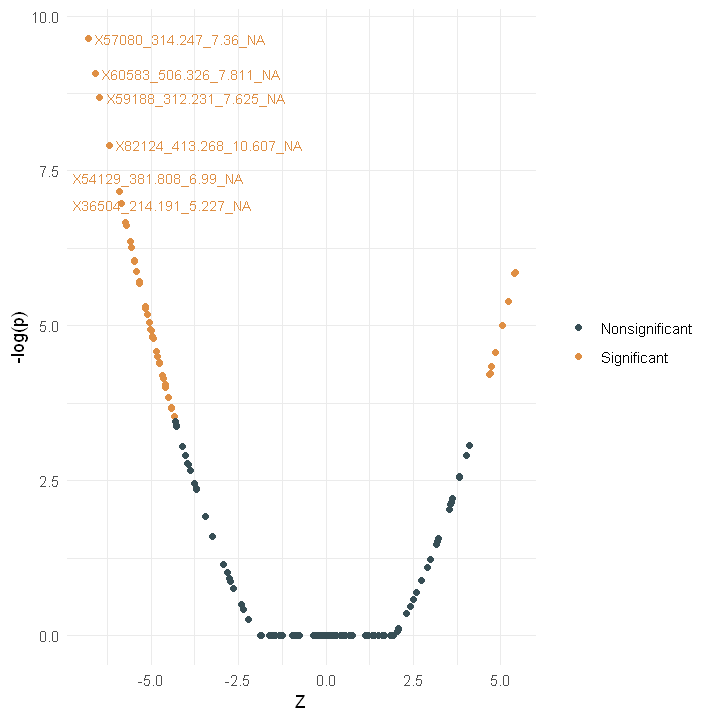

In [205]:
plot_dunn <- ggplot(dunn_ML, aes(x=Z, y=-log(P.adj, base=10), color=significant)) + 
  geom_point() + 
  theme_minimal() + 
  scale_color_jama()+ ylab("-log(p)") +
  ggrepel::geom_text_repel(data = head(dunn_ML), #labelling the top 6 features
                  aes(label = rownames(head(dunn_ML))), size = 3, show.legend = FALSE, max.overlaps = 100) +
  theme(legend.title = element_blank())

plot_dunn

In [206]:
write.csv(dunn_ML,"dunnTest_MissionBay_LaJollaReefs.csv")
ggsave("volcano_plot_dunnTest.svg", plot_dunn)

Saving 6.67 x 6.67 in image


# <font color = 'blue'>  7. Conclusion </font>
<a name="outro"></a>

In [208]:
sessionInfo() # to see all the information about the current R session

R version 4.1.3 (2022-03-10)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 22621)

Matrix products: default

locale:
[1] LC_COLLATE=English_United Kingdom.1252 
[2] LC_CTYPE=English_United Kingdom.1252   
[3] LC_MONETARY=English_United Kingdom.1252
[4] LC_NUMERIC=C                           
[5] LC_TIME=English_United Kingdom.1252    

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] cowplot_1.1.1         FSA_0.9.4             ggsci_3.0.0          
 [4] matrixStats_0.63.0    rfPermute_2.5.1       NbClust_3.0.1        
 [7] dendextend_1.17.1     ComplexHeatmap_2.10.0 BiocManager_1.30.21.1
[10] svglite_2.1.1         IRdisplay_1.1         vegan_2.6-4          
[13] lattice_0.20-45       permute_0.9-7         KODAMA_2.4           
[16] umap_0.2.10.0         Rtsne_0.16            minerva_1.5.10       
[19] factoextra_1.0.7      lubridate_1.9.2       forcats_1.0.0   

### Getting output files from Google Colab
Until now, all the files and images saved are within the Colab session and we need to download them. Instead of downloading all the files individually, we can zip the entire folder using the next cell and download only the zip file into the local system. <font color ="red">The zip file can be found in the working directory, in our case, "/content/My_TestData". </font>

In [ ]:
#Only for Google Colab
utils::zip(zipfile = 'TestData_Workflow_Results', # Name of your zip file
           files = paste0(Directory,'/')) # location to get all the files to zip